In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as cls
import seaborn as sns
import numpy as np
from pathlib import Path
from urllib.parse import urlparse
import glob
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'  # Turns on gridlines by default
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['hatch.linewidth'] = 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.bottom'] = False
#plt.rcParams['axes.spines.left'] = False
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black"})
okabe_ito_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']
sns.set_palette(okabe_ito_palette)

In [3]:
pd.set_option('display.max_colwidth', None, 'display.max_rows', None)

forum = 'lesswrong'
topic_files = pd.read_csv(f'../src/metadata/clustering_results/{forum}/lda_55.csv')

topic_index = 20
n_rows = 20

topic_titles = topic_files[topic_files['dominant_topic'] == topic_index]['title']
sampled_topic_files = topic_titles.sample(n=n_rows)

print(sampled_topic_files)

27562                                                               [EA xpost] The Rationale-Shaped Hole At The Heart Of Forecasting
29019                                                                                                   Danger, AI Scientist, Danger
2572                                                                                              Skills training for dating anxiety
9241                                                             PlanAlyzer: assessing threats to the validity of online experiments
15437                                                                          Reviews of “Is power-seeking AI an existential risk?”
4230                                                                                                       Request For Collaboration
11182                                                              Get Social Sector Leaders to Use Evidence With This 1 Weird Trick
18611                                     What are the Red Flags for 

In [4]:
"""Load all CSV files from the folder structure"""
print("Loading data from all CSV files...")

forum = 'lesswrong'
all_files = glob.glob(f"../src/processed_data/{forum}/02_with_links_and_gender/**/*.csv", recursive=True)
print(f"Found {len(all_files)} CSV files")

all_data = []
for file in all_files:
    try:
        df = pd.read_csv(file)
        # Extract year and month from filename
        parts = Path(file).stem.split('-')
        if len(parts) >= 2:
            df['year'] = int(parts[0])
            df['month'] = int(parts[1])
        all_data.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_data:
    print("No data found! Check your file paths.")

combined_df = pd.concat(all_data, ignore_index=True)
print(f"Loaded {len(combined_df)} total posts from {len(all_data)} files")

# Clean and prepare data
combined_df['postedAt'] = pd.to_datetime(combined_df['postedAt'], errors='coerce')
combined_df['baseScore'] = pd.to_numeric(combined_df['baseScore'], errors='coerce').fillna(0)
combined_df['commentCount'] = pd.to_numeric(combined_df['commentCount'], errors='coerce').fillna(0)

Loading data from all CSV files...
Found 198 CSV files
Loaded 45357 total posts from 198 files


In [5]:
# nice plot templates
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp

--2025-10-27 16:25:40--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle’

rose-pine-dawn.mpls 100%[===================>]  39,95K  88,9KB/s    in 0,4s    

2025-10-27 16:25:41 (88,9 KB/s) - ‘/tmp/rose-pine-dawn.mplstyle’ saved [40905/40905]



In [6]:
def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    """
    Truncate the color map according to the min_val and max_val from the
    original color map.
    """
    new_cmap = cls.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=min_val, b=max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap

In [7]:
combined_df["super_topic"] = combined_df["topic_label"].str.split(":", n=1).str[0].str.strip()
combined_df["sub_topic"] = combined_df["topic_label"].str.split(":", n=1).str[1].str.strip()

"""=== TOPIC ANALYSIS (Super vs Subtopics) ==="""

# --- Figure 1: Super topic distribution ---
super_counts = combined_df[combined_df["super_topic"] != 'Misc']["super_topic"].value_counts()

plt.figure(figsize=(12, 6))
plt.pie(
    super_counts.values,
    labels=super_counts.index,
    autopct='%1.1f%%',
    startangle=92,
    counterclock=False,
    colors = ["#8c2d04", "#cc4c02", "#ec7014", "#fe9929", "#fec44f", "#fee391", "#fff7bc"],
    wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'}
)
plt.xticks(rotation=45, ha="right")
plt.title("Topic Distribution")
plt.tight_layout()
plt.savefig("img/topic_analysis_super.pdf", dpi=300, bbox_inches="tight")
plt.show()

base_color = "#f23e07"
cmap = LinearSegmentedColormap.from_list("grad_orange", ["#f0c472", base_color])

# Iterate over super_topics
for super_topic, group in combined_df[combined_df["super_topic"] != 'Misc'].groupby("super_topic"):
    sub_counts = group["sub_topic"].value_counts()

    fig, ax = plt.subplots()
    bars = ax.bar(sub_counts.index, sub_counts.values)

    y_min, y_max = ax.get_ylim()
    grad = np.atleast_2d(np.linspace(0, 1, 256)).T
    ax = bars[0].axes  # axis handle
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)  # put the bars in front
        bar.set_facecolor("none")  # make the bars transparent
        x, _ = bar.get_xy()  # get the corners
        w, h = bar.get_width(), bar.get_height()  # get the width and height

        # Define a new color map.
        # For instance, if one bar only takes 10% of the y-axis, then the color
        # map will only use the first 10% of the color map.
        c_map = truncate_colormap(cmap, min_val=0, max_val=(h - y_min) / (y_max - y_min))

        # Let the imshow only use part of the color map
        ax.imshow(grad, extent=[x, x+w, h, y_min], aspect="auto", zorder=0,
                cmap=c_map)
        
    ax.axis(lim)
    ax.set_xticks(range(len(sub_counts)))
    ax.set_xticklabels(sub_counts.index, rotation=45, ha="right")
    ax.set_ylabel("Number of Posts")
    ax.set_title(f'Subtopics: "{super_topic}"')
    plt.savefig(f"img/topic_analysis_sub_{super_topic.replace(' ', '_')}.pdf",
                dpi=300, bbox_inches="tight")
    plt.show()

KeyError: 'topic_label'


=== GENDER ANALYSIS ===

Gender Distribution:
Gm: 29,408 (64.8%)
-: 10,513 (23.2%)
Gf: 3,970 (8.8%)


FileNotFoundError: [Errno 2] No such file or directory: 'img/gender_dist_posts.pdf'

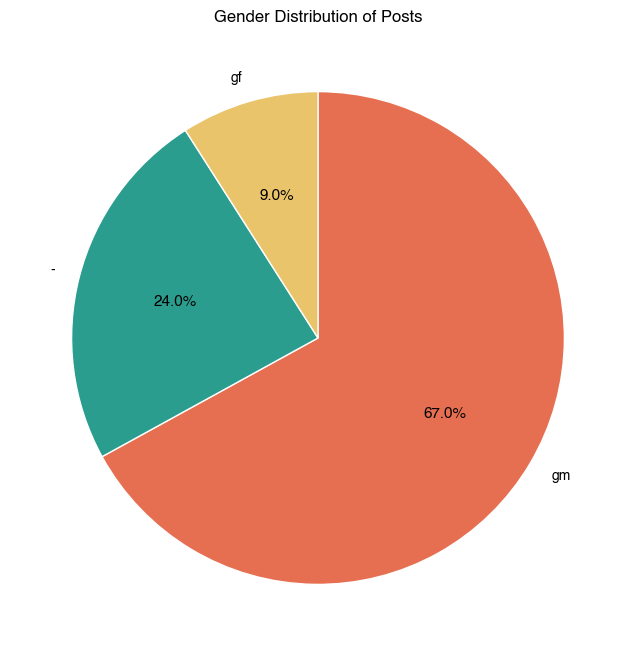

In [8]:
"""Analyze gender distribution"""
print("\n=== GENDER ANALYSIS ===")

gender_counts = combined_df['user_gender'].value_counts()
print(f"\nGender Distribution:")
for gender, count in gender_counts.items():
    percentage = (count / len(combined_df)) * 100
    print(f"{gender.title()}: {count:,} ({percentage:.1f}%)")

# Gender posts pie chart
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'},
        counterclock=False
        )
plt.title('Gender Distribution of Posts')
plt.savefig("img/gender_dist_posts.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Gender users pie chart
# Get unique users with their gender (remove duplicates)
unique_users = combined_df[['user.username', 'user_gender']].drop_duplicates()
user_gender_counts = unique_users['user_gender'].value_counts()

plt.pie(user_gender_counts.values, autopct='%1.1f%%', startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        labels=gender_counts.index,
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'},
        counterclock=False
        )
plt.title('Gender Distribution of Users')
plt.savefig("img/gender_dist_users.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Gender distribution by topics
gender_topic = combined_df[combined_df["super_topic"] != 'Misc'].groupby(['super_topic', 'user_gender']).size().unstack(fill_value=0)
gender_topic['total'] = gender_topic['gf'] + gender_topic['gm'] + gender_topic['-']
gender_topic['female_perc'] = (gender_topic['gf'] * 100) / gender_topic['total']
gender_topic['male_perc'] = (gender_topic['gm'] * 100) / gender_topic['total']
gender_topic['unknown_perc'] = (gender_topic['-'] * 100) / gender_topic['total']

gender_perc = gender_topic[['female_perc', 'male_perc', 'unknown_perc']]
gender_perc = gender_perc.rename(columns={'male_perc': 'male', 'female_perc': 'female', 'unknown_perc': 'unknown'})

ax = gender_perc.plot(kind="bar", figsize=(10,6), 
                       color=["#2a9d8f", "#e76f51", "#e9c46a"],
                       stacked=True,
                        )
plt.title('Gender Distribution by Topic')
plt.ylabel('Percentage of Posts')
plt.grid(axis='x')
plt.xlabel('Topic')
plt.legend(title='Gender', bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("img/gender_posts.pdf", dpi=300, bbox_inches="tight")
plt.show()



=== AUTHOR ANALYSIS ===

Total unique authors: 6,214
Authors with only 1 post: 2,982 (48.0%)
Authors with 10+ posts: 765
Authors with 50+ posts: 149

Top 10 Most Active Authors:
jkaufman: 1018 posts
Zvi: 936 posts
Stuart_Armstrong: 827 posts
KatjaGrace: 602 posts
MinibearRex: 590 posts
Eliezer_Yudkowsky: 449 posts
Raemon: 445 posts
lukeprog: 417 posts
johnswentworth: 356 posts
Kaj_Sotala: 309 posts


FileNotFoundError: [Errno 2] No such file or directory: 'img/authors_per_number_posts.pdf'

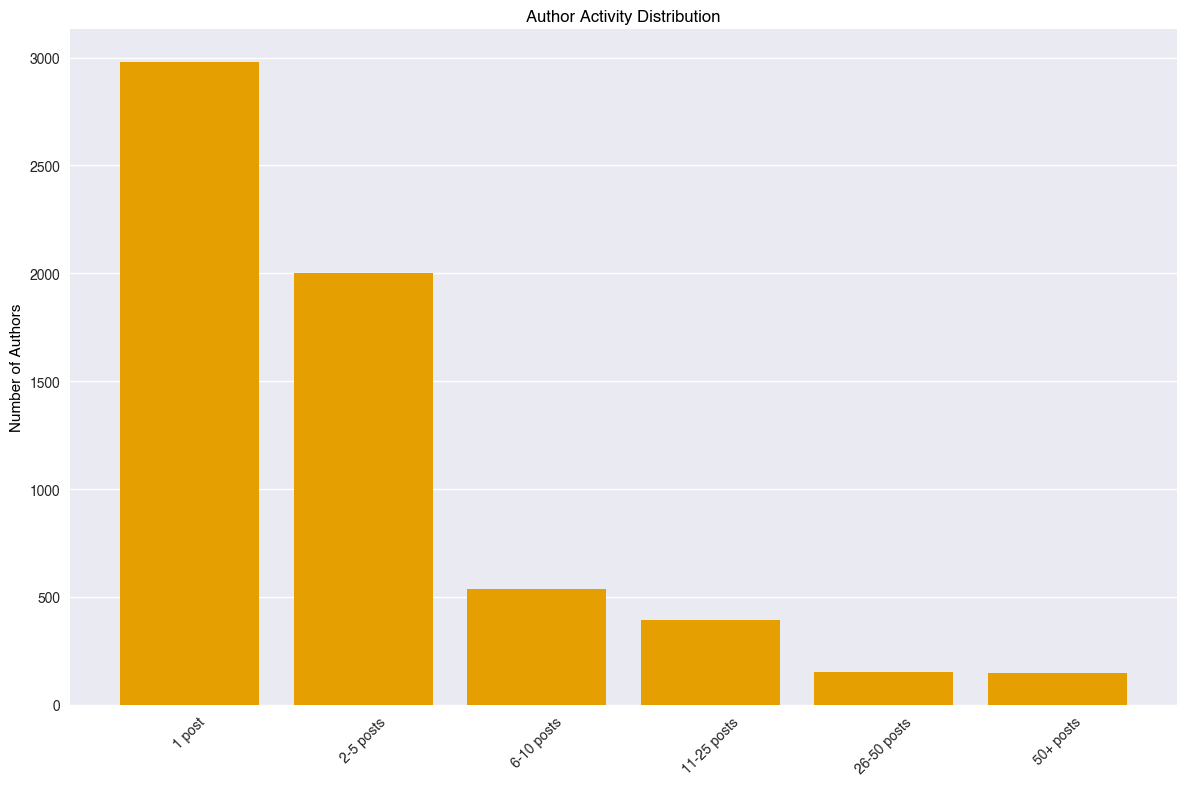

In [9]:
"""Analyze author activity patterns"""
print("\n=== AUTHOR ANALYSIS ===")

author_counts = combined_df['user.username'].value_counts()
print(f"\nTotal unique authors: {len(author_counts):,}")
print(f"Authors with only 1 post: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
print(f"Authors with 10+ posts: {(author_counts >= 10).sum():,}")
print(f"Authors with 50+ posts: {(author_counts >= 50).sum():,}")

print(f"\nTop 10 Most Active Authors:")
for author, count in author_counts.head(10).items():
    print(f"{author}: {count} posts")

# Author activity distribution
post_ranges = ['1 post', '2-5 posts', '6-10 posts', '11-25 posts', '26-50 posts', '50+ posts']
counts = [
    (author_counts == 1).sum(),
    ((author_counts >= 2) & (author_counts <= 5)).sum(),
    ((author_counts >= 6) & (author_counts <= 10)).sum(),
    ((author_counts >= 11) & (author_counts <= 25)).sum(),
    ((author_counts >= 26) & (author_counts <= 50)).sum(),
    (author_counts >= 50).sum()
]

plt.bar(post_ranges, counts)
plt.title('Author Activity Distribution')
plt.ylabel('Number of Authors')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("img/authors_per_number_posts.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Posts per author histogram (log scale)
plt.hist(author_counts.values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Posts per Author')
plt.ylabel('Number of Authors')
plt.title('Distribution of Posts per Author')
plt.yscale('log')
plt.tight_layout()
plt.savefig("img/posts_per_author_histogram.pdf", dpi=300, bbox_inches="tight")
plt.show()



=== TEMPORAL TRENDS ===

Posts by Year:
2009: 861 posts
2010: 1,163 posts
2011: 3,028 posts
2012: 2,657 posts
2013: 2,020 posts
2014: 1,820 posts
2015: 2,022 posts
2016: 1,316 posts
2017: 1,674 posts
2018: 1,842 posts
2019: 2,335 posts
2020: 3,113 posts
2021: 3,474 posts
2022: 4,736 posts
2023: 5,662 posts
2024: 4,637 posts
2025: 2,997 posts


FileNotFoundError: [Errno 2] No such file or directory: 'img/activity_heatmap.pdf'

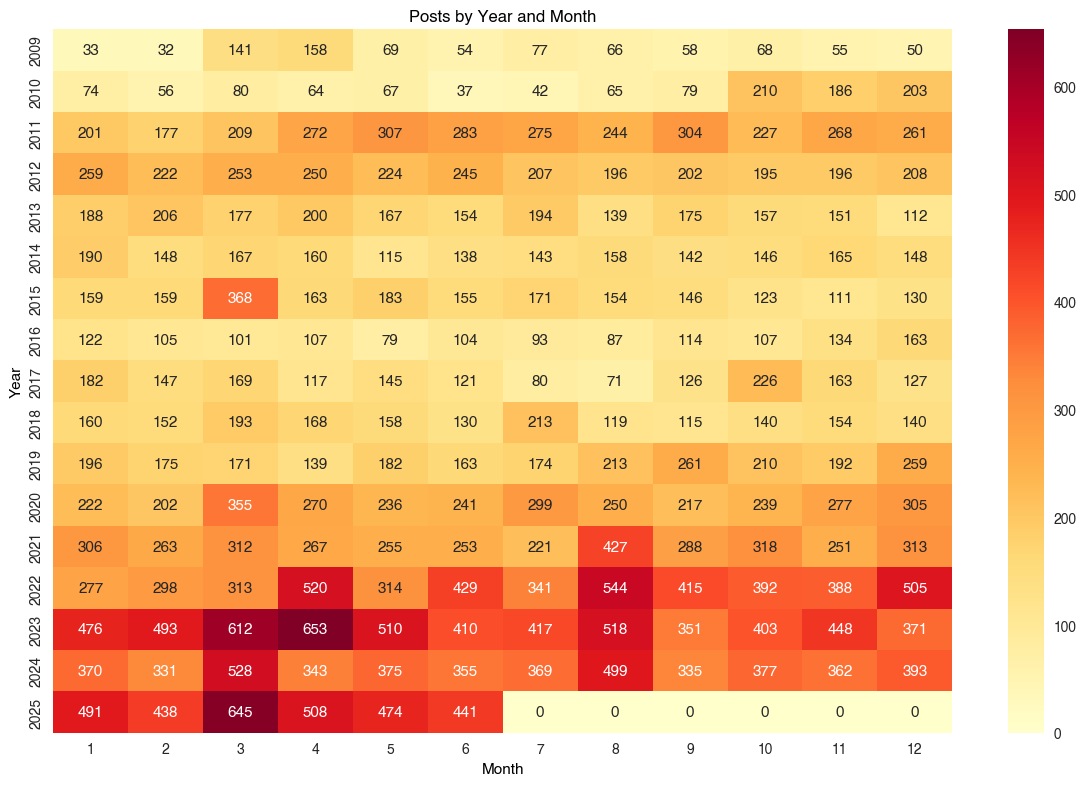

In [10]:
"""Analyze temporal trends"""
print("\n=== TEMPORAL TRENDS ===")

# Posts by year
yearly_posts = combined_df.groupby('year').size()
print(f"\nPosts by Year:")
for year, count in yearly_posts.items():
    print(f"{year}: {count:,} posts")

# Heatmap of posts by year and month
if 'month' in df.columns:
    heatmap_data = combined_df.groupby(['year', 'month']).size().unstack(fill_value=0)
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Posts by Year and Month')
    plt.xlabel('Month')
    plt.ylabel('Year')

plt.tight_layout()
plt.savefig('img/activity_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
"""Generate a comprehensive summary report"""
print("\n" + "="*60)
print("               LESSWRONG DATA SUMMARY REPORT")
print("="*60)

print(f"\n📊 OVERALL STATISTICS:")
print(f"   Total Posts: {len(combined_df):,}")
print(f"   Date Range: {combined_df['year'].min()}-{combined_df['year'].max()}")
print(f"   Unique Authors: {combined_df['user.username'].nunique():,}")
print(f"   Unique Topics: {combined_df['topic_label'].nunique()}")

print(f"\n👥 AUTHOR INSIGHTS:")
author_counts = combined_df['user.username'].value_counts()
print(f"   One-time contributors: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
print(f"   Prolific authors (10+ posts): {(author_counts >= 10).sum():,}")
print(f"   Super authors (50+ posts): {(author_counts >= 50).sum():,}")
print(f"   Most prolific: {author_counts.index[0]} with {author_counts.iloc[0]} posts")

print(f"\n🏷️  TOPIC INSIGHTS:")
topic_counts = combined_df['topic_label'].value_counts()
print(f"   Most popular topic: {topic_counts.index[0]} ({topic_counts.iloc[0]:,} posts)")
print(f"   Topics with 100+ posts: {(topic_counts >= 100).sum()}")

print(f"\n🚻 GENDER DISTRIBUTION:")
gender_counts = combined_df['user_gender'].value_counts()
for gender, count in gender_counts.items():
    percentage = (count / len(combined_df)) * 100
    print(f"   {gender.title()}: {count:,} ({percentage:.1f}%)")

print(f"\n📈 ENGAGEMENT METRICS:")
print(f"   Average score: {combined_df['baseScore'].mean():.1f}")
print(f"   Average comments: {combined_df['commentCount'].mean():.1f}")
print(f"   Highest scoring post: {combined_df.loc[combined_df['baseScore'].idxmax(), 'title'][:50]}...")
print(f"   Most commented post: {combined_df.loc[combined_df['commentCount'].idxmax(), 'title'][:50]}...")

print(f"\n📅 TEMPORAL TRENDS:")
yearly_posts = combined_df.groupby('year').size()
peak_year = yearly_posts.idxmax()
print(f"   Peak posting year: {peak_year} with {yearly_posts[peak_year]:,} posts")
print(f"   Growth from {yearly_posts.index[0]} to {yearly_posts.index[-1]}: {((yearly_posts.iloc[-1] / yearly_posts.iloc[0] - 1) * 100):+.1f}%")


               LESSWRONG DATA SUMMARY REPORT

📊 OVERALL STATISTICS:
   Total Posts: 45,357
   Date Range: 2009-2025
   Unique Authors: 6,214


KeyError: 'topic_label'

Sample of extracted_links:
0                                                                                                                                                                                  https://lesswrong.com/meetups/rp; https://lesswrong.com/meetups/rp
1                                                                                                                                                                                  https://lesswrong.com/meetups/ro; https://lesswrong.com/meetups/ro
2    https://lesswrong.com/user/therufs/submitted/r/discussion/lw/hg0/group_rationality_diary_may_1631/user/cata; https://lesswrong.com/r/discussion/lw/iho/group_rationality_diary_september_1630/; http://wiki.lesswrong.com/wiki/Rationality_Diary
3                                          https://lesswrong.com/meetups/rn; https://maps.google.com/maps?q=10850+West+Pico+Blvd,+Suite+312,+Los+Angeles,+CA+90064; http://wiki.lesswrong.com/wiki/Bayes%27_theorem; https://lesswrong.com/

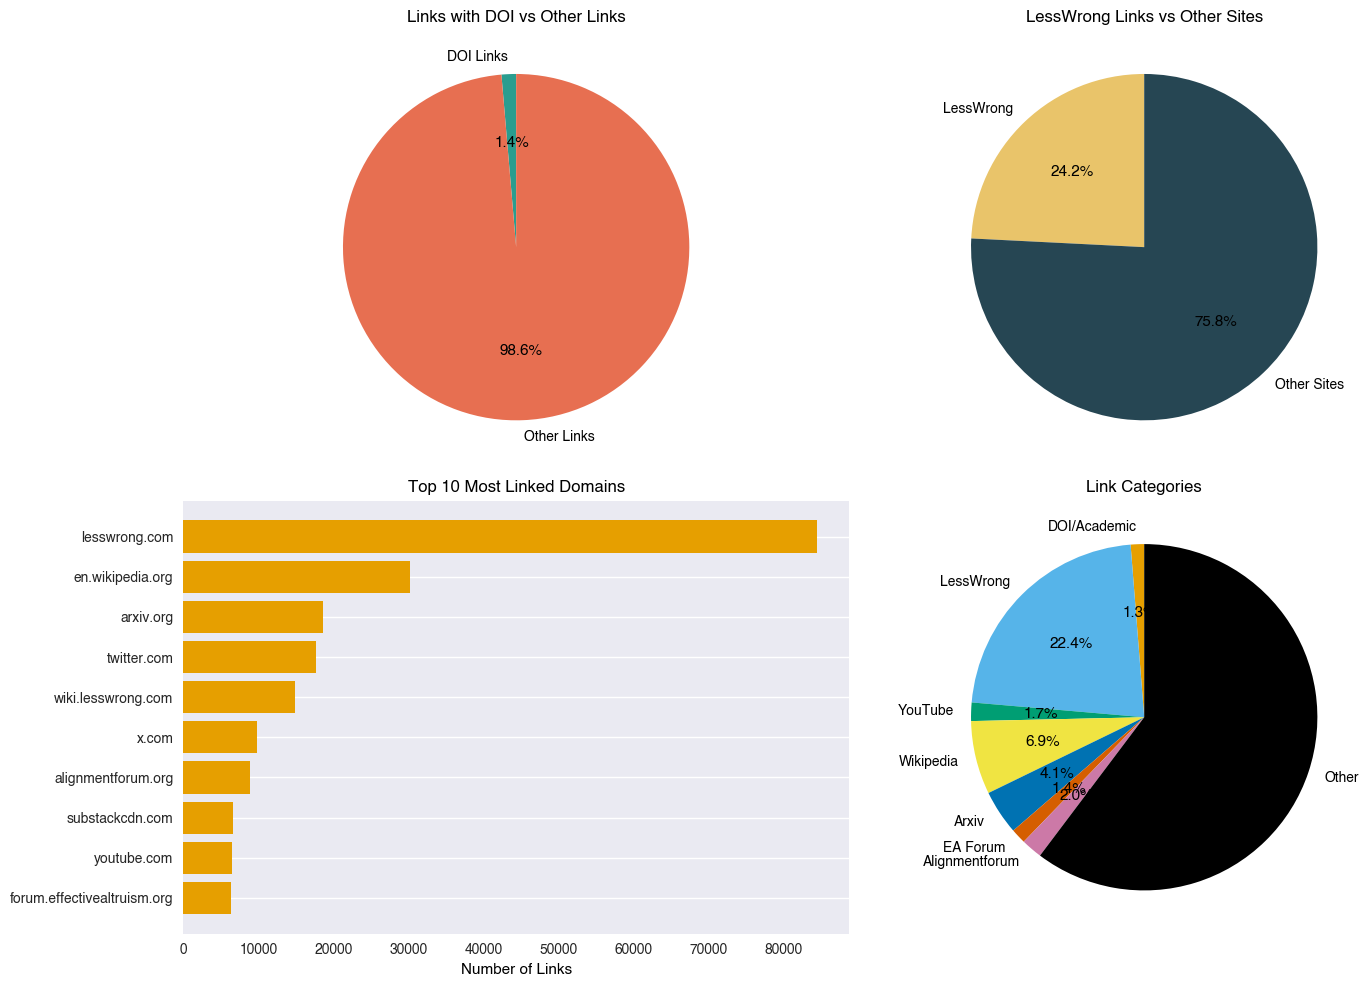


=== ADDITIONAL INSIGHTS ===
YouTube links: 7741 (1.9%)
Wikipedia links: 30860 (7.4%)
GitHub links: 5161 (1.2%)

=== SAMPLE LINKS FOR VERIFICATION ===
Sample DOI links: ['http://link.springer.com/article/10.1007/s11238-006-9004-4', 'http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476620', 'http://www.nature.com/naturejobs/science/articles/10.1038/nj7312-240a']
Sample LessWrong links: ['https://lesswrong.com/meetups/rp', 'https://lesswrong.com/meetups/rp', 'https://lesswrong.com/meetups/ro']


In [80]:
print("Sample of extracted_links:")
print(combined_df['extracted_links'].head(10))
print(f"\nTotal rows with links: {combined_df['extracted_links'].notna().sum()}")

all_links = []

for entry in combined_df['extracted_links'].dropna():
    if isinstance(entry, str):
        # Split by semicolon first!
        links = [link.strip() for link in entry.split(';') if link.strip()]
        all_links.extend(links)
    elif isinstance(entry, list):
        all_links.extend(entry)
    else:
        # Convert to string and split
        links = [link.strip() for link in str(entry).split(';') if link.strip()]
        all_links.extend(links)

# Final cleaning (remove empty strings)
clean_links = [l for l in all_links if l]

# 1. DOI Analysis
doi_pattern = r'10\.\d{4,9}/[^\s;<>"]+' #r'(doi:|dx\.doi\.org|doi\.org)'
doi_links = [link for link in clean_links if re.search(doi_pattern, link, re.IGNORECASE)]
doi_count = len(doi_links)

arxiv_pattern = r'(arxiv\.org/)'
arxiv_links = [link for link in clean_links if re.search(arxiv_pattern, link, re.IGNORECASE)]

print(f"\n=== DOI ANALYSIS ===")
print(f"Links containing DOI: {doi_count} ({doi_count/len(clean_links)*100:.1f}%)")

# 2. LessWrong Analysis  
lesswrong_links = [link for link in clean_links if 'lesswrong' in link.lower()]
lesswrong_count = len(lesswrong_links)

print(f"\n=== LESSWRONG ANALYSIS ===")
print(f"Links pointing to LessWrong: {lesswrong_count} ({lesswrong_count/len(clean_links)*100:.1f}%)")

# 3. Domain Analysis - Extract domains from all links
def extract_domain(url):
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        # Remove www. prefix for cleaner grouping
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return 'invalid_url'

domains = [extract_domain(link) for link in clean_links]
domain_counts = pd.Series(domains).value_counts()

print(f"\n=== TOP DOMAINS ===")
print("Top 15 domains:")
for domain, count in domain_counts.head(15).items():
    percentage = count/len(clean_links)*100
    print(f"{domain}: {count} links ({percentage:.1f}%)")

# 4. Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: DOI vs Non-DOI
plt.subplot(2, 2, 1)
doi_data = ['DOI Links', 'Other Links']
doi_values = [doi_count, len(clean_links) - doi_count]
plt.pie(doi_values, labels=doi_data, autopct='%1.1f%%', startangle=90,
        colors=["#2a9d8f", "#e76f51"])
plt.title('Links with DOI vs Other Links')

# Subplot 2: LessWrong vs Others
plt.subplot(2, 2, 2)
lw_data = ['LessWrong', 'Other Sites']
lw_values = [lesswrong_count, len(clean_links) - lesswrong_count]
plt.pie(lw_values, labels=lw_data, autopct='%1.1f%%', startangle=90,
        colors=["#e9c46a", "#264653"])
plt.title('LessWrong Links vs Other Sites')

# Subplot 3: Top domains bar chart
plt.subplot(2, 2, 3)
top_domains = domain_counts.head(10)
plt.barh(range(len(top_domains)), top_domains.values)
plt.yticks(range(len(top_domains)), top_domains.index)
plt.xlabel('Number of Links')
plt.title('Top 10 Most Linked Domains')
plt.gca().invert_yaxis()

# Subplot 4: Link type categories
plt.subplot(2, 2, 4)
categories = {
    'DOI/Academic': doi_count,
    'LessWrong': lesswrong_count,
    'YouTube': len([d for d in domains if 'youtube' in d or 'youtu.be' in d]),
    'Wikipedia': len([d for d in domains if 'wikipedia' in d]),
    'Arxiv': len([d for d in domains if 'arxiv' in d]),
    'EA Forum': len([d for d in domains if 'forum.effectivealtruism' in d]),
    'Alignmentforum': len([d for d in domains if 'alignmentforum' in d]),
    'Other': len(clean_links) - doi_count - lesswrong_count - 
             len([d for d in domains if 'youtube' in d or 'youtu.be' in d]) -
             len([d for d in domains if 'wikipedia' in d])
}

plt.pie(categories.values(), labels=categories.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Link Categories')

plt.tight_layout()
#plt.savefig("img/link_analysis.pdf", dpi=300, bbox_inches="tight")
plt.show()

# 5. Additional insights
print(f"\n=== ADDITIONAL INSIGHTS ===")
youtube_count = len([d for d in domains if 'youtube' in d or 'youtu.be' in d])
wikipedia_count = len([d for d in domains if 'wikipedia' in d])
github_count = len([d for d in domains if 'github' in d])

print(f"YouTube links: {youtube_count} ({youtube_count/len(clean_links)*100:.1f}%)")
print(f"Wikipedia links: {wikipedia_count} ({wikipedia_count/len(clean_links)*100:.1f}%)")
print(f"GitHub links: {github_count} ({github_count/len(clean_links)*100:.1f}%)")

# Show some example links for verification
print(f"\n=== SAMPLE LINKS FOR VERIFICATION ===")
if doi_links:
    print(f"Sample DOI links: {doi_links[:3]}")
if lesswrong_links:
    print(f"Sample LessWrong links: {lesswrong_links[:3]}")

In [81]:
import re
import pandas as pd

def extract_doi_from_link(link):
    """
    Extract clean DOI from any URL, removing URL fragments and query params
    """
    if not link or not isinstance(link, str):
        return None
    
    # Find DOI pattern (10.xxxx/...)
    doi_match = re.search(r'10\.\d{4,9}/[^\s;<>"?#]+', link, re.IGNORECASE)
    if not doi_match:
        return None
    
    doi = doi_match.group()
    
    # Remove common URL fragments that aren't part of the DOI
    # These often appear after the DOI in URLs
    doi = re.sub(r'/(abstract|full|pdf|epdf|summary)$', '', doi, flags=re.IGNORECASE)
    
    # Remove trailing punctuation
    doi = re.sub(r'[.,;:)\]]+$', '', doi)
    
    return doi.strip().lower()

def normalize_doi(doi_string):
    """Normalize DOI by removing URL prefixes"""
    if not doi_string or not isinstance(doi_string, str):
        return None
    
    doi = doi_string.strip().lower()
    # Remove URL wrappers
    doi = re.sub(r'https?://(dx\.)?doi\.org/', '', doi)
    doi = re.sub(r'doi:', '', doi)
    
    return doi.strip() if doi else None

In [82]:
doi_extracted = [extract_doi_from_link(link) for link in clean_links]
doi_clean_list = [d for d in doi_extracted if d]
df_doi = pd.DataFrame({'doi_clean': doi_clean_list}).drop_duplicates()

In [133]:
nodes = pd.read_csv("../data/nodes_openalex_works.csv")
nodes['doi_clean'] = nodes['openalex_doi'].apply(normalize_doi)

In [134]:
matched_doi = df_doi.merge(
    nodes[['openalex_id', 'doi_clean']],
    on='doi_clean',
    how='inner'
)

In [135]:
total_unique_citations = len(df_doi)
matched_count = len(matched_doi)
coverage = matched_count / total_unique_citations

print(f"Total unique DOI citations: {total_unique_citations}")
print(f"Matched in OpenAlex: {matched_count}")
print(f"Coverage: {coverage:.1%}")


Total unique DOI citations: 4398
Matched in OpenAlex: 106
Coverage: 2.4%


In [136]:
if coverage < 0.3:  # If less than 30%
    print("\n⚠️ Low coverage detected. Checking reasons...")
    
    # Sample unmatched DOIs
    matched_set = set(matched_doi['doi_clean'])
    unmatched = df_doi[~df_doi['doi_clean'].isin(matched_set)]
    
    print(f"\nSample unmatched DOIs (first 10):")
    for doi in unmatched['doi_clean'].head(10):
        print(f"  {doi}")


⚠️ Low coverage detected. Checking reasons...

Sample unmatched DOIs (first 10):
  10.1007/s11238-006-9004-4
  10.1080/01621459.1995.10476620
  10.1038/nj7312-240a
  10.1371/journal.pone.0065522
  10.1002/14651858.cd000371.pub5
  10.1002/9781119993384
  10.1111/j.1753-4887.1974.tb05180.x
  10.1080/13674679908406332
  10.1521/jscp.23.5.603.50748
  10.1521/jscp.2000.19.1.56


In [137]:
import time 
import requests

def check_doi_in_openalex(doi):
    """
    Check if a DOI exists in OpenAlex and get basic info including ALL topics
    """
    url = f"https://api.openalex.org/works/https://doi.org/{doi}"
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            topics = data.get('topics', [])
            
            # Get all topics with their details
            all_topics = [
                {
                    'name': t.get('display_name'),
                    'id': t.get('id', '').split('/')[-1],
                    'score': t.get('score', 0)
                }
                for t in topics
            ]
            
            # Check for AI-related keywords
            topic_text = ' '.join([t['name'].lower() for t in all_topics])
            ai_keywords = ['artificial intelligence', 'machine learning', 'deep learning', 
                          'neural network', 'ai safety', 'ai alignment', 'reinforcement learning',
                          'natural language processing', 'computer vision', 'robotics', 'ai']
            
            has_ai = any(keyword in topic_text for keyword in ai_keywords)
            
            return {
                'doi': doi,
                'exists': True,
                'openalex_id': data.get('id', '').split('/')[-1],
                'title': data.get('title', '')[:100],
                'publication_year': data.get('publication_year'),
                'all_topics': all_topics,
                'topics_display': ', '.join([t['name'] for t in all_topics[:5]]),
                'has_ai_topic': has_ai,
                'cited_by_count': data.get('cited_by_count')
            }
        elif response.status_code == 404:
            return {
                'doi': doi,
                'exists': False,
                'has_ai_topic': False,
                'reason': 'Not found in OpenAlex'
            }
        else:
            return {
                'doi': doi,
                'exists': False,
                'has_ai_topic': False,
                'reason': f'HTTP {response.status_code}'
            }
    except Exception as e:
        return {
            'doi': doi,
            'exists': False,
            'has_ai_topic': False,
            'reason': f'Error: {str(e)}'
        }
    
print("="*80)
print("CHECKING UNMATCHED DOIs FOR AI-RELATED TOPICS")
print("="*80)
print("\nThis will check if these DOIs have AI-related topics...\n")

results = []
for i, doi in enumerate(unmatched_dois, 1):
    print(f"Checking {i}/{len(unmatched_dois)}: {doi}")
    result = check_doi_in_openalex(doi)
    results.append(result)
    
    if result['exists']:
        ai_indicator = "🤖 HAS AI" if result['has_ai_topic'] else "📚 NO AI"
        print(f"  ✅ {ai_indicator}")
        print(f"     Title: {result['title']}")
        print(f"     Year: {result['publication_year']}")
        print(f"     Topics: {result['topics_display']}")
    else:
        print(f"  ❌ NOT FOUND: {result.get('reason', 'Unknown')}")
    
    print()
    time.sleep(0.5)  # Be polite to OpenAlex API

# Summary
df_results = pd.DataFrame(results)
exists_count = df_results['exists'].sum()
missing_count = len(df_results) - exists_count
has_ai = df_results['has_ai_topic'].sum()

print("="*80)
print("SUMMARY")
print("="*80)
print(f"✅ Found in OpenAlex: {exists_count}/{len(unmatched_dois)}")
print(f"❌ Not in OpenAlex: {missing_count}/{len(unmatched_dois)}")
print(f"🤖 Has AI-related topics: {has_ai}/{exists_count} (of those found)")

if has_ai > 0:
    print("\n" + "="*80)
    print("🤖 PAPERS WITH AI-RELATED TOPICS (should have been in your dataset!):")
    print("="*80)
    for _, row in df_results[df_results['has_ai_topic'] == True].iterrows():
        print(f"\n{row['doi']}:")
        print(f"  Title: {row['title']}")
        print(f"  Topics: {row['topics_display']}")
        print(f"  → This paper HAS AI topics but wasn't in your filtered dataset!")

if exists_count > 0 and has_ai < exists_count:
    print("\n" + "="*80)
    print("📚 PAPERS WITHOUT AI TOPICS (correctly filtered out):")
    print("="*80)
    for _, row in df_results[(df_results['exists'] == True) & (df_results['has_ai_topic'] == False)].iterrows():
        print(f"\n{row['doi']}:")
        print(f"  Title: {row['title']}")
        print(f"  Topics: {row['topics_display']}")
        print(f"  → This is about other fields (decision theory, stats, etc.)")

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("TO CHECK ALL YOUR UNMATCHED DOIs:")

# Load your actual unmatched DOIs
unmatched_dois_full = df_doi[~df_doi['doi_clean'].isin(matched_doi['doi_clean'])]['doi_clean'].tolist()

# Check a sample or all of them
results_all = []
no_doi_papers = []
for i, doi in enumerate(unmatched_dois_full, 1):  # Check first 100
    print(f"Checking {i}/{len(unmatched_dois_full)}: {doi}", end='\\r')
    result = check_doi_in_openalex(doi)
    results_all.append(result)
    no_doi_papers.append(doi)
    time.sleep(0.5)

df_all_results = pd.DataFrame(results_all)
print(f"\\nAI-related papers missed: {df_all_results['has_ai_topic'].sum()}")
print(f"Percentage: {df_all_results['has_ai_topic'].sum()/len(df_all_results)*100:.1f}%")
print(f'Topics missed: {no_doi_papers}')

CHECKING UNMATCHED DOIs FOR AI-RELATED TOPICS

This will check if these DOIs have AI-related topics...

Checking 1/10: 10.1007/s11238-006-9004-4
  ✅ 📚 NO AI
     Title: Uncommon Priors Require Origin Disputes
     Year: 2006
     Topics: Game Theory and Applications, Game Theory and Voting Systems, Experimental Behavioral Economics Studies

Checking 2/10: 10.1080/01621459.1995.10476620
  ✅ 📚 NO AI
     Title: Are People Bayesian? Uncovering Behavioral Strategies
     Year: 1995
     Topics: Decision-Making and Behavioral Economics, Economic and Environmental Valuation, Forecasting Techniques and Applications

Checking 3/10: 10.1038/nj7312-240a
  ✅ 📚 NO AI
     Title: Running the show
     Year: 2010
     Topics: 

Checking 4/10: 10.1371/journal.pone.0065522
  ✅ 📚 NO AI
     Title: The Ketogenic Diet and Hyperbaric Oxygen Therapy Prolong Survival in Mice with Systemic Metastatic C
     Year: 2013
     Topics: Diet and metabolism studies, Cancer, Hypoxia, and Metabolism, Metabolism, Diab

KeyboardInterrupt: 

In [89]:
ai_related_dois = no_doi_papers

In [ ]:
non_detected = ['10.1007/s11238-006-9004-4', '10.1080/01621459.1995.10476620', '10.1038/nj7312-240a', '10.1371/journal.pone.0065522', '10.1002/14651858.cd000371.pub5', '10.1002/9781119993384', '10.1111/j.1753-4887.1974.tb05180.x', '10.1080/13674679908406332', '10.1521/jscp.23.5.603.50748', '10.1521/jscp.2000.19.1.56', '10.1002/9780470713853.ch2', '10.1111/j.1468-2958.2007.00293.x', '10.1056/nejmoa1307352', '10.1038/nature.2012.11535', '10.1111/j.1600-0404.1995.tb07018.x', '10.1056/nejmoa013536', '10.1007/s10995-012-1034-7/fulltext.html', '10.1142/s1793843012400057', '10.2307/2586011', '10.3389/fpsyg.2013.00073', '10.1007/978-3-642-25510-6_13', '10.1056/nejmoa1205037', '10.1080/13504850150204174', '10.1111/j.1365-2753.2011.01767.x', '10.1002/ejsp.295', '10.2307/1828886', '10.2307/1912309', '10.1080/00048408112340011', '10.2307/20115662', '10.2307/40267481', '10.1007/s11229-011-0022-6', '10.1146/annurev-psych-120710-100350', '10.1142/s1793843011000686', '10.1111/j.1749-6632.1989.tb15050.x', '10.2307/2677856', '10.1111/j.1467-8543.2009.00723.x', '10.1002/%28issn%291099-131x', '10.1175/bams-84-7-876', '10.3389/fnbeh.2013.00206', '10.1175/2008waf2007088.1', '10.1007/978-0-387-32353-4_29', '10.1016/j.epsl.2004.03.004', '10.1029/2004gl021750/', '10.1056/nejmsa065779', '10.1055/s-2005-837806', '10.3109/10401230209147454', '10.1056/nejm200105243442106', '10.1002/2013ef000165', '10.1007/s10584-010-9801-1', '10.1175/2009bams2778.1', '10.1016/j.futures.2009.11.003', '10.1016/0024-6301(83)90013-4', '10.1016/j.aop.2014.04.021', '10.1103/physrev.106.620', '10.1103/physrev.108.171', '10.3389/fnana.2012.00032', '10.1111/j.1755-2567.1996.tb00529.x', '10.1080/09668136.2013.824140', '10.1007/s11948-014-9559-3', '10.1300/j020v18n04_01', '10.1056/nejm199109123251105', '10.1111/j.1360-0443.1988.tb00454.x', '10.2307/4132491', '10.1080/07399019108964994', '10.1016/j.jfineco.2005.08.002', '10.1016/j.ijforecast.2007.01.004', '10.1016/s0040-1625(01)00172-x', '10.1111/ijcp.12026', '10.1111/jssr.12046', '10.1007/s002650100346', '10.1007/s00265-001-0420-8', '10.1098/rspb.2010.1045', '10.1006/anbe.2001.1925', '10.1111/add.12050', '10.1111/j.1600-0447.2012.01913.x', '10.1038/oby.2006.81', '10.1056/nejmoa0708681', '10.1002/ejsp.674', '10.1146/annurev-publhealth-032013-182351', '10.1210/jc.2002-021480', '10.1080/00365520500235334', '10.1371/journal.pone.0073182', '10.1007/s004310051070', '10.1002/cncr.10427', '10.1007/978-3-540-27836-8_40', '10.1002/14651858.cd004366.pub5', '10.1007/s11013-007-9050-6', '10.1002/14651858.cd002835.pub3', '10.1073/pnas.1620732114', '10.1186/s12961-017-0192-x', '10.1177/2515245917747646', '10.1177/23780231211024421', '10.1177/0146167207301028', '10.1038/s42256-019-0048-x', '10.1007/s12685-013-0088-9', '10.1007/978-94-007-3932-1', '10.1007/978-94-017-2527-9_3', '10.1016/0014-4983(88)90014-9', '10.4324/9781315019550&type=googlepdf', '10.1257/pol.2.3.111', '10.1016/j.eeh.2015.01.001', '10.1111/1468-0297.00533', '10.1086/506401', '10.1007/s11926-021-01015-9', '10.2105/ajph.48.9.1134', '10.1146/annurev-immunol-030409-101314', '10.1007/s00265-012-1465-6', '10.48550/arxiv.2203.02155', '10.1073/pnas.1317937111', '10.1126/science.abq0839', '10.1371/journal.pbio.1002106', '10.1073/pnas.1903070116', '10.1103/physrevresearch.4.013201', '10.1017/xps.2021.4', '10.1016/j.cobeha.2020.03.012', '10.1037/a0028526', '10.1145/3135932.3135941', '10.3389/fcimb.2019.00002', '10.1080/00365521.2019.1585939', '10.1126/science.aau8816', '10.3389/fmicb.2018.01510', '10.1214/21-ss133.full', '10.1137/19m1308943', '10.1257/app.20180463', '10.1257/app.20190629', '10.1056/nejmcpc2201244', '10.1111/j.1600-0447.1966.tb01915.x', '10.2202/1935-1682.1796/html', '10.3389/fpsyg.2020.01723/', '10.1177/001979391306600503', '10.1111/j.1467-8292.2011.00437.x', '10.3389/neuro.09.031.2009', '10.1126/sciimmunol.ade2798', '10.1101/2022.09.29.509744v1.full', '10.1007/978-3-662-47992-6', '10.1145/3345252.3345292', '10.1049/ise2.12052', '10.1257/mac.20170388', '10.3102/0034654319877156', '10.1146/annurev.neuro.31.060407.125639', '10.1126/science.aav7893', '10.1371/journal.pcbi.1010682', '10.1002/cne.23458', '10.1126/science.292.5523.1791a', '10.1007/978-1-4899-7216-3_28', '10.1177/0162243915579283', '10.1101/2022.11.14.22282286v1', '10.48550/arxiv.2210.05492', '10.48550/arxiv.2110.02924', '10.1016/j.tics.2020.07.007', '10.1016/j.procs.2020.02.231', '10.1007/s11023-012-9281-3', '10.1097/wnn.0000000000000319', '10.1371/journal.pone.0013199', '10.34133/2019/2369041', '10.2307/2268810', '10.3389/fpsyg.2014.01588', '10.1111/ap.12115', '10.3389/fpsyg.2019.01401', '10.1007/bf01700692', '10.1093/aristoteliansupp/48.1.135', '10.1037/h0054346', '10.3389/fnsys.2019.00025', '10.1136/jech.2006.054254', '10.1207/s15516709cog2703_8', '10.1126/science.171.3972.701', '10.1186/1471-2202-5-42', '10.1037/0278-7393.8.4.336', '10.3389/fnsys.2022.768201', '10.1073/pnas.2120042119', '10.1080/01973533.2017.1323638', '10.1080/00223890701268074', '10.1073/pnas.1721903115', '10.1016/j.paid.2010.03.027', '10.1177/0956797610396227', '10.1037/1040-3590.2.3.338', '10.1002/bsl.722', '10.1037/dev0000140', '10.3389/fpsyt.2019.00627', '10.1017/s0954579409000492', '10.1186/s13052-017-0404-6', '10.1016/s0028-3932(02)00175-6', '10.1111/psyp.12908', '10.3389/fpsyg.2021.661044', '10.1016/j.bpsc.2018.04.002', '10.1038/nrn844', '10.1136/ip.8.suppl_4.iv17', '10.1016/j.ijlp.2009.04.007', '10.1192/bjp.bp.111.107128', '10.1073/pnas.1917036117', '10.1140/epjb/e2008-00175-0.pdf', '10.1177/1747021818772045', '10.1007/s10892-019-09307-0', '10.7326/m22-2141', '10.1080/09515089.2017.1406600', '10.5555/645529.657801', '10.1073/pnas.0437847100', '10.1126/science.abi5052', '10.1093/ajcn/78.3.626s', '10.1073/pnas.2215633119', '10.1073/pnas.1011492107', '10.1098/rstb.2013.0478', '10.1111/phpr.12067', '10.1126/science.abm0271', '10.7326/m22-1966', '10.1073/pnas.2016976118', '10.1007/978-3-319-16999-6_2422-1', '10.1007/s10071-011-0445-y', '10.1007/s11098-017-0966-6', '10.1080/19440049.2019.1704445', '10.1080/026520399283876', '10.1007/s12403-019-00324-w', '10.1017/s0007114508055670', '10.1080/0265203021000031573', '10.6133/apjcn.2013.22.2.06', '10.1007/s002170050393', '10.1111/j.1600-0447.1976.tb00067.x', '10.1097/00004850-199007000-00007', '10.1007/s40266-014-0221-1', '10.1016/s2213-8587(21)00207-2', '10.1016/0890-6238(94)00069-7', '10.1016/j.scitotenv.2020.144691', '10.1016/j.jtemb.2021.126830', '10.20471/dec.2017.53.02.01', '10.3390/nu12082489', '10.1007/bf00310450', '10.1016/j.envint.2015.01.011', '10.1016/j.fct.2013.10.026', '10.1002/14651858.cd004048.pub4', '10.1016/s0140-6736(11)61516-x', '10.1038/nrendo.2018.18', '10.7326/0003-4819-144-3-200602070-00007', '10.1016/s0272-6386(87)80098-7', '10.1111/j.1600-0447.1980.tb00607.x', '10.1111/j.1600-0447.1988.tb06363.x', '10.1111/j.1600-0447.1989.tb03022.x', '10.1192/s0007125000145544', '10.1176/ajp.2006.163.7.1199', '10.1111/j.1600-0447.1970.tb02116.x', '10.1097/yic.0b013e328333ac1b', '10.1016/j.jad.2008.05.014', '10.1111/obr.12785', '10.1080/03014460410001663434', '10.1002/ajhb.20591', '10.1056/nejm198911303212201', '10.1016/0022-3956(89)90006-x', '10.1001/archpsyc.1992.01820050035005', '10.1016/j.heliyon.2020.e04528', '10.1038/nature14177', '10.1007/s11606-015-3390-7', '10.1016/j.foodchem.2011.12.009', '10.1080/02652030500135367', '10.1007/s12403-019-00324-w/tables/2', '10.1007/s12011-013-9815-4', '10.1111/j.1365-2621.1969.tb01519.x', '10.1080/07315724.2002.10719188', '10.1097/00004850-198610000-00007', '10.3109/00048679809062720', '10.1007/s11109-019-09543-y', '10.1111/1475-6765.00587', '10.1126/science.abc6182', '10.1111/j.1468-5930.2008.00410.x', '10.1146/annurev-neuro-072116-031526', '10.1257/aer.101.7.2899', '10.7554/elife.59410', '10.1111/tops.12142', '10.48550/arxiv.1711.06892', '10.1111/cogs.12101', '10.48550/arxiv.1207.5879', '10.1111/1467-9280.00350', '10.1093/acprof:oso/9780199653645.001.0001/acprof-9780199653645', '10.3389/fpsyg.2016.00867', '10.1126/science.7466396', '10.23941/ejpe.v13i2.501', '10.1057/eej.2008.20', '10.3389/fnhum.2017.00588', '10.48550/arxiv.1801.00631', '10.1080/1369118x.2018.1476576', '10.1145/3473604.3474560', '10.1257/aer.90.4.806', '10.1073/pnas.0503610102', '10.2144/btn-2022-0007', '10.1007/s10677-015-9567-7', '10.1111/1758-5899.12718', '10.1007/978-3-540-45248-5_10', '10.1093/rheumatology/38.7.636', '10.1111/j.1475-097x.2006.00671.x', '10.1007/s11116-019-09983-9.pdf', '10.1177/00116502034004007', '10.1002/hec.1389', '10.1086/588220', '10.1080/19361610.2018.1422360', '10.1140/epjds/s13688-021-00278-7', '10.1371/journal.pone.0203000&type=printable', '10.1371/journal.pone.0264394', '10.1007/s10676-020-09535-1', '10.1007/s10676-018-9486-0', '10.1007/s13164-020-00495-5', '10.1007/s10676-021-09611-0', '10.1007/978-3-319-59719-5.pdf', '10.1007/s11023-020-09524-9', '10.1007/s43681-020-00001-8', '10.1016/0031-3203(75)90005-9', '10.3389/fpsyg.2020.00164', '10.1177/2158244020938702', '10.1177/1365480216659733', '10.1111/j.1600-6143.2004.00664.x', '10.1007/s10888-019-09413-x.pdf', '10.1101/2022.01.08.22268954v4', '10.7326/m22-0202', '10.1101/2022.01.18.22269426v1', '10.1128/spectrum.00217-22', '10.1128/spectrum.00683-21', '10.1093/acprof:osobl/9780199552047.001.0001/acprof-9780199552047', '10.1126/science.aag3311', '10.1007/s10506-016-9178-1', '10.1145/3306618.3314250', '10.1007/s10506-021-09300-9', '10.1108/jices-09-2014-0038/full/html', '10.1080/09636412.2021.1915583', '10.1177/1745691615617439', '10.1111/jcpp.12647', '10.1002/oby.23116', '10.1111/j.1558-5646.2011.01546.x', '10.1371/journal.pone.0049294', '10.1080/03637751.2020.1760327', '10.1111/j.1743-6109.2011.02300.x', '10.1080/10683160802621925', '10.4324/9780203838013-8/nature-nurture-robert-plomin', '10.1371/journal.pone.0060542', '10.1073/pnas.1120666109', '10.1007/s10888-019-09413-x', '10.1177/1948550611412793', '10.1007/s12110-020-09380-7', '10.1007/s10519-011-9483-0', '10.1007/s10578-020-01119-w', '10.1073/pnas.1818711116', '10.1177/14789299211053780', '10.1017/s0022381610001015', '10.1177/1065912917698045', '10.1177/0095327x18765449', '10.1098/rstb.2015.0015', '10.1007/s10519-010-9388-3', '10.1007/s11920-019-1008-1', '10.31887/dcns.2017.19.3/pgorwood', '10.1007/978-3-030-36391-8_63', '10.3389/fpsyg.2017.02121', '10.1111/adb.12218', '10.1023/a:1019772628912', '10.1101/2020.12.09.417725v2.abstract', '10.1126/science.aat8464', '10.1111/gbb.12537', '10.1002/ajpa.20945', '10.1073/pnas.0800376105', '10.1080/09658211.2022.2122998', '10.1086/505234', '10.1086/669564', '10.1093/jleo/ewac017/6718089', '10.1177/01461672221125619', '10.1056/nejmoa2208343', '10.1126/science.131.3410.1355', '10.1007/978-1-4615-0759-8', '10.1177/00027162211062137', '10.1287/orsc.2022.1619', '10.1007/978-0-387-30164-8_731', '10.1287/mnsc.1050.0451', '10.3389/fnana.2017.00118', '10.1073/pnas.1517131113', '10.48550/arxiv.1906.04284', '10.48550/arxiv.2204.12130', '10.48550/arxiv.2203.14680', '10.48550/arxiv.2209.02535', '10.1145/3357384.3358028', '10.1145/3110025.3110087', '10.1037/0003-066x.44.5.775', '10.1348/014466608x377396', '10.1177/0956797611411057', '10.1088/1742-6596/1168/2/022022/meta', '10.1145/3306618.3314259', '10.1177/0022022110381429', '10.1145/3457607', '10.1371/journal.pbio.3001775', '10.1073/pnas.2013741118', '10.1101/2022.03.21.485207v1', '10.1007/s00404-019-05385-5', '10.1111/j.1469-185x.2011.00195.x', '10.1056/nejmoa1214939', '10.1057/9781137461285_5', '10.1098/rstb.2015.0450', '10.1140/epjds/s13688-020-00231-0', '10.1126/science.adh8489', '10.1101/2023.05.19.540391', '10.3389/frobt.2017.00060', '10.3389/fpsyg.2015.00006', '10.3389/fpsyg.2015.00500', '10.1126/science.abj3259', '10.1093/acprof:oso/9780195172379.001.0001/acprof-9780195172379', '10.1126/science.aan8871', '10.1027/1618-3169/a000489', '10.2139/ssrn.3301982', '10.1111/bjop.12463', '10.1073/pnas.1510649112', '10.1073/pnas.0408075101', '10.1007/978-3-030-96993-6_3', '10.1214/aop/1176993081', '10.1063/1.2711641', '10.1002/9780470316870', '10.1257/aer.20180338', '10.3389/fninf.2020.00016', '10.1371/journal.pone.0073697', '10.3389/fncel.2019.00363', '10.1007/s10571-017-0510-4', '10.1177/2158244019829575', '10.1371/journal.pone.0020885', '10.1126/science.1100135', '10.1073/pnas.1803645115', '10.1126/science.2549634', '10.1002/bmb.20297', '10.1007/s13295-014-0053-9', '10.1073/pnas.0711863105', '10.1126/science.aao0862', '10.1073/pnas.1207767109', '10.1101/318758v1', '10.1016/j.crvi.2009.12.001', '10.3389/fpsyg.2015.00628', '10.1016/j.jphotobiol.2016.03.029', '10.1371/journal.pcbi.1000719', '10.1098/rspb.2012.2863', '10.1162/jocn.1992.4.4.323', '10.3758/s13428-015-0664-2', '10.1037/0033-2909.87.2.392', '10.1037/apl0000420', '10.1080/1369183x.2015.1133279', '10.1016/j.intell.2015.09.002', '10.1111/labr.12162', '10.1111/j.0950-0804.2005.00252.x', '10.1016/j.neubiorev.2015.09.017', '10.1002/jrsm.1464', '10.1080/1369183x.2018.1489223', '10.1111/jne.12384', '10.1080/23743603.2018.1559647', '10.1016/j.intell.2009.11.003', '10.1098/rsif.2015.0249', '10.1007/978-3-642-00590-9_3', '10.1145/182590.182484', '10.1007/10722010_3', '10.1017/s0956796802004355', '10.1073/pnas.0601428103', '10.1073/pnas.1918368117', '10.1126/science.308.5724.948a', '10.1101/2022.05.24.493217v1', '10.1101/2021.02.11.430646v1.full', '10.1186/1756-6606-2-27', '10.1101/2022.05.24.493217v1.full', '10.1093/acprof:oso/9780198745273.001.0001/acprof-9780198745273-chapter-3', '10.1176/ajp.156.2.168', '10.1101/2021.03.10.434756v1.full', '10.1093/acprof:oso/9780199577446.001.0001/acprof-9780199577446-chapter-4', '10.1143/jjap.51.06fe10', '10.1103/physrevlett.113.190601', '10.1007/978-1-4615-1339-1_28', '10.1145/3442188.3445922', '10.1101/2020.10.02.20205633v2', '10.1023/a:1007618624809', '10.1371/journal.pntd.0010141', '10.1126/science.abd9149', '10.1186/s12879-020-05200-6', '10.1080/08929882.2016.1184528', '10.1007/s10512-005-0246-y', '10.1103/physreva.20.316', '10.2903/j.efsa.2014.3760', '10.1177/2158244016669550', '10.1371/journal.pone.0249627', '10.1080/0952813x.2017.1354081', '10.1145/3417742', '10.1002/uog.20353', '10.1007/978-3-030-53518-6_1', '10.1126/science.aay2400', '10.1145/3375627.3375851', '10.1063/1.1784276', '10.1088/1755-1315/972/1/012014', '10.1063/pt.6.2.20200605a/full/', '10.2968/063001018', '10.1073/pnas.2116933119', '10.1111/j.1540-6261.1995.tb04795.x', '10.1101/757070v1.full', '10.1126/science.ade9097', '10.1161/circoutcomes.110.959247', '10.1056/nejmoa054013', '10.1007/s11229-013-0279-z', '10.1098/rspa.2014.0540', '10.1103/physrevlett.128.080401', '10.1038/ajg.2013.59', '10.1111/acel.13700', '10.3389/fnagi.2022.991157', '10.1186/s40168-022-01243-w', '10.1038/nn2035', '10.5665/sleep.5338', '10.1007/s10458-022-09575-5', '10.3389/fevo.2022.963568', '10.3389/fevo.2021.742639', '10.1073/pnas.1100290108', '10.1145/279943.279964', '10.1098/rsfs.2018.0041', '10.1073/pnas.1505913113', '10.1098/rstb.2010.0342', '10.1890/es11-00211.1', '10.1103/physrevlett.92.074105', '10.1126/sciadv.aax2941', '10.1002/aaai.12064', '10.1073/pnas.1804060115', '10.1086/286141', '10.1289/ehp7124', '10.1007/s11596-020-2260-7', '10.1177/15648265080292s117', '10.1177/15648265080292s129', '10.1126/science.206.4420.776', '10.1002/0471142727.mb2129s109', '10.1016/j.stem.2018.09.004', '10.1007/978-94-6265-523-2_17', '10.1093/rof/rfac067/6764613', '10.5555/1565455.1565458', '10.1134/1.1448635', '10.3109/00952998209002608', '10.1080/00048400012349511', '10.1111/phpe.12036', '10.1126/science.aax6239', '10.1093/jla/laz005/5578488', '10.1515/9780691212074/html', '10.1093/ofid/ofac008/6511388', '10.1111/epi.12342', '10.1016/s0069-8032(05)44006-1', '10.3389/fmicb.2020.00298', '10.1101/2022.01.07.22268869v1', '10.1126/science.abj8222', '10.1093/acprof:oso/9780199579969.001.0001/acprof-9780199579969', '10.1111/j.1533-6077.2008.00144.x', '10.1093/acprof:osobl/9780199572816.001.0001/acprof-9780199572816-chapter-21', '10.1086/667837', '10.1007/978-3-540-89378-3_37', '10.1007/s00521-021-05859-1', '10.1007/s10015-019-00523-3', '10.1103/physreve.100.012115', '10.1214/ss/1009213726.full', '10.5555/3157382.3157584', '10.1101/2021.10.15.21265038v1.full.pdf', '10.1101/2020.12.24.20248802v2', '10.1101/2020.12.24.20248802v2.full.pdf', '10.3389/fmed.2021.778434', '10.1101/2021.09.01.21262985v1', '10.1111/1468-0114.00150', '10.1126/science.aau6249', '10.1101/2022.01.05.22268800v1', '10.1007/978-1-4613-9080-0_14', '10.1080/14734220701344507', '10.1093/oi/authority.20110803100223527', '10.3115/991635.991651', '10.1021/je049731v', '10.1007/s13201-016-0491-3', '10.1260/0263-6174.28.10.895', '10.15288/qjsas.1970.s5.067', '10.1371/journal.pone.0015591', '10.1177/096032718600500311', '10.3109/15563658608990460', '10.14710/ijred.1.3.75-80', '10.1111/j.1600-0773.1987.tb01737.x', '10.2174/1389557519666190312150407', '10.1016/0002-9343(78)90513-2', '10.1016/0376-8716(83)90078-9', '10.1037/0021-843x.114.2.223', '10.1126/science.abm5154', '10.1101/2022.01.03.21268111v1.full.pdf', '10.1101/2022.01.04.22268770v1.full.pdf', '10.1007/978-1-4842-4221-6_9', '10.1007/978-3-319-70217-9_6', '10.1371/journal.pone.0260061', '10.1002/aisy.202100017', '10.1111/desc.12842', '10.1126/science.1145850', '10.1101/2021.12.20.21267966v1.full', '10.1177/1745691620921521', '10.1098/rstb.2005.1623', '10.3389/fncir.2017.00081', '10.1126/sciadv.abh2419', '10.1073/pnas.1810388116', '10.1016/j.cell.2021.07.013', '10.1038/s41586-020-2859-7', '10.1126/science.aba9572', '10.1098/rsos.170988', '10.1016/j.cell.2020.04.046', '10.1176/appi.ajp.2019.19060618', '10.1007/bf00187293', '10.1002/cne.21974', '10.1007/s10902-013-9485-0', '10.1111/j.1467-9280.1993.tb00589.x', '10.1207/s15324834basp1504_5', '10.1126/science.1103572', '10.1007/s10902-013-9485-0/tables/2', '10.1007/s10902-013-9485-0/tables/1', '10.1007/s11205-008-9415-4', '10.1007/s13194-013-0065-2', '10.1111/soc4.12236', '10.1257/089533006776526030', '10.1007/978-94-017-9088-8_2', '10.1016/j.paid.2008.01.010', '10.1037/0022-3514.57.6.1069', '10.1093/geronb/gbw103', '10.3389/fpsyg.2019.01705', '10.1016/j.socec.2005.11.040', '10.1037/0003-066x.55.1.34', '10.3390/su11226375', '10.1016/j.conb.2020.02.002', '10.1098/rspb.2008.0829', '10.1002/(sici)1098-1128(199601)16:1%3c3::aid-med1%3e3.0.co', '10.1111/j.1933-1592.2004.tb00400.x', '10.1111/rati.12009', '10.1101/2020.05.18.102376v2', '10.1145/3486607.3486748', '10.1093/oi/authority.20110803095708310', '10.1113/jphysiol.1969.sp008820', '10.1016/j.neunet.2012.12.005', '10.1073/pnas.1415371111', '10.1377/hpb20150716.236899/full/', '10.1684/ejd.2018.3251', '10.1101/2020.08.26.20182824v4', '10.1007/978-1-4757-2763-0_14', '10.1111/ecoj.12461', '10.1142/s2382626615500070', '10.1007/s10654-020-00698-1/tables/3', '10.1111/jan.13818', '10.1007/s004060050092', '10.1371/journal.pone.0132382', '10.1126/science.1241224', '10.1098/rspb.2003.2551', '10.1101/2021.06.24.21259277v2.full.pdf', '10.1101/2021.03.18.21253633v2.full.pdf', '10.1101/2021.07.23.21261030v1.full.pdf', '10.1056/nejmoa2109072', '10.1007/bf00056121', '10.1038/s41586-018-0244-6', '10.3758/s13414-019-01760-1', '10.1037/0033-295x.98.2.164', '10.1111/jopy.12515', '10.1057/9780230305687', '10.1016/j.jinf.2021.11.011', '10.1101/2021.01.22.427866v1.abstract', '10.3389/fbioe.2020.00034', '10.3758/s13423-020-01792-x', '10.1146/annurev-conmatphys-031119-050745', '10.1152/ajpregu.00501.2014', '10.1016/0166-2236(95)92766-j', '10.1016/j.tins.2006.11.007', '10.7554/elife.62576', '10.1111/j.1551-6708.1987.tb00862.x', '10.1146/annurev-neuro-080317-061948', '10.1112/plms/s2-42.1.230', '10.1177/152263799900100103', '10.1101/2022.03.22.22271707v1', '10.1101/2022.03.22.22271707v1.full-text', '10.1145/276698.276876', '10.1145/3282307', '10.1177/1359105317707216', '10.1214/aoms/1177730345.full', '10.1093/acprof:oso/9780199672165.001.0001/acprof-9780199672165', '10.7554/elife.07582', '10.1126/science.127.3294.315', '10.1111/acps.12904', '10.1063/1.5000263', '10.1371/journal.pone.0244980', '10.1007/978-3-319-78599-8', '10.1007/bf00134210', '10.1002/da.22386', '10.1007/s00127-013-0675-1', '10.1016/j.smrv.2018.07.003', '10.3109/07853890.2015.1131327', '10.1016/j.neubiorev.2017.07.010', '10.1093/sleep/28.11.1392', '10.1080/87565641.2014.939183', '10.3390/ijerph181910212', '10.1016/j.smrv.2022.101594', '10.1016/j.smrv.2019.02.002', '10.1177/0193945919868143', '10.1016/j.biopsych.2015.05.014', '10.1038/oby.2007.118', '10.1017/s0140525x00004003', '10.1176/appi.ajp.160.12.2099', '10.2165/00019053-200321150-00002', '10.1016/j.ejphar.2015.03.019', '10.1186/2046-4053-2-74', '10.3102/0034654314551063', '10.3102/0034654315605917', '10.1177/1049731518819160', '10.3389/fpsyg.2021.629354', '10.3109/09540261.2011.637909', '10.1016/j.geb.2021.05.006', '10.7554/elife.20320.002', '10.1111/j.1467-985x.2008.00547.x', '10.1111/j.1467-985x.2008.00548.x', '10.1016/j.neuron.2025.05.015', '10.1073/pnas.1221834110', '10.1126/science.1106185', '10.1098/rsos.200566', '10.1145/3298689.3347058', '10.1523/jneurosci.3761-07.2007', '10.1371/journal.pcbi.1010340', '10.1128/jvi.00902-20', '10.1080/21507740.2020.1740350', '10.1007/978-3-642-35482-3_7', '10.1126/science.156.3774.477', '10.1128/aem.01448-21', '10.1073/pnas.2106028118', '10.1098/rspa.1985.0070', '10.1101/2020.06.26.174482v1', '10.1086/250054', '10.1542/peds.2009-0908', '10.1111/j.1465-7295.2008.00170.x', '10.1002/da.23281', '10.4324/9781315658353-2/bounded-rationality-gerd-gigerenzer', '10.1007/978-1-0716-0368-0', '10.1111/risa.13235', '10.1111/1758-5899.12786', '10.1080/02698595.2016.1240433', '10.1007/s11229-021-03141-4', '10.1101/2022.08.09.22278592v1', '10.7326/m22-2183', '10.1007/978-3-030-11298-1', '10.1016/b978-0-12-372581-3.00007-6', '10.1177/0956797616685771', '10.3389/fpsyg.2012.00624', '10.1098/rsif.2013.0475', '10.1101/2020.12.02.403477v4', '10.1007/s00146-017-0760-1.pdf', '10.1007/s10676-017-9430-8.pdf', '10.1145/2940716.2940795', '10.1145/3033274.3085125', '10.1007/s00355-016-1019-3.pdf&casa_token=hxhki7tdqpcaaaaa:o8elogr_dv0cfe0logisputqbyz2fs2twr9ihjltth5kgsy5xmzlalxo-0pbn-exm2iiatnnus8_hf4', '10.1137/19m124397x', '10.1145/3306618.3314258', '10.1002/0471214426.pas0401', '10.1126/scitranslmed.aar6115', '10.1002/jhrm.21319', '10.1080/1384128032000096832', '10.1007/s11205-011-9966-7', '10.1073/pnas.1702996114', '10.3389/fpsyg.2021.652209', '10.1101/2022.09.16.508299v2', '10.1073/pnas.2105482118', '10.5281/zenodo.4626111', '10.1073/pnas.1819448116', '10.1371/journal.pcbi.1000123', '10.3389/fnsys.2015.00111', '10.1016/j.cell.2018.02.057', '10.1016/s0006-8993(00)02905-x', '10.1002/wilj.41', '10.3389/fpsyg.2019.01302', '10.1073/pnas.1911517117', '10.1073/pnas.1801693115', '10.1111/nyas.12276', '10.1007/s40263-016-0337-4', '10.1002/central/cn-01066246', '10.1523/jneurosci.3878-07.2007', '10.1152/jn.00095.2007', '10.1073/pnas.79.8.2554', '10.1021/ar300197s', '10.1101/2022.09.16.508299v1', '10.1128/aem.01448-21/suppl_file/aem.01448-21-s0003.xlsx', '10.1101/2022.09.19.508512v1', '10.1098/rspb.2002.2319', '10.1146/annurev.es.07.110176.002023', '10.1111/ele.12442', '10.1086/303243', '10.1016/j.foreco.2021.119139', '10.1017/s026646741000057x', '10.1007/s11430-015-5060-3', '10.1101/2022.03.01.482586v1.full', '10.1007/978-1-4612-0745-0_2', '10.1111/papt.12226', '10.1007/s10608-016-9805-x', '10.1056/nejmc2210093', '10.1007/s11245-017-9459-7', '10.1177/1611894420973590', '10.1007/bf00992698.pdf', '10.1177/0963721415624012', '10.1073/pnas.1603198113', '10.1007/s12144-012-9133-6', '10.1186/s12889-019-7185-3.pdf', '10.1145/1160633.1160730', '10.1111/phc3.12822', '10.1073/pnas.2014505117', '10.1023/a:1014490210693', '10.5555/3327144.3327296', '10.1145/3290350', '10.1145/3278721.3278775', '10.1111/tops.12519', '10.1056/nejmc2209479', '10.1073/pnas.1606035114', '10.1098/rspb.2022.0965', '10.1152/physrev.00016.2007', '10.1207/s15327604jaws0603_01', '10.1146/annurev.neuro.24.1.897', '10.1007/bf00115009', '10.1007/978-3-319-11080-6', '10.1021/jf00010a034', '10.1017/s0022381611000417', '10.1007/s10462-021-10108-x.pdf', '10.1080/0952813x.2022.2092559', '10.1126/science.ade5003', '10.1111/kykl.12316', '10.1080/14608944.2014.935310', '10.1007/978-3-030-13947-6_4', '10.48550/arxiv.2310.18512', '10.48550/arxiv.2402.07510', '10.48550/arxiv.2410.03768', '10.1007/978-1-4684-4730-9_5', '10.1007/3-540-49380-8_21', '10.48550/arxiv.2312.07913', '10.1109/icscn.2017.8085643', '10.48550/arxiv.1705.10742', '10.1038/s41586-024-08025-4', '10.18653/v1/d19-1115', '10.48550/arxiv.2210.14889', '10.48550/arxiv.2312.00273', '10.48550/arxiv.2504.08977', '10.1007/11894841_23', '10.1088/1361-6382/ac8198/meta', '10.1103/physrevlett.66.1126', '10.1142/s179393052300003x', '10.1371/journal.pone.0052669', '10.1038/srep00348', '10.1111/j.1744-6570.2011.01239.x', '10.1093/pnasnexus/pgae346', '10.1103/physrevd.30.2379', '10.1103/physrevd.81.063501', '10.1126/science.222.4630.1283', '10.1007/s10509-013-1591-2', '10.1007/bf00116639', '10.1103/physrevlett.32.438', '10.1007/jhep11(2024)170', '10.1088/0264-9381/25/19/195013', '10.1126/science.aay3701', '10.1126/science.1224126', '10.1073/pnas.1701762114', '10.1073/pnas.1718031115', '10.1088/1748-9326/10/8/085010', '10.1038/s43016-021-00322-9', '10.1111/j.1472-4642.2011.00856.x', '10.1002/2016gb005546', '10.1007/s10531-009-9761-9', '10.1038/s41598-021-99156-5', '10.1029/2020ef001965', '10.1088/1748-9326/abcc29', '10.1073/pnas.1810141115', '10.1073/pnas.1713628115', '10.1007/s10584-009-9659-2', '10.1073/pnas.1104268108', '10.1126/science.1235367', '10.1073/pnas.1005739107', '10.1111/agec.12051', '10.1080/13545701.2022.2128199', '10.1080/00224499.2025.2473965', '10.1080/1081602x.2024.2352547', '10.1177/2332649214546870', '10.1007/s12119-021-09931-9', '10.1080/1369118x.2019.1697341', '10.1007/s12552-014-9122-5', '10.1098/rsos.182189', '10.1007/s40592-021-00129-1', '10.48550/arxiv.2503.04761', '10.1108/econ-01-2025-0010', '10.1007/s11098-019-01367-0.pdf', '10.1007/s11238-015-9496-x', '10.1086/732617', '10.1007/s11229-019-02098-9', '10.1007/s00038-013-0488-8', '10.13140/rg.2.2.27080.23040', '10.3389/fnins.2024.1348551', '10.3389/fnins.2015.00037', '10.3389/fendo.2024.1371148', '10.1177/17456916221075252', '10.1177/0269881120959637', '10.1111/aogs.14491', '10.1111/aogs.14887', '10.1007/s42000-025-00636-4', '10.12891/ceog4949.2019/htm', '10.1111/j.1471-0528.2010.02774.x', '10.1007/s00404-023-07193-4/tables/5', '10.1073/pnas.1916144116', '10.1186/s41043-025-00783-9', '10.1371/journal.pone.0154227', '10.1111/risa.14072', '10.1111/risa.13735', '10.1001/archinte.168.15.1629', '10.1001/archinte.167.16.1730', '10.1007/s10329-014-0423-5', '10.1007/978-3-030-70087-4_8', '10.7282/t35m649t', '10.1007/978-3-642-30347-0_24', '10.1016/j.lindif.2006.10.001', '10.1037/a0037478', '10.1257/aeri.20190355', '10.1186/s12889-023-17229-8', '10.1016/j.biopsycho.2023.108741', '10.1073/pnas.1905080116', '10.1200/jco.2025.43.16_suppl.8516', '10.1038/jcbfm.2008.5', '10.1089/ars.2021.0110', '10.1007/s11663-023-02945-8', '10.1109/rtp.2001.1013750', '10.1007/s10508-024-02871-z', '10.1101/2024.07.24.24310943v1', '10.1007/3-540-44709-1_21', '10.1101/2024.08.21.608694v3', '10.1073/pnas.2406285121', '10.7551/mitpress/12441.001.0001', '10.3389/fpsyg.2012.00130', '10.1126/science.1123633', '10.48550/arxiv.2505.05197', '10.2307/j.ctv33mgbns', '10.2307/j.ctvpj75nh', '10.1128/spectrum.04160-22', '10.3389/fbioe.2022.979497', '10.1089/apb.2023.0026', '10.1101/2024.12.02.626439', '10.1038/s41586-023-05824-z', '10.1257/aer.102.1.131', '10.17632/f4k2gytbh5.1', '10.7554/elife.83364', '10.7554/elife.77898', '10.1186/s13578-022-00938-9', '10.1093/hmg/ddaf009', '10.1093/nar/gkl002', '10.1038/ng.3718', '10.3390/genes11091038', '10.1016/j.celrep.2023.112100', '10.1186/s12915-019-0674-0', '10.1101/2023.02.13.528289', '10.1038/s41556-018-0123-2', '10.1021/jacs.9b12707', '10.1080/15592294.2016.1264561', '10.1371/journal.pgen.1004868', '10.1007/s12010-012-9820-7', '10.1016/j.bmcl.2007.01.040', '10.1016/j.cell.2019.01.043', '10.1186/s12867-017-0101-4', '10.1038/s41588-017-0007-6', '10.1038/s41588-018-0232-7', '10.1145/3691621.3694932', '10.1145/2660267.2660329', '10.1016/j.ijforecast.2021.09.003', '10.1175/waf966.1', '10.1175/waf-d-19-0205.1', '10.1175/1520-0493(2002)130%3c1653:epfuit%3e2.0.co', '10.4324/9781315654577-7/variations-reliability-connecting-climate-predictions-climate-policy-leonard-smith-arthur-petersen', '10.1016/j.jaerosci.2025.106549', '10.3389/fnsys.2022.756224', '10.1007/s10071-023-01773-2', '10.1086/731698', '10.1177/01461672251327605', '10.1371/journal.pone.0306621', '10.1145/3597307', '10.1145/3582269.3615599', '10.3389/fgene.2019.00524', '10.1073/pnas.1510507113', '10.1146/annurev-economics-091823-025129', '10.5334/joc.155', '10.1038/s41598-024-76900-1', '10.48550/arxiv.2210.00881', '10.1002/j.1532-2149.2014.499.x', '10.1155/2020/2076328', '10.1080/09593985.2016.1194646', '10.1037/h0045186', '10.1098/rspa.2021.0068', '10.1007/978-981-97-3594-5_34', '10.5555/2627435.2670313', '10.1098/rsos.211926', '10.1002/bies.201190063', '10.3389/fpsyg.2017.00874', '10.1145/355604.361591', '10.1080/17511321.2020.1796773', '10.1007/978-94-009-2725-4_19', '10.1177/2056305120944624', '10.1017/cbo9781316423936', '10.1145/3442188.3445885', '10.1007/s10994-021-05961-4', '10.1007/978-3-031-36030-5_2', '10.3389/fendo.2021.721135', '10.1161/01.cir.99.1.156', '10.1073/pnas.221661412', '10.1515/jcc-2013-0003/html', '10.1007/s12187-024-10108-7', '10.1257/0895330041371321', '10.1101/2023.12.22.23300450v4', '10.1126/science.ads9158', '10.1086/733977', '10.1007/s11403-024-00407-1', '10.1177/0951629811432658', '10.1073/pnas.2312281120', '10.1093/acrefore/9780190228637.001.0001/acrefore-9780190228637-e-166', '10.1257/jep.11.4.83', '10.1126/sciadv.adu9368', '10.1073/pnas.2406675122', '10.1111/j.0963-7214.2004.01501002.x', '10.3389/fnins.2024.1447688', '10.2307/2594507', '10.1257/jep.29.3.31', '10.1093/oi/authority.20110803100005387', '10.1007/s12207-025-09538-7', '10.1098/rsos.241776', '10.1007/bf00992696.pdf', '10.1016/0005-2744(79)90232-8', '10.1074/jbc.m112.403055', '10.1016/s1389-1723(03)90111-3', '10.1007/s11229-014-0603-2', '10.1080/15213269.2024.2334025', '10.3389/fpubh.2024.1332030', '10.1177/20563051211041646', '10.1080/17439884.2022.2141252', '10.1371/journal.pone.0216290', '10.1162/tacl_a_00663/120983', '10.1111/jsr.13820', '10.1073/pnas.1217505110', '10.1152/ajpregu.00207.2002', '10.3389/fphys.2017.00357', '10.1371/journal.pgen.1010356', '10.3389/fnins.2014.00036', '10.1371/journal.pone.0151288', '10.5664/jcsm.3458', '10.1002/ajpa.23427', '10.1002/evan.21464', '10.1098/rspb.2015.1853', '10.1126/sciadv.aau9253', '10.1126/scitranslmed.adm7580', '10.1007/978-3-030-93206-0_18', '10.1007/s11263-018-01142-4', '10.1176/appi.pn.2013.7a3', '10.1176/appi.ajp.2016.16030353', '10.1002/sys.21651', '10.1007/s11166-005-6564-6', '10.1056/nejmra1511480', '10.1073/pnas.172399499', '10.1056/nejme2505721', '10.1056/nejmoa2504747', '10.1371/journal.pone.0095742', '10.1073/pnas.2310223120', '10.1145/3603371', '10.1103/physrevlett.84.1156', '10.2307/1882847', '10.1177/09567976251331053', '10.1002/adsu.202000101', '10.1371/journal.pone.0080090', '10.1101/2024.09.30.615802v1', '10.1257/000282806776157641', '10.1257/app.20180369', '10.1126/science.aan5329', '10.48550/arxiv.2211.03540', '10.1371/journal.pone.0022885&type=printable', '10.1098/rsta.2015.0401', '10.1021/acscentsci.0c01496', '10.1093/oi/authority.20110803100523227', '10.1007/s11704-024-40231-1.pdf', '10.1201/9781003530336/introduction-ai-safety-ethics-society-dan-hendrycks', '10.1126/science.adh2586', '10.1093/epolic/eiae042/7728473', '10.1257/aeri.20210014', '10.1177/00222429251314491', '10.1371/journal.pgen.1004525', '10.1073/pnas.2123152119', '10.1006/jtbi.1995.0167', '10.1073/pnas.1216223109', '10.1073/pnas.1514974112', '10.1093/gbe/evp016', '10.1101/2022.04.03.486858v2.abstract', '10.1007/bf01235791', '10.1007/bf00318088', '10.1007/bf00201420', '10.1007/bf00171693', '10.1093/bjps/axr039', '10.2307/1940591', '10.1214/09-ejs485.full', '10.1007/bf00276549', '10.1080/23801883.2018.1530066', '10.1177/19485506241308656', '10.1086/732529', '10.1088/2632-2153/ad17d3', '10.1016/s0035-9203(02)90321-4', '10.1001/jama.291.21.2571', '10.1111/j.1365-3156.2012.02990.x', '10.1145/3664194', '10.1098/rspb.2021.2711', '10.1126/sciadv.aav3842', '10.1089/ast.2019.2149', '10.1098/rstb.2014.0219', '10.1017/9781108955775', '10.1016/j.tig.2012.07.004', '10.1007/bf01070736', '10.1073/pnas.1119675109', '10.1016/j.ajhg.2021.02.014', '10.1371/journal.pgen.1000008', '10.1038/s41386-019-0389-5', '10.1080/02691728.2015.1108373', '10.1214/aop/1176994828.full', '10.1214/aop/1176992383.full', '10.1080/13543776.2020.1698546', '10.3389/fonc.2014.00041', '10.1126/science.aar7389', '10.1073/pnas.0306417101', '10.1371/journal.pone.0066009', '10.1101/2023.05.09.540044v1.full.pdf', '10.1126/science.add2187', '10.1007/bf02229693', '10.1101/2023.12.24.573197v1', '10.1093/oso/9780198812807.001.0001', '10.1111/phpr.12863', '10.3389/fpsyg.2018.01647', '10.1007/s10677-022-10311-x', '10.1007/s10790-017-9604-y', '10.1093/ajp/80.2.137', '10.1017/s0953820819000293', '10.1007/s11098-021-01627-y', '10.1111/j.1755-2567.2007.tb01193.x', '10.1017/s0266267110000039', '10.1086/512172', '10.1111/phpr.12927', '10.1111/papq.12420', '10.1007/978-3-319-47829-6_1596-1', '10.1080/0020174x.2019.1658631', '10.1017/s0953820818000237', '10.1017/s0266267100003692', '10.7202/1041770ar', '10.1007/s10677-018-9862-1', '10.3138/cjpe-2024-0011', '10.31234/osf.io/dr8qn', '10.1093/acref/9780191843266.001.0001/acref-9780191843266-e-139%23:~:text%3da%2520theoretical%2520construct%2520developed%2520by,of%2520public%2520and%2520private%2520life', '10.1257/jep.30.1.161', '10.1007/s10458-022-09586-2', '10.48550/arxiv.2208.07006', '10.1007/978-3-030-01177-2_79', '10.13140/rg.2.1.1565.5528', '10.1145/2692915.2628165', '10.1109/sp.2016.10', '10.1145/2824815.2824816', '10.1007/978-3-540-31845-3_3', '10.1109/sp.2015.9', '10.1111/j.1540-6563.1974.tb00003.x', '10.1007/978-3-642-37036-6_1', '10.2139/ssrn.3243656', '10.7551/mitpress/2170.003.0005', '10.1037/0033-295x.108.4.81', '10.1111/bjop.12750', '10.7527/s1000-6893.2020.24377', '10.7527/s1000-6893.2024.29978', '10.1093/acrefore/9780199329175.001.0001/acrefore-9780199329175-e-26', '10.1177/00222437251323238', '10.1002/nav.3800020109', '10.1371/journal.pcbi.1005268', '10.1186/s13662-019-2328-5', '10.1007/s41468-024-00186-5', '10.1007/978-3-642-36104-3', '10.1007/s11098-023-02023-4', '10.13140/rg.2.2.14892.78728', '10.1002/alz.068296', '10.1016/j.pcad.2024.12.010', '10.1001/jamapsychiatry.2024.4789', '10.1016/j.dadr.2022.100085', '10.1145/12130.12137', '10.1101/2020.02.12.946608v1.full.pdf', '10.1073/pnas.2000362117', '10.1186/1477-7827-1-81', '10.1089/crispr.2020.0082', '10.2903/j.efsa.2023.p210401', '10.1021/acs.analchem.3c05408', '10.1021/envhealth.3c00052', '10.1016/j.scitotenv.2021.145758', '10.1186/s43591-022-00040-4', '10.1021/acs.est.3c00924', '10.1021/acs.est.9b02540', '10.1021/acs.est.0c07384', '10.3389/fmars.2021.777865', '10.3389/fpsyg.2020.00380', '10.1073/pnas.2105646118', '10.1073/pnas.1403112111', '10.1086/697242', '10.1007/978-3-540-68279-0_2', '10.48550/arxiv.1906.01820', '10.51952/9781529213522.ch002', '10.48550/arxiv.2410.07304', '10.1027/2698-1866/a000061', '10.48550/arxiv.2410.17245', '10.48550/arxiv.2405.17345', '10.1007/s13164-012-0112-5', '10.1016/j.jarmac.2014.09.003', '10.1007/978-0-387-68436-9_16', '10.3758/s13428-021-01640-3', '10.1002/sd.1579', '10.1108/sampj-05-2014-0032/full/html', '10.1111/basr.12113', '10.1088/1367-2630/ac395d/ampdf', '10.1142/9789814412674_0004', '10.3389/fpsyg.2019.02018', '10.1201/9781003440260/ai-roman-yampolskiy', '10.1090/noti1300', '10.3389/fopht.2023.1233866', '10.1016/j.cag.2020.07.016', '10.1111/j.1467-8519.2008.00687.x', '10.1016/j.celrep.2017.04.020', '10.1002/pd.5349', '10.1038/hdy.2013.129', '10.1016/0168-9525(91)90230-n', '10.1002/path.2116', '10.1210/clinem/dgae423', '10.1016/j.ajhg.2019.09.016', '10.1002/(sici)1521-1878(200005)22:5', '10.1007/s43681-022-00199-9', '10.2139/ssrn.4579773', '10.1101/704080v3.full', '10.48550/arxiv.1606.06565', '10.1007/978-3-031-65572-2_3', '10.48550/arxiv.2309.00667', '10.48550/arxiv.2502.17424', '10.48550/arxiv.2005.14165', '10.48550/arxiv.2307.15217', '10.1111/j.1468-0335.1937.tb00002.x', '10.48550/arxiv.2406.10162', '10.1080/19420889.2019.1643666', '10.1038/nrn2787', '10.48550/arxiv.2303.16200', '10.48550/arxiv.2407.04694', '10.31234/osf.io/daf5n_v2', '10.3389/fpsyg.2019.02688', '10.48550/arxiv.2209.00626', '10.48550/arxiv.2212.07677', '10.48550/arxiv.2412.01003', '10.1086/286788', '10.48550/arxiv.2310.13548', '10.48550/arxiv.2206.07682', '10.48550/arxiv.2307.15043', '10.1186/s13059-017-1171-9', '10.1007/s11263-007-0056-x', '10.1023/a:1023705401078', '10.1007/978-3-642-34364-3', '10.4230/lipics.socg.2023.56', '10.1007/s11263-013-0676-2', '10.1161/01.cir.95.8.2180', '10.3389/fnhum.2014.00457', '10.1111/bioe.12585', '10.1002/j.1552-146x.2011.tb00118.x', '10.1111/spc3.12170', '10.1093/jmp/jht022', '10.1007/s00114-005-0078-6', '10.1007/978-3-319-97658-7', '10.1126/science.1232226', '10.1126/sciadv.abe2101', '10.1371/journal.pbio.2000473', '10.1073/pnas.1009974107', '10.1257/aer.91.5.1369', '10.1126/sciadv.aaw7908', '10.1126/science.346.6208.405', '10.3389/fpsyg.2020.00134', '10.1073/pnas.1908179116', '10.1126/science.1257469', '10.3389/fevo.2024.1368347', '10.3389/fevo.2023.1191274', '10.1289/ehp.7743', '10.1073/pnas.1718793115', '10.1007/s11747-017-0525-x', '10.1073/pnas.1520288113', '10.1177/1745691620970586', '10.1007/bf02695726', '10.1080/1047840x.2020.1853477', '10.1007/bf00131770', '10.1161/circulationaha.114.009666', '10.1002/2015jd023302', '10.1002/2014eo190008', '10.1007/s11002-022-09626-7', '10.3390/soc15010006', '10.1126/science.1207745', '10.1016/j.chbah.2024.100099', '10.31234/osf.io/k92m4', '10.1126/science.adq2852/suppl_file/science.adq2852_sm.pdf', '10.1016/s0165-0327(02)00266-5', '10.1176/ajp.144.2.201', '10.1101/2023.07.21.23292757v1', '10.1162/neco.1997.9.8.1735', '10.1126/science.aaq0216', '10.1101/2025.02.19.639094v1', '10.1145/2623330.2623623', '10.1007/978-1-4419-6857-9_2', '10.1126/science.aaz6830', '10.1098/rstb.2011.0336', '10.1080/15592294.2022.2091815', '10.3389/fcell.2022.838684', '10.1002/rmb2.12503', '10.1016/j.cell.2018.01.020', '10.1038/s41598-022-15097-7', '10.1111/j.1439-0531.2012.02063.x', '10.1016/j.devcel.2006.05.010', '10.1016/j.stem.2025.01.005', '10.1038/cr.2015.151', '10.1095/biolreprod66.5.1367', '10.1007/978-0-85729-826-3_7', '10.1038/s41580-023-00615-w', '10.1038/s41422-018-0099-2', '10.1016/j.celrep.2019.01.045', '10.1016/j.cell.2020.01.009', '10.1126/sciadv.adm7506', '10.1016/j.stem.2016.05.001', '10.1038/s41585-023-00723-4', '10.1016/s1937-6448(08)00807-1', '10.1007/s10815-022-02602-0', '10.3389/fcell.2018.00050', '10.1530/rep-07-0259', '10.1038/nrg.2016.88', '10.1038/ncb2638', '10.1016/j.cell.2006.07.024', '10.1016/j.cell.2014.12.013', '10.1016/j.stem.2015.06.014', '10.1093/hmg/ddq520', '10.1038/s41596-020-0297-5', '10.1016/j.mce.2008.12.018', '10.1002/stem.672', '10.1101/2024.05.31.596483', '10.1038/s41422-020-0283-z', '10.1038/s41467-020-19350-3', '10.1073/pnas.1603817113', '10.1038/nature20104', '10.1038/s41586-022-04918-4', '10.15252/embj.2022110815', '10.1038/s41598-018-37766-2', '10.1016/s0300-595x(78)80005-x', '10.1093/humrep/det388', '10.1007/s43032-023-01427-1', '10.1007/s10815-021-02263-5', '10.1073/pnas.1312830110', '10.4274/tjod.23911', '10.1007/978-0-85729-826-3_5', '10.3390/ijms25031510', '10.7554/elife.83291', '10.1126/science.abe0237', '10.1038/nature09850', '10.1038/s41598-023-39304-1', '10.1016/j.stem.2021.08.005', '10.1101/2024.05.03.592203', '10.1016/j.celrep.2021.109915', '10.1038/s41467-018-07740-7', '10.1038/s41392-022-01197-3', '10.3390/cells9030745', '10.3389/fcell.2023.1106111', '10.1016/j.stem.2023.11.010', '10.1095/biolreprod57.2.454', '10.1016/j.stem.2021.04.001', '10.1016/j.stemcr.2025.102419', '10.1038/s41556-020-00620-7', '10.1038/s41587-024-02320-1', '10.1101/2024.06.04.597161', '10.1007/978-1-59745-471-1_16', '10.3324/haematol.2018.211094', '10.1007/s10815-020-01724-7', '10.1038/s41586-020-2347-0', '10.1002/cyto.a.24324', '10.1262/jrd.2012-104', '10.1126/sciadv.aax4199', '10.3791/1991', '10.1038/nature17408', '10.1016/j.xgen.2023.100349', '10.1016/s0140-6736(98)04784-9', '10.1093/humrep/14.5.1287', '10.1016/s0015-0282(02)04833-1', '10.1007/s12522-009-0030-0', '10.1016/j.celrep.2012.07.015', '10.1095/biolreprod.116.142802', '10.3389/fphys.2018.01413', '10.1038/s41418-017-0015-1', '10.1038/nrg2193', '10.1016/j.spa.2014.04.008', '10.1038/ng.3306', '10.1016/j.ajhg.2015.10.006', '10.1038/s41588-018-0152-6', '10.1007/s10961-021-09846-5', '10.3389/fresc.2022.830166', '10.3389/fnetp.2021.794392', '10.3389/fphys.2016.00035', '10.3389/fphys.2020.611550', '10.1007/s11424-013-2285-0', '10.1123/jsep.2015-0162', '10.1038/s41467-020-15908-3', '10.1016/j.psychsport.2020.101647', '10.1177/19417381211049773', '10.1209/0295-5075/132/18001', '10.1016/bs.pbr.2017.06.001', '10.1371/journal.pone.0168866', '10.1073/pnas.1312114110', '10.1007/s40279-023-01894-1', '10.1136/bmjsem-2021-001119', '10.3389/fpsyg.2012.00548', '10.1111/jsr.12726', '10.1177/1941738119892275', '10.1038/s41467-019-12934-8', '10.1016/j.jsams.2013.10.048', '10.3389/fneur.2020.601148', '10.1007/s001820400173', '10.1101/2023.12.22.23300450v2', '10.1101/2023.12.22.23300450', '10.1007/s13280-021-01544-8', '10.1126/science.aam9744', '10.1257/app.20180010', '10.1073/pnas.1913678117', '10.1073/pnas.0903616106', '10.3389/fpsyg.2024.1353022', '10.1016/j.fertnstert.2018.06.041', '10.3389/fmed.2018.00135', '10.1038/s41684-018-0129-1', '10.1172/jci122631', '10.1093/femsre/fuy018', '10.3389/fped.2019.00047', '10.1002/bdr2.1436', '10.1080/19490976.2016.1278104', '10.1016/j.siny.2016.04.004', '10.1164/rccm.200202-138bc', '10.1177/0310057x9502300608', '10.1126/science.244.4908.1041', '10.1080/09644010802055576', '10.1145/2556271', '10.1093/oi/authority.20110803100504724', '10.1002/9781118922590.ch23', '10.1093/scan/nsp051', '10.1093/esr/jcae020/7658521', '10.1016/j.techfore.2016.06.018', '10.1016/0022-5193(69)90015-0', '10.1016/0167-2789(84)90257-4', '10.1209/0295-5075/1/2/001ï', '10.1103/physreve.77.036119', '10.1126/science.1185231', '10.1136/bmj.a2338', '10.1016/j.biosystems.2022.104693', '10.1073/pnas.1905518116', '10.1037/a0037037', '10.2307/1913390', '10.1257/jep.10.3.103', '10.1073/pnas.0707192105', '10.1111/j.2044-8295.1998.tb02680.x', '10.3389/neuro.12.006.2007', '10.1109/tamd.2010.2056368', '10.1037/0022-3514.92.6.1087', '10.1126/science.aas8827', '10.1080/1097198x.2019.1569186', '10.1073/pnas.1820226116', '10.1515/roe-2020-0031/html', '10.1007/s13132-019-00594-4', '10.1080/09638191003749783', '10.1111/0022-3816.00095', '10.1111/ijet.12346', '10.1080/10242690802682109', '10.1177/0022022120933677', '10.1086/706889', '10.1515/ngs-2020-0037/html', '10.1257/jep.22.1.3', '10.1016/j.futures.2021.102756', '10.48550/arxiv.2303.11341', '10.48550/arxiv.2304.04123', '10.1111/bjso.12452', '10.1177/0022022106297299', '10.1007/s40732-014-0041-z', '10.1016/j.futures.2012.10.003', '10.1186/s12967-024-05128-4', '10.1126/science.28.706.49', '10.1126/science.7123238', '10.1073/pnas.73.12.4604', '10.3389/fnsyn.2018.00013', '10.1073/pnas.2306525120', '10.1099/mic.0.039214-0', '10.1126/science.ado9336', '10.1371/journal.pone.0082007', '10.1056/nejmoa2208375', '10.1257/app.4.3.190', '10.1056/nejmsa1610524', '10.1029/2023ja031967', '10.2514/1.a34644', '10.1111/mila.12466', '10.1073/pnas.1922294117', '10.1016/j.cub.2015.05.018', '10.7554/elife.01385', '10.1101/2021.08.10.21261846v2.full-text', '10.1088/1748-9326/7/3/034019', '10.1007/s10071-001-0116-5', '10.1007/s10071-022-01607-7', '10.1007/s10071-021-01555-8', '10.1126/science.1248811', '10.3389/fphys.2018.00433', '10.2307/1542217', '10.1007/s00441-017-2607-y', '10.1007/bf01963580', '10.1007/s00040-015-0414-6', '10.1073/pnas.1009439108', '10.1007/s00359-014-0934-y', '10.1159/000502891', '10.1210/jcem.75.1.1619007', '10.1073/pnas.95.15.8660', '10.1038/s41398-020-0694-0', '10.1016/j.psychres.2018.07.030', '10.2147/cpt.s32586', '10.1177/14771535211014792', '10.31887/dcns.2007.9.3/alewy', '10.1016/j.cub.2007.11.034', '10.1113/expphysiol.2012.071118', '10.1210/jc.2003-030570', '10.1126/science.284.5423.2177', '10.1038/s41598-020-75622-4', '10.1073/pnas.1901824116', '10.1016/j.sleep.2011.01.016', '10.1038/s41598-019-52352-w', '10.3109/07420528.2012.719971', '10.1016/j.cub.2006.12.011', '10.5664/jcsm.2826', '10.1159/000216538', '10.1093/sleep/zsac202', '10.3389/fpsyg.2021.765750', '10.1016/s0166-4328(00)00236-9', '10.1038/s41598-021-93523-y', '10.3390/clockssleep5010012', '10.1038/s41598-017-13973-1', '10.1016/j.jsbmb.2015.10.007', '10.1111/j.1479-8425.2007.00272.x', '10.3389/fmedt.2024.1400615', '10.1257/pol.20220611', '10.1111/asap.12354', '10.1007/s13347-024-00804-1', '10.1002/bdm.740', '10.1098/rstb.2020.0052', '10.1086/723112', '10.1073/pnas.2222103120', '10.1177/09567976221143127', '10.1101/407007v2.abstract', '10.1101/2021.03.01.433495v2.abstract', '10.1146/annurev-vision-082114-035447', '10.3389/neuro.06.004.2008', '10.1101/2022.03.28.485868v2', '10.1146/annurev-neuro-120623-101142', '10.1007/s42113-022-00166-x', '10.1101/407007v2', '10.1371/journal.pcbi.1011792', '10.1371/journal.pcbi.1009572', '10.1371/journal.pcbi.1006613', '10.1101/2021.12.14.472546v3', '10.1080/17470210701798290', '10.3758/pbr.15.1.28', '10.1126/science.aav9436', '10.1038/s41467-021-25409-6', '10.1371/journal.pbio.3002366', '10.1101/2022.04.05.487135v4', '10.1101/2022.03.28.485868', '10.2903/j.efsa.2005.292', '10.1145/3630106.3658996', '10.1103/prxenergy.2.023009', '10.1145/3398394', '10.1177/17456916231192828', '10.1016/0022-0531(76)90040-5', '10.2307/2297259', '10.1021/acs.jcim.8b00670', '10.1021/acs.jmedchem.4c01183', '10.1371/journal.pcbi.1011323', '10.1039/c0pp00234h', '10.1002/viw.20240013', '10.1101/2022.07.13.499171v1.full.pdf', '10.1126/sciadv.aba9319', '10.1101/2022.11.15.516639v1.full.pdf', '10.1101/050682v3.full.pdf', '10.1001/jamainternmed.2018.3931', '10.1093/acref/9780191826719.001.0001/q-oro-ed4-00010168', '10.1186/s13059-020-01985-6', '10.1145/3630106.3658979', '10.48550/arxiv.2402.05000', '10.1016/j.cell.2023.11.010', '10.1101/2024.06.24.600095v1', '10.1101/2024.10.30.619547v1', '10.1101/2022.08.03.502284v1.full', '10.1101/2022.08.03.502284v2', '10.5555/20133146070', '10.1007/s11280-024-01291-2', '10.1007/s10458-024-09682-5.pdf', '10.1111/bjir.12470', '10.4324/9781410611147/detection-theory-neil-macmillan-douglas-creelman', '10.1146/annurev-psych-022423-032425', '10.1287/orsc.2023.17515', '10.3390/v13102073', '10.1080/02508281.2019.1679984', '10.1029/2019gl086524', '10.1177/13540661241246622', '10.1073/pnas.2207159119', '10.3389/fsci.2023.1017235', '10.1177/1948550611427608', '10.1177/1088868316685018', '10.1086/512107', '10.1098/rsbl.2019.0432', '10.3389/fpsyg.2024.1403530', '10.1177/2158244019846693', '10.1177/0146167215611636', '10.1177/1088868318756467', '10.1111/jopy.12853', '10.1177/0963721419862289', '10.1177/09567976241243004', '10.1111/jopy.12251', '10.1080/00223891.2020.1784182', '10.1177/0008125620914989', '10.1098/rsnr.2015.0029', '10.1001/jama.280.3.237', '10.1258/jrsm.2008.080062', '10.1186/s41073-023-00128-2', '10.1371/journal.pbio.3001572', '10.1371/journal.pone.0014331', '10.1371/journal.pone.0010072', '10.1371/journal.pone.0061401', '10.1186/s41073-020-00101-3', '10.1093/bjps/axz029', '10.1257/jep.28.3.169', '10.1046/j.1525-1497.1998.00227.x', '10.1177/25152459241258945', '10.1177/1948550616673876', '10.5465/amle.2015.0194', '10.1145/3446429', '10.1128/cmr.00062-22', '10.1038/s41564-024-01705-x', '10.1126/science.aaw2694', '10.1021/acsptsci.3c00361', '10.1002/sapm192761164', '10.1101/2023.12.22.23300450v3', '10.1093/eurheartj/ehac208', '10.1056/nejmoa2405541', '10.1007/s11292-023-09554-0', '10.1017/cbo9780511800474', '10.1007/s10992-016-9413-y', '10.1101/2024.01.30.577970v1.full', '10.1017/s0033291706007100', '10.1007/978-1-4757-2672-5_26', '10.1016/s0167-8760(00)00128-8', '10.1086/726239', '10.1137/080716542', '10.1061/nhrefo.nheng-1865', '10.1145/3630106.3659037', '10.1103/physrevlett.101.243601/mvi_0025.avi', '10.1103/physreva.95.063850', '10.1103/physrevlett.104.070401', '10.1103/revmodphys.79.1197', '10.1103/physreva.108.043514', '10.1103/physreva.108.013511', '10.3982/ecta8479', '10.1101/2024.06.17.596931v1', '10.1021/cen-10134-scicon2', '10.1145/3306618.3314287', '10.1111/j.1651-2227.1958.tb07643.x', '10.1080/00048400802587309', '10.48550/arxiv.2402.03175', '10.1111/1468-2354.00090', '10.1145/168304.168306', '10.1073/pnas.1611835114', '10.1080/23808985.2021.1976070', '10.1080/01442872.2020.1748264', '10.1007/s12553-018-0226-6', '10.1006/aima.1999.1877', '10.1016/0304-3975(85)90165-3', '10.1016/s0019-9958(65)90399-2', '10.1007/978-3-540-39886-8_29', '10.1016/j.tcs.2004.07.003', '10.1016/j.tcs.2021.11.002', '10.48550/arxiv.2209.02260', '10.1126/sciadv.abo3555', '10.1111/emre.12615', '10.3389/fnut.2021.748847', '10.1007/978-1-4684-0967-3_18', '10.1161/01.atv.9.1.129', '10.1016/j.jacc.2020.05.077', '10.1136/bmj.i1246', '10.1016/s0140-6736(72)92208-8', '10.1016/j.jand.2012.03.029', '10.1016/j.plefa.2009.02.003', '10.1016/j.atherosclerosis.2019.11.018', '10.1016/j.ehb.2009.09.004', '10.1136/bmj.g2272', '10.1002/9781118474396.wbept0284', '10.2514/6.2010-6592', '10.1111/j.1539-6924.2010.01460.x', '10.1257/app.3.1.101', '10.1257/pol.20200295', '10.1086/257416', '10.1371/journal.pone.0296115', '10.1016/0016-5085(89)91691-0', '10.1093/carcin/19.8.1383', '10.1159/000261039', '10.1257/aer.20210970', '10.1111/tops.12211', '10.1093/mind/fzn079', '10.1080/00201747908601869', '10.1007/bf00372480', '10.1017/s0266267100000249', '10.1142/9789814368018_0001', '10.1007/s11098-021-01621-4', '10.1007/s00355-023-01452-8', '10.1016/j.jmateco.2020.01.001', '10.1093/oxfordhb/9780190907686.013.21', '10.1111/1467-9779.00102', '10.1007/s11098-012-9884-9', '10.1137/1.9781611973075.95', '10.1101/2023.12.22.23300450v1.full', '10.1016/j.genhosppsych.2010.10.002', '10.19082/5212', '10.1177/0018726718819725', '10.1002/cpp.2315', '10.1111/pops.12407', '10.3758/bf03196976.pdf', '10.1007/s13194-018-0213-9', '10.1257/aer.104.6.1833', '10.1371/journal.pone.0191519', '10.1007/s13280-019-01280-0', '10.1186/s12936-019-2952-2', '10.1111/fme.12637', '10.1002/14651858.cd000363.pub3/pdf', '10.1002/ghg.2131', '10.1080/13642987.2020.1743976', '10.1086/718190', '10.1257/jep.7.2.159', '10.1371/journal.pcbi.1012580', '10.6028/nist.ai.100-4', '10.3389/fnbeh.2015.00135', '10.1073/pnas.1911861117', '10.3389/fpsyg.2017.00283', '10.1214/aos/1176346150.full', '10.1007/s13206-019-3302-8', '10.1007/s00542-020-05074-3', '10.1086/662560', '10.1101/2020.07.08.193946v1', '10.1080/07366205.2024.2355771', '10.1525/9780520318267-008', '10.1126/science.3749885', '10.1126/science.1194869', '10.1007/s11229-023-04153-y', '10.1111/phpr.12860', '10.1086/728716', '10.1038/nature.2015.17469', '10.1016/j.cognition.2011.10.004', '10.1111/j.1469-8137.1912.tb05611.x', '10.1080/17437199.2022.2146598', '10.1177/0956797617747648', '10.1002/bdm.730', '10.25740/cv716pj4036', '10.1002/chir.23349', '10.1126/science.1604320', '10.1126/science.1455216', '10.1126/science.1072266', '10.1126/science.1190719', '10.1073/pnas.95.12.6578', '10.1016/j.cell.2010.01.022', '10.1021/acschembio.5b01006', '10.1146/annurev-immunol-042617-053028', '10.1186/1471-2148-13-17', '10.1073/pnas.0504062102', '10.1007/s10701-022-00662-x', '10.1145/3629527.3651419', '10.1080/02786826.2022.2054674', '10.1080/02786826.2022.2120794', '10.15252/emmm.202317932', '10.1186/s13195-021-00879-4', '10.1086/701478', '10.1371/journal.pone.0188046', '10.1126/sciadv.abk0967', '10.1093/acref/9780191826719.001.0001/q-oro-ed4-00008130', '10.1007/bf01932678', '10.1137/07070111x', '10.1016/j.isci.2019.08.007', '10.1103/physrevlett.78.1190', '10.1073/pnas.88.24.10983', '10.1007/s12229-023-09293-x', '10.1007/s10508-024-02955-w', '10.1073/pnas.1606800113', '10.1177/000312240106600203', '10.1145/1242572.1242610', '10.1257/aer.20160696', '10.1145/3673238', '10.5555/3618408.3618510', '10.1098/rstb.1990.0090', '10.1037/0097-7403.21.3.203', '10.1080/14640748208400878', '10.1002/0471214426.pas0312', '10.3758/bf03198954', '10.1080/14640748308400909', '10.1098/rstb.1985.0010', '10.1037/h0025547', '10.3758/s13415-014-0277-8', '10.1037/h0024475', '10.1016/j.cub.2013.01.016', '10.1080/04597222.2024.2298592', '10.1007/978-94-010-9327-9_1', '10.1111/phc3.12442', '10.1080/00268976.2018.1483535', '10.1103/physrevlett.130.237101', '10.1007/978-3-642-27645-3_2', '10.48550/arxiv.2005.01643', '10.48550/arxiv.2203.01387', '10.48550/arxiv.2001.08361', '10.48550/arxiv.2203.15556', '10.1023/a:1007379606734', '10.1007/978-3-031-22308-2_1', '10.1002/j.1538-7305.1948.tb01338.x', '10.18653/v1/n19-1423', '10.48550/arxiv.2302.13971', '10.1145/1273496.1273624', '10.48550/arxiv.2210.01790', '10.48550/arxiv.1805.12387', '10.3389/fpsyg.2021.749868', '10.1038/s41583-022-00587-4', '10.1126/science.1136099', '10.3389/fpsyg.2020.553813', '10.1001/archpsyc.1997.01830230069010', '10.1001/jama.1955.02960340022006', '10.1017/s0033291700007236', '10.1198/000313006x152649', '10.1056/nejm200110253451712', '10.1192/bjp.bp.113.140343', '10.1136/bmjebm-2019-111161', '10.4324/9780203810095-9/representations-mental-mechanisms-william-bechtel', '10.1007/s10458-021-09529-3', '10.3389/frai.2023.1128212', '10.1007/978-3-031-30823-9_10', '10.1007/978-0-387-98197-0_13', '10.1145/261618.261621', '10.1023/a:1008308627745', '10.1007/3-540-45448-9_30', '10.1145/860575.860673', '10.1007/s10458-005-1166-x', '10.1007/s10506-009-9078-8', '10.1007/978-0-387-98197-0_14', '10.1007/978-3-642-17280-9', '10.1007/978-0-387-98197-0_3', '10.5555/3635637.3663020', '10.1007/978-3-031-20614-6_22', '10.1007/978-3-030-77211-6_1', '10.5555/3635637.3663036', '10.1007/978-3-030-69128-8_2', '10.1007/s10462-023-10448-w', '10.5334/joc.238', '10.1007/s10683-014-9416-x', '10.1126/science.abg5159', '10.1073/pnas.2122154119', '10.1126/science.113.2934.309', '10.62211/75pw-88uu', '10.1177/0956797620904154__', '10.1007/978-3-319-09384-0_6', '10.5749/j.cttttb7k.15', '10.1257/jel.38.3.483', '10.1017/s1358246100009449', '10.4159/9780674042605', '10.1017/cbo9780511611964.010', '10.1017/s0953820818000250', '10.1017/s0953820800000273', '10.1111/j.1755-2567.1996.tb00533.x', '10.1007/s11098-023-01924-8', '10.5840/monist197357134', '10.1017/s0953820822000309', '10.1080/00455091.2016.1278150', '10.1073/pnas.1718503115', '10.1111/febs.14446', '10.1073/pnas.1318830110', '10.1080/15579336.2002.11770253', '10.1177/0146167299025005004', '10.1111/risa.14204', '10.1177/09567976231184887', '10.1111/soin.12545', '10.1007/s11149-020-09415-y', '10.1007/s11606-019-04922-x', '10.1007/s10887-021-09187-w', '10.1006/jeth.1994.1047', '10.1007/s11238-018-9679-3', '10.1007/s10458-022-09574-6', '10.1126/sciadv.abg4910', '10.1126/science.1231143', '10.1126/science.add4514', '10.1101/055624v1', '10.1159/000538404/910183/the-effectiveness-of-dialectical-behavior-therapy', '10.1103/physreve.72.046218', '10.1162/tacl_a_00359/98091/amnesic-probing-behavioral-explanation-with', '10.1080/03085147.2018.1432153', '10.48550/arxiv.2406.04093', '10.48550/arxiv.2407.02646', '10.48550/arxiv.2405.12241', '10.1101/2024.05.31.596483v1', '10.1080/15265161.2024.2337425', '10.1007/s00426-006-0093-z', '10.3389/fpsyg.2022.889245', '10.1177/0096340213485949', '10.1101/2023.05.19.540391v1', '10.5555/1566174.1566226', '10.1111/j.1468-0297.2004.00257.x', '10.1086/689774', '10.1162/rest_a_01355/116971/ranges-of-randomization', '10.1086/339673', '10.3982/ecta8040', '10.1080/00048402.2013.843576', '10.1086/426307', '10.1007/s11238-017-9622-z', '10.1007/bf00992696', '10.1007/978-3-319-41649-6_1', '10.1007/978-3-319-41649-6_3', '10.1007/s11098-024-02099-6', '10.1007/978-3-319-63703-7_16', '10.1007/978-3-642-27645-3_12', '10.1162/rest_a_01355', '10.1093/analys/anp174', '10.1101/2024.02.28.582499', '10.1086/729750', '10.1093/nutrit/nuw049', '10.1007/bf03086131', '10.3389/fphys.2019.00827', '10.3389/fpsyg.2018.01174', '10.1136/bjsports-2022-106195', '10.1257/pol.20220176', '10.1145/3357713.3384238', '10.1002/ejsp.2420010405', '10.1073/pnas.1411678112', '10.1177/1948550611399154', '10.1177/0956797614534268', '10.1126/science.ado7069', '10.1126/scirobotics.abq3658', '10.1257/jep.38.1.153', '10.1073/pnas.1113828109', '10.1086/664750', '10.1073/pnas.2311420120', '10.1145/3491102.3502040', '10.1145/3411764.3445642', '10.1146/annurev-economics-080218-025739', '10.1098/rstb.2020.0531', '10.7554/elife.50678', '10.1152/jn.01049.2002', '10.1038/s41586-022-05553-9', '10.3389/fnhum.2014.00102', '10.3389/fbioe.2020.571777', '10.1007/s11127-023-01097-2', '10.1073/pnas.1516179112', '10.1073/pnas.1201895109', '10.1002/ajpa.24712', '10.1098/rspb.2020.2987', '10.1101/2024.02.27.582234v1', '10.1177/1532673x08326967', '10.1111/0952-1895.00151', '10.1016/j.neubiorev.2014.10.009', '10.1093/oi/authority.20110803095549428', '10.1017/prp.2016.8', '10.1177/17456916221094856', '10.1111/bjir.12663', '10.1007/s11229-019-02148-2', '10.1007/s11841-023-00955-2', '10.1093/oso/9780198722274.003.0003', '10.1111/nous.12462', '10.1093/oso/9780198722274.003.0005', '10.1093/oso/9780198722274.001.0001', '10.1523/jneurosci.1990-10.2010', '10.1080/17588928.2020.1838468', '10.1073/pnas.2102421118', '10.4324/9781315105840-7/animal-self-awareness-david-degrazia', '10.1007/s11229-022-03710-1', '10.1007/s10115-022-01756-8', '10.1007/bf00196791', '10.1093/oi/authority.20110803100231566', '10.1007/s10670-011-9355-2', '10.1007/s11229-016-1214-x', '10.1007/s13194-012-0055-9', '10.1007/978-3-319-90490-0', '10.1111/j.2041-6962.1994.tb00710.x', '10.1080/00201740903087359', '10.1007/s10670-023-00706-2', '10.1016/j.cognition.2022.105117', '10.1007/s11098-020-01557-1', '10.1016/j.cognition.2022.105325', '10.1007/978-3-030-51673-4_3', '10.1007/978-3-319-19650-3_650', '10.1002/wcs.1560', '10.1080/00048402.2016.1254263', '10.1287/deca.1060.0082', '10.1111/nous.12232', '10.1177/147470491301100307', '10.1016/j.anbehav.2004.10.011', '10.1007/s10071-016-1064-4', '10.1038/nature09633', '10.1126/science.adh5206', '10.1111/j.1746-8361.1982.tb01546.x', '10.2307/3129585', '10.1080/00201748108601945', '10.1016/j.concog.2018.06.012', '10.1093/0199277362.003.0012', '10.1016/j.tics.2014.01.006', '10.26451/abc.06.04.01.2019', '10.26451/abc.06.04.10.2019', '10.1258/002367795780739999', '10.3389/fvets.2022.788289', '10.1016/j.cub.2019.03.024', '10.1016/j.isci.2022.105865', '10.3389/fpsyg.2016.00850', '10.1016/b978-0-12-805397-3.00012-7', '10.1038/s41386-019-0572-8', '10.1016/j.conb.2021.01.001', '10.1098/rsbl.2021.0355', '10.1038/nn.3740', '10.1038/nn.3745', '10.1371/journal.pbio.2005853', '10.1016/j.tics.2005.04.012', '10.1371/journal.pone.0056543', '10.1037/0033-2909.129.5.723', '10.1007/s00415-011-6299-z', '10.1111/php.13866', '10.1126/science.ado1671', '10.1257/aer.89.1.103', '10.1088/1751-8113/40/25/s25/meta', '10.1103/physrevd.84.105002', '10.1080/10611983.2018.1586387', '10.1515/9781400830138/html', '10.1007/s10460-019-09987-2', '10.1126/science.1087139', '10.1007/978-3-642-34525-8_6', '10.1126/science.abm4454', '10.1073/pnas.0506735102', '10.1128/jvi.00697-06', '10.1038/emi.2012.45', '10.1128/jvi.02219-09', '10.3389/fmicb.2019.01900', '10.1128/jvi.01394-12', '10.1128/jvi.00631-14', '10.1038/s41426-018-0155-5', '10.1007/s12250-018-0012-7', '10.1186/s12985-015-0422-1', '10.1128/jvi.00116-18', '10.1371/journal.ppat.1006698', '10.1371/journal.pone.0007200', '10.1371/journal.pone.0112575', '10.1101/2022.07.01.498495', '10.48550/arxiv.2205.12410', '10.1038/s41592-018-0235-4', '10.48550/arxiv.1907.11692', '10.1287/mnsc.2021.00845', '10.1111/nous.12364', '10.1007/s11153-022-09856-9', '10.1038/nclimate2921', '10.1126/science.abf8003', '10.1101/2022.10.18.512756v1.full.pdf', '10.1093/oso/9780198753858.001.0001', '10.2307/j.ctv134vmrn', '10.5840/jphil202011725', '10.1016/j.concog.2011.04.001', '10.1017/s0953820819000165', '10.3998/ergo.12405314.0006.032', '10.53765/20512201.29.3.180', '10.1111/phc3.12727', '10.1093/oso/9780198803461.001.0001', '10.1007/s13226-021-00061-4', '10.1080/21507740.2023.2188292', '10.1093/acprof:oso/9780199370962.001.0001', '10.1007/s11098-015-0594-y', '10.1111/phib.12169', '10.1093/oso/9780198841449.003.0006', '10.1111/phpe.12139', '10.1007/bf01830249', '10.1371/journal.pone.0147905', '10.1103/physrevb.103.l140102', '10.1186/s12916-020-1511-6', '10.1023/a:1021956200382', '10.7326/m20-6817', '10.1007/978-3-540-87608-3_11', '10.7551/mitpress/8179.001.0001', '10.1093/oxfordhb/9780198857815.013.36', '10.3389/fnhum.2023.1233119', '10.1007/978-0-387-79948-3_1405', '10.1128/spectrum.04469-22', '10.1007/bf00125671', '10.1037/a0013965', '10.1037/a0014413', '10.1080/15213260902849927', '10.1016/j.cortex.2022.03.001', '10.1037/xan0000090', '10.1111/phpr.12334', '10.1177/1470594x19828021', '10.1207/s15327752jpa4901_13', '10.1080/00048409912349231', '10.1093/pq/pqab072', '10.1111/phpr.12558', '10.1007/s11098-020-01464-5', '10.4324/9781315742205-4/evaluativist-accounts-pain-unpleasantness-david-bain', '10.4324/9781003030898-3', '10.1007/s13164-013-0171-2', '10.1038/nrn2317', '10.1038/nrn2994', '10.1111/phpr.12841', '10.4324/9781351115469-3/disruption-model-suffering-tom-mcclelland', '10.1080/0020174x.2014.858417', '10.3389/fpsyg.2020.606046', '10.1093/oso/9780198722274.003.0007', '10.1038/s41562-022-01496-3', '10.1016/j.cognition.2016.08.020', '10.1006/anbe.1994.1211', '10.1177/0272989x07302127', '10.1186/1477-7525-12-48', '10.1007/s11136-021-03026-6', '10.1186/s12955-015-0276-7', '10.1080/02699930302289', '10.1007/978-1-4419-1428-6_1750', '10.1016/j.neubiorev.2016.08.013', '10.1093/oso/9780195309980.003.0024', '10.1101/2024.01.18.24301409v1', '10.1371/journal.pone.0258421', '10.1101/2020.05.05.20084889v1.full', '10.1002/adma.201202328', '10.1093/qje/qjad052/7304429', '10.1177/1477878518817377', '10.1038/s41586-022-05172-4', '10.1080/01402390.2019.1631810', '10.1056/nejmsa1010705', '10.1007/11871842_29', '10.31234/osf.io/rdt7f', '10.7551/mitpress/14642.003.0013', '10.1088/2634-4386/aca7de', '10.31219/osf.io/8e4ra', '10.12743/quanta.v11i1.206', '10.1002/dvdy.23770', '10.1016/bs.ctdb.2020.11.009', '10.1038/s41467-023-44522-2', '10.1037/0022-3514.92.2.232', '10.1073/pnas.1609793113', '10.1057/palgrave.rm.8240227', '10.1016/s2214-109x(21)00140-6', '10.1093/cid/cix042', '10.1186/s13063-019-3843-0', '10.2105/ajph.2011.300279', '10.1093/ofid/ofad500.456', '10.1056/nejm195802272580901', '10.4269/ajtmh.18-0476', '10.1103/physrevlett.106.253001', '10.1007/978-3-662-44395-8_2', '10.1016/s0149-7634(05)80213-1', '10.1016/s0092-8674(01)00451-2', '10.1002/ajpa.23046', '10.1007/s00299-010-0826-8', '10.1016/j.chembiol.2014.08.013', '10.1016/j.foodchem.2020.128538', '10.3389/fchem.2019.00035', '10.3758/s13428-020-01462-9', '10.1177/1087054712459886', '10.1371/journal.pcbi.1008420', '10.1186/1471-2458-14-510', '10.1177/0269881119827891', '10.1093/acref/9780191826719.001.0001/q-oro-ed4-00003960', '10.1016/j.pbiomolbio.2022.05.006', '10.31234/osf.io/8xgzv', '10.3390/philosophies5040036', '10.48550/arxiv.2309.01933', '10.1111/j.1468-0491.2007.00383.x', '10.1038/s41586-023-06747-5', '10.1002/widm.1476', '10.1126/science.adi8982', '10.1016/j.patcog.2023.109308', '10.3847/1538-4357/abf7ba', '10.1375/bech.27.1.29', '10.1177/1368430212441637', '10.1098/rsfs.2017.0022', '10.3389/fnbot.2022.880724', '10.1073/pnas.1900492116', '10.1101/2023.04.06.23288265v1', '10.1088/1741-4326/ac1654', '10.1089/acm.2007.7022', '10.1287/mnsc.1090.1059', '10.1111/cogs.13211', '10.1137/s0036144504446436', '10.3982/ecta14943', '10.1126/science.127.3313.1473', '10.1016/j.cub.2007.03.006', '10.17226/12430', '10.1177/0096340212451574', '10.1007/s40506-016-0096-2', '10.17226/10138', '10.51094/jxiv.313', '10.1016/j.futures.2019.102508', '10.1145/3278721.3278780', '10.11517/jsaisigtwo.2023.agi-024_05', '10.11517/jsaisigtwo.2023.agi-025_04', '10.1073/pnas.1717959115', '10.3982/ecta8121', '10.48550/arxiv.2305.17040', '10.48550/arxiv.2404.11018', '10.48550/arxiv.2401.12973', '10.48550/arxiv.2305.14210', '10.48550/arxiv.2404.09932', '10.48550/arxiv.2212.09095', '10.48550/arxiv.2310.03016', '10.48550/arxiv.2403.05681', '10.48550/arxiv.2205.05055', '10.48550/arxiv.2110.07814', '10.1109/iccv51070.2023.01415', '10.1109/icassp48485.2024.10447553', '10.48550/arxiv.2402.11639', '10.48550/arxiv.2212.10559', '10.48550/arxiv.2403.19578', '10.48550/arxiv.2402.07738', '10.48550/arxiv.2301.00234', '10.1109/icassp48485.2024.10447938', '10.1109/icassp48485.2024.10448239', '10.1109/lcsys.2023.3335036', '10.48550/arxiv.2305.10142', '10.48550/arxiv.2208.01066', '10.18653/v1/2023.findings-emnlp.728', '10.48550/arxiv.2303.07971', '10.48550/arxiv.2310.15916', '10.48550/arxiv.2404.05729', '10.48550/arxiv.2310.19852', '10.48550/arxiv.2307.14692', '10.48550/arxiv.2206.08082', '10.48550/arxiv.2204.02329', '10.1109/access.2023.3348778', '10.48550/arxiv.2305.01750', '10.48550/arxiv.2404.02060', '10.48550/arxiv.2305.04320', '10.48550/arxiv.2205.05638', '10.1109/dsc59305.2023.00041', '10.48550/arxiv.2309.01809', '10.48550/arxiv.2405.11751', '10.1109/icassp48485.2024.10446522', '10.48550/arxiv.2302.00871', '10.48550/arxiv.2311.02147', '10.48550/arxiv.2110.15943', '10.48550/arxiv.2309.04695', '10.48550/arxiv.2209.11895', '10.48550/arxiv.2312.17055', '10.48550/arxiv.2310.13220', '10.1109/icassp48485.2024.10445969', '10.48550/arxiv.2310.00647', '10.48550/arxiv.2404.07129', '10.1109/tnnls.2024.3384987', '10.48550/arxiv.1706.03762', '10.48550/arxiv.2309.05858', '10.1109/icassp48485.2024.10446502', '10.48550/arxiv.2304.03284', '10.1109/icassp48485.2024.10447527', '10.48550/arxiv.2305.01115', '10.48550/arxiv.2305.01639', '10.48550/arxiv.2309.07864', '10.48550/arxiv.2310.00297', '10.48550/arxiv.2211.13892', '10.48550/arxiv.2312.04021', '10.1109/icassp48485.2024.10446653', '10.48550/arxiv.2306.09927', '10.48550/arxiv.2211.04486', '10.48550/arxiv.2301.13670', '10.48550/arxiv.2309.07915', '10.48550/arxiv.2311.00237', '10.1371/journal.pbio.3000106', '10.1111/1348-0421.12958', '10.21851/obr.43.02.201906.121', '10.1128/aem.03887-15', '10.1101/2022.11.20.517285v1', '10.1101/2023.04.30.538439v1', '10.1101/2023.10.16.561085v1', '10.3389/fcell.2022.919168', '10.1103/physreve.95.051301', '10.5555/2361740', '10.1111/j.1469-7610.1976.tb00381.x', '10.1007/978-3-031-30085-1_6', '10.1073/pnas.1422401112', '10.1101/2024.02.02.578678v1.full.pdf', '10.1101/2023.01.08.523187v1.full.pdf', '10.1101/2023.12.08.570889v1.full.pdf', '10.1101/2024.03.14.585103v1.full.pdf', '10.1177/09516298211044852', '10.1257/jep.32.1.3', '10.1101/2022.07.11.499564v2', '10.1210/jendso/bvae073', '10.15252/embj.2023113955', '10.1073/pnas.2115248119', '10.1111/andr.13033', '10.1101/2023.03.27.534477', '10.1093/humrep/dead205', '10.1016/j.cell.2019.10.033', '10.1038/s41586-023-05834-x/mediaobjects/41586_2023_5834_moesm3_esm.pdf', '10.1002/smj.3651', '10.3389/fpsyg.2013.00412', '10.1101/2023.03.27.534311v1.full.pdf', '10.1021/acs.orglett.1c03851', '10.1021/acs.jcim.0c00174', '10.1021/acs.jmedchem.4c01347', '10.1021/acs.jcim.2c00224', '10.1021/ci0200467', '10.1021/acs.jnatprod.9b01285', '10.1145/937527.937529', '10.1007/b97182', '10.1007/s10458-022-09552-y', '10.1007/bf01011339', '10.5555/295240.295800', '10.1137/0210008', '10.4230/lipics.itcs.2017.7', '10.1007/s00701-016-2984-0.pdf', '10.1007/s42979-023-01767-4', '10.17226/24890', '10.1126/science.1102081', '10.48550/arxiv.1809.06421', '10.48550/arxiv.2409.06673', '10.48550/arxiv.2409.06672', '10.1515/lingvan-2020-0081/html', '10.1146/annurev-polisci-050317-070954', '10.1057/bm.2008.51', '10.1007/s11098-018-1125-4', '10.1007/s10640-010-9387-0', '10.1016/j.ecolecon.2014.11.019', '10.1073/pnas.2317967121', '10.1146/annurev-economics-081720-114422', '10.1111/1468-0262.00033', '10.1111/j.1468-0262.2007.00737.x', '10.1007/s00253-019-10145-1', '10.3389/fmicb.2020.01927', '10.1186/s40364-021-00332-6', '10.1101/2020.08.08.238469v1.full.pdf', '10.4324/9781003053330/even-gender-briggs-george', '10.1080/02691728.2024.2335623', '10.1126/science.adn6354', '10.1101/2024.07.01.600583v1.full', '10.1101/2024.02.27.582234v2.full', '10.1101/2022.12.09.519842v1.full.pdf', '10.3389/fnagi.2022.914017', '10.3389/fevo.2021.806283', '10.1111/apa.13139', '10.1161/circulationaha.113.005160', '10.1001/jamapediatrics.2017.4064', '10.1371/journal.pmed.1002554', '10.1086/699933', '10.1126/science.aap7463', '10.1021/bm3001292', '10.1128/jvi.01299-15', '10.1371/journal.pone.0022572', '10.1101/2023.10.02.560602v1', '10.1073/pnas.2319566121', '10.62211/72pr-26gf', '10.1101/2024.03.15.585128v1.full.pdf', '10.1093/database/baae015/7631862', '10.1162/tacl_a_00370/100680/did-aristotle-use-a-laptop-a-question-answering', '10.1126/science.adk4858', '10.1111/j.1751-5823.2001.tb00455.x', '10.1101/2023.01.04.522507v2', '10.1111/acel.13320', '10.1186/s13059-019-1824-y', '10.1134/s1063784215060031', '10.1371/journal.pone.0188453', '10.1145/3503914', '10.1007/978-3-030-86144-5_3', '10.1126/science.ade2574', '10.1101/2023.09.20.558508v1', '10.1101/2023.09.24.559168v1', '10.1126/sciadv.adk6669', '10.1161/circulationaha.112.000491', '10.1002/qub2.32', '10.2307/1973315', '10.1007/bf01619355', '10.1126/science.aaw9255', '10.1016/j.cobeha.2021.02.013', '10.1016/j.cub.2021.09.069', '10.1016/s0091-3057(96)00240-7', '10.1016/j.neuron.2015.02.018', '10.1145/3375627.3375873', '10.2139/ssrn.3213954', '10.1007/s40979-023-00146-z', '10.1007/s40979-023-00146-z.pdf', '10.1111/j.1468-5884.1996.tb00003.x', '10.1371/journal.pone.0247214', '10.1002/jnr.23142', '10.2165/00044011-200019010-00006', '10.1002/central/cn-01600734', '10.1111/cns.14160', '10.1055/s-0028-1115595', '10.1371/journal.pone.0064847', '10.1002/med.21960', '10.1007/s12325-018-0832-8', '10.3389/fnana.2023.1090738', '10.1002/14651858.cd007026.pub7', '10.1002/14651858.cd008900.pub2', '10.1007/978-1-4419-9248-2', '10.2165/11203320-000000000-00000', '10.1002/14651858.cd007026.pub6', '10.1002/dta.1817', '10.1007/bf01294733', '10.1371/journal.pmed.0020124', '10.1515/9781400881970-006', '10.3758/bf03213216.pdf', '10.1007/s11065-020-09439-3', '10.1111/lcrp.12088', '10.1093/oi/authority.20110803100251341', '10.1215/00294527-2009-005.full', '10.1093/acrefore/9780190264086.001.0001/acrefore-9780190264086-e-328', '10.1002/anie.200701684', '10.1103/physrevb.81.201403', '10.1007/s10894-023-00361-z', '10.3758/s13415-020-00842-0', '10.1177/17456916221148147', '10.1017/s0033583500004583', '10.1037/0033-295x.114.1.1', '10.1073/pnas.93.2.906', '10.1111/j.1469-185x.2010.00153.x', '10.1098/rstb.2015.0531', '10.1126/sciadv.1500983', '10.1126/science.250.4982.808', '10.1098/rspb.2021.2145', '10.1007/s11229-020-02675-3', '10.1111/tops.12186', '10.1111/iere.12400', '10.1007/s11229-021-03244-y', '10.1093/bjps/axy056', '10.1007/s11229-018-01978-w', '10.1007/978-94-010-9188-6_10', '10.38105/spr.n9a0lhvw2b', '10.1073/pnas.1320040111', '10.1080/08913811.2012.767048', '10.1080/08913811.2012.767047', '10.1056/nejmoa2031054', '10.1101/2022.07.11.499564v1', '10.1108/jwam-10-2020-0044/full/html', '10.1177/1087054708323019', '10.3758/s13414-012-0413-x', '10.1177/0956797615594896', '10.1186/s12888-016-0993-4', '10.1080/23279095.2019.1570199', '10.1186/s41235-021-00303-3', '10.1177/1087054719829822', '10.1111/j.1469-7610.1993.tb01784.x', '10.1111/1475-4932.12118', '10.1145/3600211.3604701', '10.1126/sciadv.aaw2594', '10.1007/bf00129168', '10.1023/a:1004920611437', '10.1007/s11098-020-01415-0', '10.1007/s00213-006-0578-x', '10.1007/s00213-008-1099-6', '10.1016/j.conb.2013.01.017', '10.1016/s0166-2236(03)00233-9', '10.1037/amp0000059', '10.1016/j.neubiorev.2016.09.020', '10.1016/j.ejphar.2015.07.044', '10.1007/s00213-016-4212-2', '10.1016/j.neubiorev.2010.02.001', '10.1038/nrn1747', '10.1146/annurev.psych.48.1.85', '10.1016/j.tics.2018.12.006', '10.1007/s00213-013-2971-6', '10.1002/mds.20288', '10.3389/fnbeh.2012.00031', '10.1016/j.neubiorev.2012.12.008', '10.1007/7854_2015_383', '10.1523/jneurosci.4205-06.2007', '10.1073/pnas.1101920108', '10.1016/s0006-8993(00)02691-3', '10.1073/pnas.96.21.12138', '10.1038/s41467-020-16407-1', '10.1177/0146167204271309', '10.1126/science.1228806', '10.1002/mco2.148', '10.1126/science.ade2420', '10.1002/for.3980090403', '10.1002/for.3980090407', '10.1007/978-3-030-05252-2', '10.1098/rspb.2022.0058', '10.1016/0022-0531(92)90073-q', '10.1007/978-3-031-30823-9_19', '10.1177/0146167213508791', '10.1016/0926-6410(95)00038-0', '10.1007/s001140050519', '10.1016/j.bbr.2015.11.004', '10.1101/2023.01.10.521942', '10.1126/science.185.4157.1124', '10.1080/14792779143000033', '10.4324/9780203771730/adaptive-character-thought-john-anderson', '10.1007/s11098-020-01427-w', '10.1257/jep.22.1.45', '10.1086/262002', '10.1073/pnas.1901979116', '10.1002/joom.1175', '10.1101/2021.08.03.454992', '10.1111/nous.12023', '10.1007/s11098-020-01516-w', '10.4324/9781003110224-6/artificial-intelligence-offense%e2%80%93defense-balance-cyber-security-matteo-bonfanti', '10.1073/pnas.1811032115', '10.1016/j.atmosres.2013.10.025', '10.1111/apv.11006', '10.1111/j.1468-0289.1981.tb02007.x', '10.1177/23780231231186072', '10.1080/03071847.2016.1265834', '10.1007/s40725-016-0035-y', '10.1007/s10584-021-03132-x', '10.1007/s10479-022-04592-9', '10.1504/ijem.2019.102314', '10.1080/10286608.2021.1887155', '10.1080/1573062x.2018.1529803', '10.1007/bf00146392', '10.1177/001316448004000310', '10.1177/0022343309353108', '10.1145/3219819.3219982', '10.1080/00963402.1976.11455623', '10.1080/00029890.1998.12004938', '10.1007/s00521-020-04832-8', '10.1007/978-1-4757-3264-1', '10.1007/11681878_14', '10.1007/s00221-018-5298-z', '10.3389/fnana.2012.00044', '10.1016/s0166-2236(98)01265-x', '10.3389/fncir.2012.00084', '10.1007/978-3-030-98464-9_16', '10.1007/s43681-023-00260-1', '10.1007/978-94-009-3049-0_10', '10.1186/s12916-023-03146-5', '10.1177/00220221221126419', '10.1111/jpc.15644', '10.1037/cns0000086', '10.1609/aimag.v6i3.494', '10.1145/360018.360022', '10.1145/3448250', '10.1073/pnas.2208661120', '10.1073/pnas.1904463116', '10.1016/j.neuron.2021.07.002', '10.1177/1073191113514105', '10.1177/0146167204264004', '10.1098/rspa.2010.0471', '10.3389/fpubh.2023.1145275', '10.1128/msystems.00651-22', '10.1073/pnas.93.7.2686', '10.1073/pnas.2214005119', '10.1007/s11948-021-00331-8', '10.3389/frym.2016.00003', '10.1007/s13164-021-00540-x', '10.3389/fpsyg.2021.662604', '10.3758/s13428-019-01316-z', '10.1162/opmi_a_00072/114924', '10.1111/mila.12302', '10.1023/a:1021323312367', '10.1073/pnas.1800033115', '10.2105/ajph.2015.302773', '10.1111/j.1536-7150.2008.00597.x', '10.1002/sce.20234', '10.1111/cdev.13627', '10.1126/science.adh8488', '10.3389/fncel.2016.00188', '10.1038/435429a', '10.1142/s2705078520500034', '10.1007/s10670-022-00552-8', '10.1007/s11023-007-9079-x', '10.1162/neco_a_01357', '10.1002/jcpy.1181', '10.2979/trancharpeirsoc.50.2.265', '10.1207/s15516709cog1903_1', '10.1007/978-3-031-17030-0_4', '10.1305/ndjfl/1168352664.full', '10.1177/1529100612453266', '10.1016/bs.host.2022.03.005', '10.48550/arxiv.2305.01625', '10.1162/tacl_a_00292', '10.1162/neco_a_01341', '10.48550/arxiv.2305.08746', '10.48550/arxiv.2302.07842', '10.48550/arxiv.2211.14946', '10.48550/arxiv.2302.01687', '10.1609/aaai.v36i10.21364', '10.48550/arxiv.2210.08031', '10.1101/2022.06.03.494563v1', '10.1101/2022.07.20.500902v1', '10.1101/2022.12.21.521521v1', '10.1101/2022.12.01.518682v1', '10.1101/2022.12.09.519842v2.abstract', '10.1101/2023.05.08.539766v1', '10.1101/2022.07.10.499510v1', '10.1101/2023.01.08.523187v1', '10.1021/acs.jctc.2c00241', '10.1080/0952813x.2014.895114', '10.1007/978-1-4612-5142-2', '10.1126/science.1100199', '10.1177/014272379401404104', '10.1086/684424', '10.1037/h0044683', '10.1126/science.aac4716', '10.1023/a:1022058209073', '10.1007/s13347-021-00464-5', '10.2466/12.19.cp.4.21', '10.1111/ehr.12693', '10.1111/ehr.12491', '10.1073/pnas.2010083118', '10.1021/jacs.0c12955', '10.1021/ar200257x', '10.1073/pnas.1405336111', '10.1007/978-1-4614-7101-1', '10.1007/bf00348305', '10.1080/23328940.2019.1691896', '10.1126/scirobotics.adc8892', '10.1101/2022.06.15.22276102v1.supplementary-material', '10.1101/2022.02.28.481967v2.full.pdf', '10.1101/2022.11.03.22281783v1', '10.31234/osf.io/h3pqm', '10.1016/j.jesp.2020.104020', '10.1126/science.aah6524', '10.2307/2694241', '10.1126/science.177.4047.393', '10.1080/09692290.2023.2173633', '10.1007/s00146-018-0845-5', '10.1101/2022.12.21.521526v1', '10.1086/683535', '10.3389/fncom.2020.554097', '10.1101/2021.05.29.446289v4', '10.1101/2023.11.16.567403', '10.1021/jacs.2c03258', '10.1021/ja906987s', '10.1126/science.aav0780', '10.1145/3527155', '10.1002/jctb.503300105', '10.2307/25470707', '10.1002/aenm.201700345', '10.1007/bf02551274', '10.1007/s11633-017-1054-2', '10.1145/3394486.3403370', '10.1007/b138233', '10.1098/rsif.2014.1226', '10.1080/09528130802319128', '10.1073/pnas.1620245114', '10.1063/1.880968', '10.1007/s00146-015-0590-y', '10.1137/1.9781611974409', '10.1257/aer.101.6.2590', '10.1086/722307', '10.1007/s10115-013-0679-x', '10.1007/s10682-016-9821-z', '10.1177/1354066111405859', '10.1111/ehr.12571', '10.1080/21620555.2018.1526069', '10.3389/fpsyg.2018.02001', '10.1098/rstb.2017.0143', '10.3758/s13428-012-0314-x', '10.1098/rspb.2004.2780', '10.1007/978-3-030-46190-4_8', '10.1073/pnas.1908630116', '10.1098/rsif.2008.0248', '10.1080/00029890.1999.12005065', '10.1177/0002764212463361', '10.1037/rev0000120', '10.1007/978-3-030-64919-7_1', '10.15302/j-sscae-2021.03.005', '10.3389/fphys.2018.01160', '10.1073/pnas.2018340118', '10.48550/arxiv.1904.12584', '10.1016/j.neuron.2010.03.025', '10.1093/cercor/bht091', '10.3389/fnbeh.2020.00038', '10.1176/appi.ajp.2019.19010080', '10.1080/00918360903445749', '10.1007/s10508-005-1793-y', '10.1007/s13178-019-00393-1', '10.1080/00918360903005212', '10.1145/3319535.3363216', '10.1257/mic.20190389', '10.1126/sciadv.adh1850', '10.1073/pnas.2206625119', '10.1088/1361-6633/abcd7a/meta', '10.48550/arxiv.2307.04699', '10.1177/0001839214554990', '10.1037/cep0000035', '10.1257/aer.102.5.1927', '10.1039/b615870f', '10.3389/fchem.2019.00048', '10.3389/fnbeh.2022.880504', '10.1111/j.1468-0297.2008.02205.x', '10.2307/359674', '10.1073/pnas.1716358116', '10.1007/s10964-019-01013-2', '10.1007/bf02985683', '10.1007/978-3-319-11289-3_12', '10.1007/978-3-642-04441-0_6', '10.1111/phpr.12704', '10.1093/analys/anaa079', '10.1111/nous.12461', '10.1017/9781108754750', '10.1086/257678', '10.1017/s0953820814000375', '10.1007/s13194-015-0120-2', '10.1080/00048402.2020.1847152', '10.1007/s11098-012-9886-7', '10.1257/jep.3.2.165', '10.1111/1097-3923.00004', '10.4284/0038-4038-78.3.878', '10.1093/analys/59.4.257', '10.1007/978-94-011-2182-8', '10.1093/019924376x.001.0001', '10.1111/nous.12461%23nous12461-note-0010_note_9', '10.1086/716869', '10.1080/00048402.2017.1362566', '10.1086/292301%23:~:text%3dhttps%253a//doi.org/10.1086/292301', '10.7249/rra1507-1', '10.1184/r1/6585104.v1', '10.1007/978-1-4419-7133-3_8', '10.1142/s0129626497000176', '10.1007/s00037-000-0170-4', '10.1007/bf01449770', '10.1007/bf02288367', '10.1007/bf02310791', '10.1007/bf02289464', '10.1089/hs.2017.0061', '10.1609/aaai.v33i01.33013134', '10.48550/arxiv.1711.00937', '10.48550/arxiv.1312.6114', '10.1146/annurev-psych-020821-125100', '10.1016/s0065-2601(08)60281-6', '10.1177/0146167216639245', '10.1016/j.jrp.2016.06.002', '10.1080/09515089.2021.1985102', '10.1002/9781118468333.ch6', '10.1007/s10713-007-0003-3', '10.1257/aer.20130921', '10.1002/acp.1085', '10.1002/9781118258415.ch13', '10.1002/ail2.61', '10.1073/pnas.92.9.3923', '10.1093/emboj/19.17.4425', '10.1128/jvi.02010-15', '10.2147/vmrr.s197404', '10.1201/9781315373010%5d(https://doi.org/10.1201/9781315373010', '10.1093/rfs/hhad050/7192998', '10.1080/15665399.2010.10820012', '10.1098/rspb.2018.2727', '10.1145/3446776', '10.1093/ije/dym165', '10.1016/j.futures.2021.102884', '10.36643/mjrl.24.2.digital', '10.1080/00396338.2020.1851098', '10.51593/20210072', '10.5555/2678074', '10.1145/1045339.1045340', '10.1109/foci.2007.371500', '10.1007/978-0-387-71887-3', '10.1017/cbo9780511802256', '10.1177/0956797610373933', '10.7326/0003-4819-142-4-200502150-00008', '10.1080/10400419.2014.929435', '10.1080/10400419.2016.1162489', '10.1073/pnas.2006653117', '10.1111/j.1558-5646.1996.tb02339.x', '10.1089/hs.2019.0122', '10.1002/biot.201800613', '10.1126/science.1228026', '10.1080/17439760.2021.2006759', '10.1152/jn.00195.2021', '10.1126/science.abq1158', '10.2466/pms.1990.71.3.1043', '10.1145/3503221.3508417', '10.1145/3514094.3534146', '10.1287/mnsc.2023.4726', '10.1177/15291006231163179', '10.1145/3439950', '10.1098/rsif.2012.0869', '10.1371/journal.pbio.2003234', '10.1126/science.aar6404', '10.1371/journal.pcbi.1005768', '10.1145/3241036', '10.1073/pnas.2210622120', '10.1126/sciadv.aay1950', '10.1371/journal.pone.0118903', '10.1029/2000jd000298', '10.1126/sciadv.aaw1976', '10.1021/es901944r', '10.1177/1745691621990636', '10.1037/0033-295x.100.2.204', '10.1038/s41562-016-001616', '10.1126/sciadv.%20aay6195', '10.1086/653830', '10.1111/padr.12566', '10.1080/21550085.2023.2200724', '10.3389/neuro.08.009.2009', '10.1007/s00018-023-04790-z', '10.1007/978-3-540-78773-0_27', '10.1073/pnas.72.6.1981', '10.1145/3314221.3314638', '10.1080/00223891.2012.732636', '10.1103/physrevx.6.021036', '10.1103/physreve.60.2721', '10.1103/physrevd.15.2738', '10.1209/0295-5075/ac0ecf/meta', '10.1002/bdrc.21096', '10.3389/fnbot.2022.910161', '10.1177/001979397703000204', '10.1086/262033', '10.5250/fronjwomestud.33.1.0024', '10.1111/phc3.12757', '10.1371/journal.pone.0050375', '10.1007/978-3-319-31903-2_8', '10.1289/ehp.9399375', '10.1021/acs.estlett.0c00011', '10.1021/tx00019a013', '10.1101/133132v9.full.pdf', '10.1016/j.ejpb.2018.09.012', '10.3389/fnhum.2019.00044', '10.1126/science.aao4426', '10.1186/s13059-023-02990-1', '10.1371/journal.pbio.3002071', '10.1186/s13059-018-1459-4', '10.1007/s10519-022-10107-w', '10.1007/s11357-010-9182-4', '10.1561/105.00000092', '10.1111/bioe.12340', '10.1038/nature16961', '10.1111/j.1976-5118.2010.01039.x', '10.1002/app5.273', '10.1111/aspp.12066', '10.1111/aepr.12286', '10.1177/0146167297235005', '10.1145/3593013.3594072', '10.1145/3603620', '10.1007/s11263-020-01422-y', '10.1007/s10489-022-04301-w', '10.1029/2003jd004173', '10.1029/2003jd004174', '10.1029/2003jd004175', '10.1146/annurev.ecolsys.34.011802.132415', '10.1126/sciadv.1400253', '10.1146/annurev.energy.28.050302.105532', '10.1126/science.1194442', '10.1038/nature24270', '10.7326/0003-4819-155-12-201112200-00373', '10.3389/fbioe.2022.860390', '10.1186/s12916-023-02907-6', '10.1186/s12916-023-02907-6/tables/1', '10.1177/014616728174018', '10.1016/j.copsyc.2019.08.010', '10.1111/j.1420-9101.2010.02114.x', '10.1163/156853993x00290', '10.1186/s12992-021-00781-6/tables/2', '10.1101/2022.11.20.517210v2', '10.1177/0038026120934690', '10.1145/3571730', '10.1126/science.adi0656', '10.1126/science.adj5957', '10.1080/00963402.2023.2199580', '10.1016/j.hrmr.2018.05.002', '10.1146/annurev.neuro.23.1.473', '10.1101/2022.04.14.488361v1.full.pdf+html', '10.1073/pnas.0710743106', '10.1186/1746-4269-5-27', '10.1093/bjps/axt047', '10.1198/016214506000001437', '10.1371/journal.pcbi.1009330', '10.1007/s40279-020-01389-3', '10.1073/pnas.1408993111', '10.1073/pnas.2109729118', '10.1101/2021.05.03.442465v1.full', '10.1103/physrevresearch.2.013355', '10.1287/mnsc.47.9.1235.9779', '10.1146/annurev-economics-080213-041320', '10.1257/aer.97.4.1449', '10.1002/(sici)1099-0771(199803)11:1%3c47::aid-bdm278%3e3.0.co', '10.1111/j.1468-0262.2004.00502.x', '10.1111/nous.12407', '10.1016/j.geb.2013.04.003', '10.1007/s11229-020-02699-9', '10.1007/s11166-015-9216-5', '10.1007/s11229-014-0632-x.pdf', '10.1007/s11229-014-0632-x', '10.5840/jphil2020117516', '10.1016/s0899-8256%2803%2900029-0', '10.1007/s13752-023-00439-z', '10.1176/appi.ajp.2020.20030305', '10.1007/978-94-010-1276-8_19', '10.1080/09541449308406514', '10.1145/3593013.3593971', '10.1126/science.1127889', '10.1098/rspb.2010.2161', '10.1126/science.1098410', '10.1098/rstb.2015.0049', '10.1002/jsfa.11138', '10.1021/ie070564c', '10.15252/embr.201847618', '10.1016/b978-0-444-53884-0.00027-0', '10.1073/pnas.92.3.930', '10.1038/nn1138', '10.1371/journal.pbio.0030245', '10.1038/s41467-019-11786-6', '10.5898/jhri.3.2.beer', '10.1145/191666.191703', '10.1142/s270507852150003x', '10.1080/1047840x.2012.651387', '10.1002/hbe2.147', '10.5898/jhri.5.2.yogeeswaran', '10.3389/frobt.2021.788355', '10.1145/1968.1972', '10.1007/978-0-387-84858-7', '10.1007/b97848', '10.1177/0146167218783195', '10.3389/fnhum.2017.00145', '10.1073/pnas.1704882114', '10.1029/2009eo030002', '10.1305/ndjfl/1082637807.pdf', '10.1007/978-3-642-22887-2_48', '10.1002/cne.903580103', '10.1177/1073858407306597', '10.1073/pnas.2014196118', '10.1126/science.1205737', '10.1126/science.aar4237', '10.1126/science.1206416', '10.1371/journal.pcbi.1008897', '10.1093/nc/niac011', '10.1007/s11098-017-0980-8', '10.23915/distill.00030', '10.1186/s12936-017-2033-3', '10.1177/0145561320932318', '10.1007/s12070-021-02616-7', '10.1007/s43440-023-00463-7', '10.1177/01455613221123737', '10.1002/alr.21311', '10.3389/fneur.2021.794471', '10.1186/1472-6882-12-147', '10.1243/jile_proc_1930_020_092_02', '10.48550/arxiv.2109.06129', '10.48550/arxiv.2206.14858', '10.48550/arxiv.2106.00737', '10.48550/arxiv.2210.13382', '10.48550/arxiv.2202.05262', '10.48550/arxiv.2301.05217', '10.48550/arxiv.2201.02177', '10.48550/arxiv.2206.04615', '10.48550/arxiv.2102.13249', '10.1680/imotp.1881.22262', '10.1111/j.2517-6161.1974.tb00994.x', '10.1186/gb-2013-14-10-r115', '10.1007/s10902-022-00595-2', '10.1257/aer.20190658', '10.1089/cyber.2021.0324', '10.1177/1091142104266973', '10.1007/s00221-013-3595-0', '10.1101/2022.11.20.517210', '10.5465/ambpp.2020.21105abstract', '10.1111/phpe.12133', '10.1177/0146167206291006', '10.1145/3375627.3375815', '10.1088/1367-2630/ac4309/meta', '10.3389/fpsyg.2020.598733', '10.1007/s11229-021-03140-5', '10.1088/2634-4386/aca7de/meta', '10.1146/annurev-psych-033020-123501', '10.3390/e25010129', '10.1016/j.biosystems.2020.104328', '10.1088/1367-2630/ac4309', '10.1080/0952813x.2020.1836034', '10.1016/j.neuron.2022.09.001', '10.48550/arxiv.2207.04630', '10.3390/e22050514', '10.3390/e22080889', '10.48550/arxiv.2205.11543', '10.1016/j.physa.2022.127979', '10.3390/e22111210', '10.3390/e24010007', '10.3390/e21030257', '10.1126/science.1134475', '10.1016/j.chb.2022.107372', '10.1073/pnas.0908374106', '10.1073/pnas.1907367117', '10.1145/2815493.2815501', '10.1056/nejmoa1311889', '10.1002/14651858.cd006207.pub6', '10.4202/app.2011.0019.full', '10.1080/00140137808931764', '10.1002/acp.1598', '10.1080/02701367.1986.10608091', '10.1080/02701367.1993.10608803', '10.1002/tea.20378', '10.1371/journal.pone.0109542', '10.1007/s00394-018-1843-6', '10.1371/journal.pone.0043909', '10.1017/s096318012300004x', '10.1186/s13059-020-02130-z', '10.1007/978-1-4939-9566-0_20', '10.1186/s40104-018-0234-4', '10.1093/nar/gks455', '10.1038/s41551-020-00613-9', '10.1371/journal.pone.0204139', '10.1007/978-3-319-21852-6', '10.1007/s40037-021-00670-z', '10.31219/osf.io/vrmpf', '10.1007/bf00413566', '10.3389/fevo.2019.00219', '10.1007/978-94-017-1466-2_7', '10.1145/3065386', '10.1146/annurev-polisci-060415-093825', '10.1111/jzo.12107', '10.1017/s0140525x00023992', '10.1016/j.evolhumbehav.2016.10.002', '10.1016/j.evolhumbehav.2009.09.001', '10.3389/fpsyg.2013.00386', '10.1177/0956797616674999', '10.1111/j.1467-9280.2008.02186.x', '10.3389/fpsyg.2020.01149', '10.1073/pnas.1716090115', '10.1073/pnas.1716090115/suppl_file/pnas.1716090115.sa03.wav', '10.1007/3-540-44668-0_13', '10.1007/s11138-019-00436-1', '10.1007/978-3-319-26485-1_33', '10.1056/nejmoa2209760', '10.1093/cercor/bhac426/6814397', '10.1002/wps.21069', '10.1200/jco.22.01826', '10.1023/a:1024130211265', '10.5555/1082276.1082284', '10.1371/journal.pone.0018384', '10.3389/fpsyg.2021.708780', '10.3389/fnbot.2022.944986', '10.1098/rsif.2022.0043', '10.1098/rsta.2021.0150', '10.1007/s10955-022-02871-0', '10.1088/2399-6528/ac70a7', '10.1088/1741-2552/ac15e4/meta', '10.1093/biolinnean/blac073/6643577', '10.1080/10615806.2021.1994556', '10.3389/fpsyg.2018.02714', '10.1631/fitee.2200297', '10.1177/26339137221114874', '10.1186/s12862-019-1440-1', '10.1073/pnas.2120037119', '10.1073/pnas.2112083119', '10.1134/s1064230720050093', '10.1007/s11071-021-06276-8', '10.1103/revmodphys.91.025001', '10.1088/1367-2630/ab8ef7/meta', '10.1101/2022.02.16.480423v1.full.pdf', '10.2807/1560-7917.es.2023.28.3.2300001', '10.3389/fncom.2010.00019', '10.3389/fncom.2018.00056', '10.1126/science.abf0461', '10.1126/science.1210789', '10.1037/0735-7036.120.1.48', '10.1007/bf00302695', '10.1007/s10329-004-0082-z', '10.1126/science.1128322', '10.1073/pnas.1612903113', '10.1056/nejmra1202392', '10.1016/j.cub.2005.10.015', '10.1089/space.2021.0055', '10.1029/94je02141', '10.1161/circulationaha.122.061025', '10.1080/23745118.2015.1039286', '10.1145/1566374.1566412', '10.1145/1807342.1807372', '10.1137/1.9780898719468', '10.1098/rspb.2010.1890', '10.3828/bfarm.2008.2.3', '10.1007/s00267-006-0240-8', '10.1016/j.ehb.2009.01.005', '10.1016/j.ehb.2011.03.005', '10.1016/s0140-6736(16)30054-x', '10.1038/ijo.2013.5', '10.1371/journal.pone.0093493', '10.1152/japplphysiol.00067.2012', '10.1159/000196715', '10.1152/jappl.1988.65.6.2545', '10.1007/s004249900203', '10.1152/jappl.1978.44.5.652', '10.1038/oby.2009.509', '10.1152/japplphysiol.00369.2022', '10.3389/fphys.2021.801833', '10.3389/fphys.2016.00202', '10.1007/s00421-014-2963-1', '10.1371/journal.pone.0098874', '10.1007/s00003-010-0630-y', '10.1016/j.appet.2018.01.015', '10.1093/icb/icj005', '10.15585/mmwr.mm6650a1', '10.1038/oby.2011.18', '10.1136/bmj.e7492', '10.1016/s0140-6736(11)60812-x', '10.1111/obr.13040', '10.1113/jphysiol.1927.sp002407', '10.1016/s0140-6736(00)88121-0', '10.1103/physreva.45.6056', '10.1080/18380743.2013.761934', '10.6028/nist.ai.100-1', '10.3322/caac.21763', '10.3389/fncir.2016.00023', '10.1162/tacl_a_00413/107387/compressing-large-scale-transformer-based-models-a', '10.1126/science.1062872', '10.1007/s10892-009-9054-2', '10.1111/j.1747-9991.2011.00399.x', '10.48550/arxiv.2301.06627', '10.1088/1742-5468/ac3a74/meta', '10.1145/3505244', '10.1145/3287560.3287596', '10.3389/fpsyg.2023.1084941', '10.1111/sji.13242', '10.3389/fimmu.2022.816282', '10.3389/fphys.2018.01887', '10.1086/680996', '10.1257/pol.5.4.306', '10.1111/j.1465-7295.1990.tb00824.x', '10.1257/app.20150369', '10.1002/jae.2867', '10.1073/pnas.2011446117', '10.1111/acel.13028', '10.1371/journal.pbio.0060301', '10.1007/s11357-022-00542-2', '10.1101/808642v1', '10.1073/pnas.1915537117', '10.1002/9781119132363.ch16', '10.1126/science.141.3579', '10.1111/ecca.12439', '10.1101/2022.12.17.22283625v1', '10.1371/journal.pgph.0000557', '10.1126/science.275.5306.1593', '10.1073/pnas.1421930112', '10.1101/2022.02.28.482379v1.full.pdf', '10.3389/fnint.2015.00039', '10.1101/2022.04.14.488361v1.abstract', '10.1371/journal.pcbi.1005062', '10.1089/crispr.2018.0051', '10.1086/720890', '10.1371/journal.pone.0005738', '10.1517/14740338.2014.950653', '10.1210/jcem.84.12.6206', '10.1137/0213045', '10.1007/s11229-015-0883-1', '10.3389/fnhum.2015.00151', '10.1596/1813-9450-6259', '10.1371/journal.pbio.1001555', '10.1371/journal.pone.0020162', '10.1038/nature14432', '10.1038/nature16166', '10.1146/annurev.publhealth.24.100901.140813', '10.1111/ecoj.12114', '10.1080/01973533.2015.1012991', '10.1080/09515089.2012.690177', '10.1016/s0065-2458(08)60418-0', '10.1037/0033-295x.108.4.814', '10.1016/0010-0285(86)90001-0', '10.1056/nejmoa1204471', '10.1111/j.1365-2869.2008.00732.x', '10.1371/journal.pbio.0020187', '10.1142/s1793843012020015', '10.1007/978-1-4612-3618-4_4', '10.1002/acp.2874', '10.1086/667782', '10.1080/00207237008709398', '10.1080/713768525', '10.1007/s11023-007-9065-3', '10.1109/mspec.2008.4531461', '10.1093/acprof:oso/9780195374049.001.0001', '10.2991/agi.2010.21', '10.1007/978-3-642-22887-2_35', '10.1007/978-3-642-22887-2_16', '10.1111/j.1600-051x.2004.00611.x', '10.1175/2008mwr2547.1', '10.1086/426699', '10.1016/j.cell.2012.05.044', '10.1016/j.cell.2012.07.001', '10.1111/j.1467-9973.2011.01715.x', '10.1007/s10701-011-9618-4', '10.1300/j075v11n01_03', '10.2307/283344', '10.2307/3292433', '10.1111/j.1365-2982.2010.01664.x', '10.1371/journal.pbio.1000615', '10.1371/journal.pcbi.1002421', '10.2466/pr0.1971.29.1.154', '10.1080/00207166808803030', '10.1086/592550', '10.1371/journal.pone.0041812', '10.1371/journal.pone.0045457', '10.1016/j.scijus.2011.08.004', '10.1371/journal.pmed.1000125', '10.1037/0735-7036.117.3.264', '10.1016/j.obhdp.2008.05.005', '10.1002/ajpa.10092', '10.1371/journal.pone.0158064', '10.1146/annurev.earth.33.031504.103001', '10.1016/0091-7435(88)90070-9', '10.1023/a:1009574428627', '10.1146/annurev.clinpsy.1.102803.143938', '10.1021/acs.chemmater.5b01917', '10.1001/archpsyc.1993.01820160076009', '10.1002/anxi.3070010507', '10.1177/0956797611417632', '10.1111/sjop.12288', '10.1371/journal.pone.0029265', '10.1016/j.intell.2008.03.007', '10.1002/ejsp.2420130206', '10.1055/s-0033-1354013', '10.1056/nejmsa1212321', '10.1162/isec.2008.33.1.7', '10.1017/s1461145707007985', '10.1002/ajmg.b.32184', '10.1517/17425255.2011.597740', '10.1016/j.biopsych.2012.10.030', '10.1108/09534810010378579', '10.1371/journal.pcbi.1003588', '10.1177/0146167215594189', '10.1177/03635465030310051501', '10.1007/bf02511845', '10.1111/j.1582-4934.2004.tb00478.x', '10.1111/j.1601-183x.2012.00816.x', '10.1007/s10508-014-0285-3', '10.1257/app.2.2.118', '10.1177/0309132515623368', '10.1111/j.1464-0597.1963.tb00463.x', '10.1080/00071773.2004.11007436', '10.1163/22116257-00502003', '10.1086/293702', '10.1080/00048402.2013.833643', '10.1111/phpr.12199', '10.1080/13546783.2012.713178', '10.1111/j.1747-9991.2008.00161.x', '10.1086/682187', '10.1086/683441', '10.1007/978-3-319-01369-5', '10.1086/686003', '10.1111/phc3.12408', '10.1007/s12140-017-9265-2', '10.1086/527495', '10.1111/j.1540-6261.1977.tb03317.x', '10.1080/02691728.2014.907833', '10.1093/oxfordhb/9780199935314.001.0001/oxfordhb-9780199935314-e-13&sa=d&ust=1509307926197000&usg=afqjcnggusrw8au7hjrczdifhaqdm4bzaa', '10.1007/978-3-642-35506-6_22', '10.1177/0963721413498894', '10.1111/1467-9280.00441', '10.1177/0148607114527772', '10.17633/rd.brunel.4939391.v1', '10.1111/j.1539-6924.1995.tb00330.x', '10.1371/journal.pone.0001897', '10.1162/003355397555235', '10.1037/a0017145', '10.1371/journal.pmed.1000316', '10.1137/s0036144598347011', '10.1103/physrevlett.103.150502', '10.1103/revmodphys.77.1225', '10.1287/deca.1040.0023', '10.1177/1745691616652873', '10.1098/rsta.2012.0086', '10.1371/journal.pone.0103437', '10.1371/journal.pone.0134152', '10.3389/fpsyg.2018.01475', '10.17226/11087', '10.1128/mbio.02430-14', '10.1007/s11098-011-9713-6', '10.1093/acprof:oso/9780199672165.001.0001/acprof-9780199672165-chapter-2', '10.1186/1471-2458-5-115', '10.1108/14635789610154271', '10.1108/ajim-10-2015-0165/full/html', '10.1007/978-0-306-47630-3_5', '10.1371/journal.pone.0194387', '10.1111/j.1744-6570.1995.tb01772.x', '10.1177/104225879001500106', '10.1177/104225870102600103', '10.1111/j.1744-6570.2004.tb02485.x', '10.1145/2900000/2897352/p1-li.pdf', '10.2307/25059465', '10.1007/s11129-010-9088-6', '10.1007/s40279-018-1015-0', '10.1029/2006gl026972', '10.1111/gcb.14815', '10.1007/s10666-011-9287-x', '10.1111/j.1600-0889.2011.00527.x', '10.1029/98gl01908', '10.1002/2013jd020184', '10.1371/journal.pone.0081648', '10.1007/s10584-009-9792-y', '10.1029/2011gl048739', '10.1088/1748-9326/4/4/045109', '10.1029/2019gl084183', '10.1016/j.joule.2018.11.013', '10.1088/1741-4326/aa8c8d', '10.1063/1.4994054', '10.1146/annurev-environ-102017-025817', '10.1007/s10654-019-00571-w', '10.1111/j.1478-0542.2008.00523.x', '10.1111/risa.12127', '10.1093/acprof:oso/9780195176803.003.0021', '10.3389/fnins.2017.00067', '10.1080/25751654.2018.1494092', '10.1257/jep.20.2.3', '10.1177/00221678940342006', '10.1007/bf02686812', '10.1145/2675133.2675199', '10.3389/fpsyg.2016.00692', '10.1108/13527590410556854', '10.1207/s15327744joce1002_2', '10.1177/0170840607083105', '10.1108/eb022856', '10.1177/875697281704800303', '10.1287/orsc.10.6.791', '10.1287/orsc.1090.0434', '10.1093/acprof:oso/9780190458850.001.0001/acprof-9780190458850-chapter-6', '10.1287/orsc.2013.0869', '10.1002/ecs2.2447', '10.1080/03640210801897856', '10.1371/journal.pbio.0060013', '10.3389/fnhum.2014.00020', '10.1101/162040v1', '10.3389/fnhum.2019.00178', '10.3389/fnint.2018.00054', '10.1038/35021052', '10.1146/annurev-control-060117-105157', '10.1063/1.3637777', '10.3390/safety4020025', '10.3390/designs2020011', '10.1371/journal.pgen.1006618', '10.3389/fnins.2016.00300', '10.1098/rsta.2011.0065', '10.1371/journal.pcbi.1006504&type=printable', '10.3389/fncir.2018.00121', '10.1080/17439760.2015.1137623', '10.1093/oi/authority.20110803125127433', '10.3390/v6072551', '10.1128/cmr.00016-17', '10.1007/s10790-019-09687-4', '10.1007/978-981-13-9005-0', '10.1089/ind.2019.29162.atz', '10.1080/17524032.2019.1630463', '10.1086/517857.pdf', '10.1371/journal.pone.0009926', '10.1101/581355v1.full', '10.1161/circulationaha.110.009118', '10.3181/00379727-101-24864', '10.1177/000331978403501001', '10.1161/01.cir.24.1.68', '10.3389/fphys.2012.00082', '10.1080/10400419.2010.523393', '10.1207/s15326934crj1801_3', '10.1371/journal.pone.0000341', '10.1111/j.1479-8425.2012.00576.x', '10.1111/j.1559-1816.1987.tb00339.x', '10.1146/annurev.ps.38.020187.003043', '10.1080/00224549709595481', '10.1080/14792779443000049', '10.3758/bf03331092', '10.1177/0146167202286008', '10.1177/0146167293194006', '10.1371/journal.pone.0163872', '10.1177/0146167299259003', '10.1037/a0025947', '10.1007/978-3-642-32560-1_18', '10.1007/s13164-009-0010-7', '10.2752/175303713x13636846944367', '10.1007/s11205-009-9492-z', '10.1525/aa.1957.59.1.02a00060', '10.1093/oxfordhb/9780195399820.001.0001/oxfordhb-9780195399820', '10.1080/00031305.2016.1154108', '10.1111/j.1467-9280.2009.02402.x', '10.1080/15389588.2017.1298748', '10.1371/journal.pbio.0020097', '10.1111/jmft.12184', '10.1289/ehp.1510037', '10.1007/978-3-319-99229-7_45', '10.1111/bioe.12368', '10.1111/j.1365-2133.2009.09332.x', '10.1111/joim.12539', '10.1001/archderm.1995.01690160043006', '10.1111/ijd.14824', '10.1056/nejmoa1809944', '10.1080/00207727008920220', '10.1177/0963662517728024', '10.3389/neuro.01.1.1.006.2007', '10.3389/fnhum.2010.00224', '10.1155/2013/712758', '10.1073/pnas.0906080106', '10.1038/s41586-021-03544-w', '10.1098/rsta.2019.0061', '10.1145/3430936', '10.1177/0956797617700622', '10.1177/0956797611432178', '10.1101/2021.09.10.21263385v2', '10.1023/a:1013397428612', '10.1027/1015-5759.25.2.92', '10.3389/fpsyg.2021.626353', '10.1007/s10603-021-09493-1', '10.1101/2021.06.16.21258817v1', '10.3109/02841861003705778', '10.1177/0095327x05283041', '10.3389/fgene.2012.00246', '10.1177/1745691620904775', '10.3389/fmicb.2021.698169', '10.3389/fmed.2021.688486', '10.1145/2843948', '10.1080/08821127.1986.10731071', '10.1126/science.aah5309', '10.1126/sciadv.abe5641', '10.1146/annurev-polisci-051117-073034', '10.1007/978-3-642-31674-6_19', '10.1101/2021.08.30.21262701v1', '10.1098/rstb.2016.0007', '10.1101/163667v3', '10.1177/1073858417728032', '10.1371/journal.pmed.1003773', '10.1063/1.527228', '10.1021/acsnano.9b00184', '10.1101/2021.08.24.21262415v1.full', '10.1007/s00426-018-1013-8', '10.1002/jcpy.1047', '10.1007/978-94-010-2245-3_6', '10.1002/jcpy.1156', '10.1101/2021.08.20.21262158v1.full.pdf', '10.1101/2021.07.28.21261295v1', '10.1101/2021.08.17.21262169v1.full.pdf', '10.1098/rsos.180325', '10.3389/fnut.2020.00007', '10.1038/nature05413', '10.1007/s10519-013-9591-0', '10.1084/jem.20191561', '10.1002/ajmg.1320360119', '10.1186/1936-6434-6-33', '10.1146/annurev-psych-122414-033426', '10.1371/journal.pone.0036880', '10.1080/10508619.2011.556990', '10.1056/nejmoa2104983', '10.1101/2021.08.06.21261707v1', '10.1101/2021.08.10.21261846v1', '10.1186/1750-0680-3-1', '10.1101/2021.02.07.21251311v2', '10.1080/10671188.1972.10615157', '10.1123/jsep.16.1.43', '10.2466/03.06.19.25.pms.113.5.491-508', '10.1207/s15327876mp0901_1', '10.1093/acprof:oso/9780198524175.001.0001', '10.1037/a0034755', '10.1007/s10519-014-9646-x', '10.1038/ng.3869', '10.1002/oby.22430', '10.1007/s11841-019-0727-4', '10.1126/science.1231828', '10.1016/j.cell.2015.11.019', '10.1016/j.cell.2009.08.035', '10.1098/rspb.2021.0538', '10.1098/rstb.2018.0442', '10.1371/journal.pbio.3000266', '10.1038/emboj.2009.412', '10.1016/j.mib.2006.10.010', '10.1111/ina.12284', '10.1101/2021.07.19.452771v1.full', '10.1126/science.342.6159.686', '10.1093/pq/pqaa086', '10.1101/2020.12.05.20241927', '10.1177/0146167204271180', '10.1093/oi/authority.20110803100130832', '10.1002/acp.1266', '10.1007/s11251-007-9015-8', '10.1093/cid/ciaa1780/6000389', '10.1101/2021.01.13.21249642v1.full.pdf', '10.1101/2020.11.18.20234369v1.full.pdf', '10.3389/fpsyg.2019.00450', '10.1056/nejmoa2035389', '10.1098/rstb.2019.0670', '10.1007/s10902-022-00616-0', '10.1080/00223890701629813', '10.1023/a:1026309622586', '10.1177/107319119900600301', '10.1101/2020.10.30.20217364v4.full.pdf', '10.1111/papa.12073', '10.1080/13537903.2011.539846', '10.1029/2018sw002109', '10.1257/0895330041371277', '10.1101/2020.12.31.425021v1', '10.1101/2020.08.14.20175257v3', '10.1056/nejmoa2034577', '10.1080/09332480.2012.752279', '10.1101/2020.12.10.418962v1', '10.1101/2020.12.10.419424v1', '10.1177/0956797620966526', '10.1146/annurev-psych-010814-015331', '10.1007/s11207-020-01723-y', '10.1086/660696', '10.1086/690069', '10.1177/1470594x09345474', '10.1093/acprof:oso/9780199751426.001.0001/acprof-9780199751426', '10.1007/s11841-017-0619-4', '10.1086/375201', '10.1111/j.1468-5973.1996.tb00078.x', '10.1186/s43045-019-0011-x', '10.1038/s41562-020-01046-9', '10.1093/acprof:oso/9780199753673.001.0001/acprof-9780199753673-chapter-9', '10.1101/470500v4', '10.1002/ana.24271', '10.1038/msb.2010.5', '10.1371/journal.pbio.0050110', '10.1093/oi/authority.20110803100205601', '10.1002/acp.3821', '10.1007/s00426-017-0862-x.pdf', '10.1177/0956797620904990', '10.1177/1948550619887702', '10.1056/nejmoa2101765', '10.1056/nejmoa2101765/suppl_file/nejmoa2101765_protocol.pdf', '10.1038/s41586-019-1724-z', '10.1080/15265161.2014.889248', '10.1111/bioe.12091', '10.1080/15265161.2015.1074313', '10.1111/bioe.12140', '10.1080/15265161.2016.1128750', '10.1080/15265161.2016.1187211', '10.1080/15265161.2015.1134705', '10.1080/15265161.2016.1145285', '10.1080/15265161.2016.1180447', '10.1080/15265161.2016.1222007', '10.1111/bioe.12184', '10.1080/15265161.2017.1284917', '10.1080/15265161.2017.1353175', '10.1080/15265161.2017.1366199', '10.1111/bioe.12335', '10.1080/15265161.2017.1401170', '10.1080/15265161.2018.1431323', '10.1080/15265161.2018.1431716', '10.1080/15265161.2018.1478023', '10.1080/15265161.2018.1485763', '10.1080/15265161.2018.1499847', '10.1111/bioe.12511', '10.1080/15265161.2019.1626642', '10.1080/15265161.2019.1630513', '10.1080/15265161.2019.1674415', '10.1111/bioe.12571', '10.1080/15265161.2019.1687787', '10.1080/15265161.2019.1701745', '10.1080/15265161.2020.1718421', '10.1080/15265161.2020.1714811', '10.1080/15265161.2020.1714796', '10.1080/15265161.2020.1754512', '10.1111/bioe.12790', '10.1111/j.1468-0297.2012.02516.x', '10.1016/s0749-5978(03)00089-x', '10.1007/978-94-017-0149-5_17', '10.1098/rsif.2018.0318', '10.3389/fncir.2019.00024', '10.1101/2020.04.14.041152v1.full', '10.1007/bf02244414', '10.3389/fncom.2016.00094', '10.1073/pnas.1300117110', '10.1016/j.neuron.2012.12.039', '10.1016/j.cell.2015.07.057', '10.1016/j.tics.2009.11.005', '10.1056/nejmoa2102214', '10.1007/s00009-011-0116-x.pdf', '10.1177/0956797612464058', '10.1080/09515089.2019.1587912', '10.1007/s11098-020-01566-0', '10.3389/fnins.2015.00183', '10.1037/1089-2680.7.3.219', '10.1186/s40536-019-0070-9', '10.1186/s40536-015-0015-x', '10.1016/j.intell.2013.04.004', '10.1016/j.paid.2013.07.017', '10.1002/per.2010', '10.1093/cercor/bhx154', '10.1093/cercor/bhy109', '10.1101/2021.02.26.21252482v1.full-text', '10.1101/2020.08.05.20168435v1.full-text', '10.1101/2020.11.03.20224998v1.full-text', '10.1038/nature18933', '10.1177/0963721420917687', '10.1126/science.abc5534', '10.1101/2020.10.11.20210971v1.full', '10.1098/rsta.2016.0341', '10.1103/physrevd.103.044017', '10.1287/moor.5.2.161', '10.1142/7598', '10.1177/1529100615623267', '10.1007/s10519-014-9648-8', '10.1111/j.1533-6077.2009.00170.x', '10.1007/s10677-005-8839-z', '10.1093/019824908x.001.0001', '10.1111/1468-0114.00091', '10.1007/s11098-011-9755-9', '10.3998/ergo.12405314.0003.004', '10.1111/j.1933-1592.2006.tb00551.x', '10.1093/analys/anz045', '10.1007/s11098-010-9566-4', '10.1007/s11098-018-1090-y', '10.1056/nejmc2102179', '10.1101/2021.02.15.21251623v1.full.pdf+html', '10.1101/2021.02.15.21251623v1.full.pdf', '10.1056/nejmc2036242', '10.1101/2021.01.30.21250843v2.full.pdf', '10.1101/2021.01.29.21250653v1', '10.1101/2021.02.05.21251182v1.full.pdf', '10.1101/2021.02.09.21251421v1', '10.1145/1217299.1217302', '10.1080/09515080903532290', '10.1029/2019jd031281', '10.1101/2021.02.05.430003v1', '10.1002/hfm.20883', '10.1007/s42413-020-00086-3', '10.1093/brain/awn266', '10.1148/radiol.2293021746', '10.1101/2021.01.12.426282v1', '10.1101/2021.01.22.427761v1', '10.1121/1.4933848', '10.1257/mac.20170105&&from=f', '10.1002/rmv.2265', '10.1093/cid/ciab591/6310839', '10.1101/2021.06.11.21258690v1', '10.1186/s13045-020-01014-w', '10.1086/430490', '10.18653/v1/2020.acl-main.464', '10.7551/mitpress/11723.003.0006', '10.1101/2020.01.30.927871v1', '10.1038/nm.3985', '10.1136/bmj.n556', '10.1007/s10311-021-01211-0', '10.2968/065004008', '10.1016/j.neuroscience.2011.09.069', '10.1016/j.artint.2021.103535', '10.1098/rspb.1992.0074', '10.1111/j.1464-0597.2006.00226.x', '10.1016/j.actatropica.2019.03.027', '10.15761/tim.1000137', '10.1101/2020.05.01.073262v1', '10.1146/annurev.ne.09.030186.002041', '10.1101/cshperspect.a009621', '10.1007/bf01124389', '10.1093/cercor/bhn214', '10.1037/0735-7044.121.1.31', '10.3758/bf03196886.pdf&hl=en&sa=x&ei=kazmx_bucyq8yatvmzqycw&scisig=aagbfm0ta2lu8aklqaxptsy7fl_xifnnda&nossl=1&oi=scholarr', '10.1371/journal.pone.0001295', '10.1057/9781137365866', '10.1177/0275074019856123', '10.3233/ip-200223', '10.1007/s11229-020-02825-7', '10.1007/bf02759729', '10.1186/s13059-019-1800-6', '10.1101/2021.12.28.21268436v1', '10.1101/2021.12.27.21268278v1', '10.1056/nejmoa2115624', '10.1101/2021.12.25.21268301v1', '10.1007/3-540-16761-7_68', '10.2807/1560-7917.es.2021.26.50.2101147', '10.1101/2021.12.21.21268116v1.full.pdf', '10.1056/nejmoa2116846', '10.1353/asp.2021.0015', '10.1177/0022002721995549', '10.1287/mnsc.2020.3646', '10.1177/10892680211033912', '10.1101/2021.12.14.472632v1.full.pdf', '10.1111/jbi.12228', '10.1176/ajp.120.6.571', '10.1098/rstb.2016.0083', '10.1046/j.1365-3024.2002.00470.x', '10.1111/j.0014-3820.2006.tb01174.x', '10.1007/978-3-030-27005-6_7', '10.1007/bf00127335', '10.1098/rstb.2012.0119', '10.1007/3-540-45435-7_15', '10.1128/jcm.00083-21', '10.1002/ajp.1350020302', '10.1007/s10339-010-0362-z.pdf', '10.1207/s15516709cog0603_1', '10.1046/j.1420-9101.1999.00051.x', '10.1016/j.visres.2020.05.009', '10.1002/wcs.1488', '10.1111/1467-8624.00304', '10.1101/2021.11.11.21266068v2', '10.5555/143629', '10.1007/978-3-540-32261-0_8', '10.1007/978-3-642-93437-7_28', '10.1016/s0933-3657(96)00374-0', '10.1007/s10506-012-9121-z', '10.1016/j.artmed.2020.101812', '10.1017/s026988890200019x', '10.1080/10618600.1997.10474735', '10.1016/j.ijar.2016.09.002', '10.3368/le.89.1.1', '10.7916/d8jm2m80', '10.1126/science.1198914', '10.1073/pnas.1707227114', '10.1038/s41562-021-01231-4', '10.1073/pnas.0707650104', '10.1371/journal.pone.0045150', '10.1098/rspb.2015.0061', '10.1016/j.labeco.2021.102051', '10.1016/j.jesp.2015.02.001', '10.1371/journal.pone.0225826', '10.1056/nejmoa2116063', '10.1007/s00018-016-2299-6', '10.1016/j.bbr.2018.04.005', '10.1016/j.pbb.2018.04.001', '10.1097/mjt.0000000000001402', '10.3389/fnhum.2013.00291', '10.7326/m20-1495', '10.1101/2021.06.04.21258205v1.full', '10.1101/2021.07.05.21260050v1', '10.1164/rccm.200406-763oc', '10.1093/bjps/xi.42.145-b', '10.3389/fnint.2017.00041', '10.1016/j.neuron.2007.09.013', '10.1038/s41598-018-33335-9', '10.1101/2021.05.22.21257658v1.full', '10.1177/0146167297234003', '10.1186/s41469-017-0020-3', '10.1111/ecin.12992', '10.1086/367683', '10.1101/2021.03.25.21254330v1.full', '10.1101/2021.06.16.21258817v1.full.pdf', '10.1056/nejmoa2029717', '10.1257/jep.3.4.99', '10.7326/l21-0282', '10.1101/2021.06.30.21259787v1', '10.1101/2021.05.10.21256982v1.full', '10.1186/alzrt48', '10.1093/bjps/axw013', '10.1093/acprof:oso/9780199580828.001.0001/acprof-9780199580828', '10.3758/s13414-015-1018-y', '10.1371/journal.pbio.0030141', '10.1101/2020.06.16.154542v2', '10.1146/annurev.neuro.26.041002.131022', '10.7326/0003-4819-159-12-201312170-00011', '10.3389/fnsys.2021.578875', '10.3389/fncom.2013.00137', '10.1080/02673843.2021.1908376', '10.1177/0011128715591696', '10.1375/acri.35.2.187', '10.1046/j.1360-0443.1999.9422095.x', '10.1002/jclp.22894', '10.1177/0022042619853299', '10.1176/appi.ps.56.10.1282', '10.1080/01639620701876486', '10.1098/rsta.1983.0096', '10.1126/science.360.6390.696', '10.1007/bf01065905', '10.1016/j.intell.2013.11.002', '10.1038/s41562-018-0332-5', '10.1101/2020.10.02.20205633v2.full-text', '10.1101/2021.05.24.21257738v1.full-text', '10.1007/s10992-021-09593-w', '10.1145/1276958.1277158', '10.7208/9780226613475-011/html', '10.1111/0022-1082.00334', '10.1016/s0304-405x(02)00152-6', '10.2307/2950710', '10.3389/fnins.2014.00150', '10.1038/msb4100179', '10.1038/msb.2010.40', '10.1086/418539', '10.1098/rspb.2006.3748', '10.3389/fpsyg.2010.00152', '10.1098/rstb.2010.0217', '10.1093/mind/fzq070', '10.1111/j.1468-0068.2007.00656.x', '10.1093/mind/fzx042', '10.3366/epi.2007.4.2.181', '10.3366/epi.2011.0013', '10.1080/00048402.2015.1049625', '10.1007/s11098-016-0682-7', '10.2307/2026796', '10.1007/s10670-017-9950-y', '10.1017/epi.2013.34', '10.5840/jphil201811511', '10.1098/rstb.2016.0316', '10.1073/pnas.0909673107', '10.1098/rstb.2016.0258', '10.3389/fnins.2017.00313%e2%80%8c', '10.1103/physrevlett.86.5632', '10.1098/rsif.2010.0719', '10.3366/j.ctt1g0b0mc', '10.1177/0956797613504966', '10.2307/2184924', '10.1098/rsos.201019', '10.1101/2021.04.30.440988v1', '10.1523/jneurosci.1246-20.2020', '10.3233/jad-2006-9101', '10.2174/092986708785909111', '10.1016/j.molcel.2016.01.028', '10.1056/nejmoa120275', '10.1016/j.prostaglandins.2016.07.004', '10.1016/j.freeradbiomed.2013.04.016', '10.1093/brain/awv107', '10.1016/j.neuron.2018.02.015', '10.1002/ana.2445410.1016/j.cell.2009.03.01', '10.1016/j.cell.2009.03.018', '10.1056/nejmoa1202753', '10.1086/670259', '10.1186/1747-5341-4-2', '10.12968/eyed.2019.21.2.28', '10.1002/imaging.4528/full/', '10.1007/978-94-017-2243-8', '10.1007/s11409-018-9183-8', '10.1101/2021.01.23.21250375v1', '10.1093/acprof:oso/9780199579969.001.0001/acprof-9780199579969-chapter-3', '10.1177/0956797611434537', '10.1007/s40596-014-0093-z.pdf', '10.1177/2378023121996854', '10.1056/nejmc2104974', '10.1101/2021.01.04.21249236v2.full-text', '10.1101/2021.02.06.21251283v1.full.pdf', '10.1101/2021.01.04.21249236v2.full', '10.1101/2021.02.20.431155v1.abstract', '10.1101/2021.04.06.21254882v1', '10.1038/nrg.2017.104', '10.1038/s41588-018-0147-3', '10.1145/3366485', '10.1086/698728', '10.1257/app.20150213', '10.1257/app.20170286', '10.1111/j.2044-8309.1981.tb00534.x', '10.1007/pl00007974.pdf', '10.1111/j.1469-7610.2007.01749.x', '10.1371/journal.pone.0112768.g001', '10.1086/665048.pdf', '10.1186/s12889-021-10354-2', '10.1002/acp.1692', '10.1002/alz.12191', '10.1007/978-3-030-55187-2_13', '10.1007/978-3-642-32560-1', '10.1007/978-3-642-32560-1_2', '10.1007/978-0-387-72966-4_4', '10.1098/rstb.2019.0292', '10.1063/1.881299', '10.1016/j.paid.2016.12.031', '10.1016/j.paid.2007.08.008', '10.1007/s40806-016-0058-4', '10.1109/hicss.2016.481', '10.1016/j.paid.2013.02.017', '10.15195/v1.a3', '10.1073/pnas.1522494113', '10.1111/pere.12032', '10.1371/journal.pone.0156078', '10.1177/2056305116641976', '10.1080/1369118x.2016.1168471', '10.1177/1948550611431644', '10.1016/j.paid.2021.110765', '10.1177/0956797614552828', '10.1111/jomf.12072', '10.1177/0956797615579273', '10.3389/fpsyg.2019.02010', '10.1177/1474704915594553', '10.1080/14680777.2018.1494618', '10.1086/670240', '10.1016/j.econedurev.2019.101914', '10.1002/per.2087', '10.1111/bjop.12286', '10.1177/0146167215599749', '10.1111/jomf.12372', '10.1177/2050157916664559', '10.1093/esr/jcp068', '10.1016/j.paid.2015.11.039', '10.1016/j.tele.2016.04.009', '10.3200/socp.147.1.15-26', '10.3149/jmh.0701.59', '10.1016/j.chb.2017.01.028', '10.1016/s0140-6736(99)00438-9', '10.1080/1369118x.2016.1252412', '10.1186/s41235-017-0058-3', '10.1177/0093650221995316', '10.1007/s10994-019-05839-6.pdf', '10.1371/journal.pmed.1003735', '10.1101/2021.07.07.21260122v2', '10.1093/acprof:oso/9780190217013.001.0001/acprof-9780190217013', '10.1177/00936502211032100', '10.1111/j.1467-7687.2009.00909.x', '10.1101/2021.04.02.438248v1.full', '10.1101/133504v1.full', '10.1002/14651858.cd013705.pub2', '10.1002/14651858.cd013705', '10.1177/01461672952111004', '10.3758/s13423-017-1286-8', '10.1016/j.econlet.2009.12.028', '10.3389/fpsyg.2017.01079', '10.1257/mic.4.2.131', '10.1007/s40881-020-00094-1', '10.1006/obhd.1999.2841', '10.1093/actrade/9780192854117.001.0001/actrade-9780192854117', '10.3389/fendo.2018.00614', '10.1186/s12879-021-06167-8', '10.3109/01902149409064387', '10.1385/bter:103:3:249', '10.3389/fcvm.2017.00048', '10.3389/fendo.2021.694083', '10.1101/2020.03.21.20040261v1.full.pdf', '10.1101/764258v2.full', '10.1007/s10539-013-9414-y', '10.1101/2020.09.25.314211v1.full', '10.1186/1471-2431-12-179', '10.1111/j.1365-2222.2005.02356.x', '10.1056/nejmoa1508749', '10.1093/oi/authority.20110803100347298', '10.1111/j.1545-5300.1999.00293.x', '10.1186/s13059-020-02133-w', '10.1215/15228517-2008-059', '10.1126/science.275.5297.213', '10.1146/annurev-neuro-072116-031005', '10.3389/fncom.2018.00049', '10.1126/science.abd0830', '10.1371/journal.pcbi.1000137', '10.1371/journal.pcbi.1003564', '10.1186/s12967-019-1976-2', '10.1126/science.1210574', '10.1126/science.1175509', '10.1037/0022-3514.71.2.230', '10.1037/0022-3514.81.6.1014', '10.31234/osf.io/wk6tx', '10.1016/j.jml.2007.08.002', '10.3758/pbr.15.5.927', '10.1037/a0014399', '10.5334/joc.135', '10.1038/nn.4615', '10.1023/a:1005592401947.pdf', '10.1037/0033-2909.125.1.31', '10.1109/jrproc.1961.287775', '10.1016/j.tics.2015.04.007', '10.1098/rstb.2019.0372', '10.1101/lm.1.3.165', '10.3386/w24243', '10.1145/2872427.2883001', '10.1016/j.evolhumbehav.2016.10.012', '10.1145/988772.988793', '10.24963/ijcai.2019/955', '10.1145/3292500.3332291', '10.1177/10597123211017550', '10.1177/0022002721995894', '10.1017/s0020818318000115', '10.1017/s0003055405051877', '10.1038/d41586-020-01812-9', '10.2307/2111408', '10.1017/s0022381608090038', '10.1146/annurev.polisci.11.060406.214132', '10.1017/s0003055404001066', '10.1017/s0020818300027922', '10.2307/2586113', '10.2307/2586306', '10.1177/0022002791035002006', '10.1177/0022002797041001006', '10.1007/s10902-018-9976-0', '10.1371/journal.pone.0160589', '10.1111/jpm.12168', '10.5334/jeps.434/', '10.1371/journal.pone.0067264', '10.3109/01612840903437657', '10.1007/s10902-007-9083-0', '10.1093/oxfordhb/9780199557257.001.0001/oxfordhb-9780199557257-e-060', '10.1186/1471-2458-14-273', '10.1007/s10902-017-9941-3', '10.1186/1741-7015-12-74', '10.1177/0956797610362671', '10.1111/j.1467-8721.2007.00479.x', '10.1034/j.1600-0447.2003.02056.x', '10.1016/j.ijforecast.2021.06.002', '10.1080/21670811.2021.1878920', '10.1002/bies.201300007', '10.1007/978-3-319-43033-1_1', '10.1371/journal.pone.0206294', '10.1016/s0140-6736(07)61127-1', '10.1126/scirobotics.aaw6844', '10.3389/fncom.2019.00021', '10.3389/fnins.2019.00385', '10.1080/09528130701472416', '10.1111/1758-5899.12002', '10.1177/1043463108096789', '10.1257/jel.52.4.1075', '10.1287/mnsc.39.9.1071', '10.1371/journal.ppat.1007286', '10.1086/525605', '10.1099/vir.0.043919-0', '10.1101/2020.04.04.20053058v1', '10.1056/nejmc2004973', '10.1101/2020.03.15.20036533v1', '10.1002/jmv.25707', '10.1101/2020.03.07.982264v1', '10.1164/rccm.202003-0527le', '10.1101/2020.03.22.20041079v1', '10.1101/2020.03.03.20029983v1&sa=d&ust=1585335492141000', '10.1101/2020.03.18.20037994v1&sa=d&ust=1585335492142000', '10.1101/2020.02.12.20022434v2&sa=d&ust=1585335492149000', '10.1101/2020.03.22.20040915v1&sa=d&ust=1585335492142000', '10.1101/2020.03.24.20042606v1&sa=d&ust=1585335492140000', '10.1103/physreve.89.052805', '10.1348/014466608x370591', '10.1093/qje/qjx020', '10.1101/2020.03.11.20031096v1', '10.1186/s40249-020-00646-x', '10.1098/rspb.2016.1184', '10.1101/2020.02.23.20026690v1', '10.1093/cid/ciy073', '10.1101/2020.02.12.20022434v2', '10.1111/all.14238', '10.1101/2020.03.07.981928v1', '10.1063/1.362871', '10.1371/journal.pone.0201259&fbclid=iwar17tqn7l_amgxy_q3asbb8rtnb1e1j3zk6bwhs8jbxsmdfqerjmeedak_o', '10.1101/2020.03.03.20028423v1.full.pdf', '10.1101/2020.03.09.20033217v2.full.pdf', '10.1007/s10534-014-9781-0', '10.1371/journal.pone.0075017', '10.1089/ped.2017.0750', '10.1002/14651858.cd011597.pub2', '10.1371/journal.pone.0035421', '10.1101/2020.03.13.990226v1', '10.1056/nejmoa2002032', '10.1056/nejmoa2001316', '10.2807/1560-7917.es.2020.25.5.2000062', '10.1101/2020.03.05.20031815v1', '10.1101/2020.03.05.20030502v1.full.pdf', '10.1101/2020.03.04.20031104v1.full.pdf', '10.1097/ccm.0b013e3181b9e8b3', '10.2214/ajr.20.22976', '10.1080/00324728.1975.10412707', '10.1080/00324728.1972.10405908', '10.1001/jama.281.1.61', '10.1080/00324728.1972.10405908%0a%0a', '10.1080/00324728.1975.10412707%0a%0a', '10.1080/00324728.1962.10414870%0a%0a', '10.1093/shm/1.1.1', '10.2105/ajph.2003.034900%0a%0a', '10.3389/fimmu.2017.01134', '10.1080/09544820500275032', '10.3389/fpsyg.2018.02194', '10.1007/s10699-010-9186-7', '10.1371/journal.pcbi.0030116', '10.1111/nyas.13215', '10.1093/bjps/axy078/5239997', '10.1162/artl_a_00254', '10.1007/s12559-017-9532-y', '10.1007/s12559-018-9588-3', '10.1007/s00239-017-9823-7', '10.1177/0265407512472324', '10.1093/oxfordhb/9780199657889.001.0001/oxfordhb-9780199657889-e-35', '10.3389/frobt.2016.00040', '10.1101/2020.10.20.20215863v1.full.pdf', '10.1111/j.1467-9833.2010.01507.x', '10.1101/2020.07.07.20148098v1', '10.1080/17439760.2023.2178959', '10.1002/bdm.515', '10.1101/2020.05.17.20104653v3', '10.1101/2020.10.15.20209817v1', '10.1056/nejmoa2007764', '10.1523/jneurosci.13-03-00900.1993', '10.1101/2020.10.07.328302v1', '10.1177/0963721415591878', '10.1017/s1537592710002045', '10.1002/ajpa.23965', '10.1101/2020.10.02.20205831v1', '10.1101/2020.10.05.20207100v1', '10.1101/2020.09.21.20198796v1', '10.1063/1.5123794', '10.1101/2020.07.10.20150813v3', '10.1101/2020.03.05.20031773v2', '10.1101/2020.03.09.20033357v1', '10.1177/0141076820945282', '10.1101/2020.09.26.20201814v1', '10.1007/s10683-020-09654-y', '10.1177/0022022105284495', '10.1101/2020.04.11.20056010v1.full.pdf', '10.1093/infdis/jiaa152/5814216', '10.1056/nejmc2010025', '10.1007/s13563-019-00191-6', '10.1101/2020.03.27.20043752v1', '10.2307/798306', '10.1016/j.labeco.2009.09.002', '10.1257/app.4.1.1', '10.1089/hs.2017.0028', '10.1056/nejmc2009316', '10.1164/rccm.201005-0694oc', '10.1136/bmj.h694', '10.1667/rr0010cc.1', '10.2307/3577598', '10.1038/s41598-018-21058-w', '10.1101/2020.03.27.20043752v1.full.pdf', '10.1016/s0140-6736(20)30383-4', '10.1101/2020.03.29.20045880v1.full.pdf', '10.1371/journal.pbio.1002057', '10.2807/ese.14.19.19205-en', '10.1111/jasp.12064', '10.1371/journal.pone.0092895', '10.1080/16742834.2020.1717329', '10.1186/s12913-020-05170-0', '10.3758/s13423-015-0947-8', '10.3389/fpsyg.2013.00931', '10.1371/journal.pcbi.1005248', '10.1177/1745691615577794', '10.1177/1742715019835369', '10.1287/mnsc.2019.3478', '10.1098/rspb.2009.1473', '10.1175/1520-0477(1992)073%3c0187:ghetws%3e2.0.co%3b2', '10.1098/rstb.2011.0254', '10.1080/08873267.1994.9976936', '10.1177/0165551504041673', '10.1177/2059799119826518', '10.1080/02684527.2012.746415', '10.1215/00182702-24-supplement-77', '10.1093/cid/ciaa415/5818333', '10.1111/j.1461-0248.2006.00969.x', '10.2307/2343186', '10.1152/physrev.00061.2017', '10.1101/2020.04.20.20054726v1.full.pdf', '10.1287/isre.2013.0497', '10.1371/journal.pone.0176239', '10.1101/2020.04.17.047480v2', '10.1080/13803391003596413', '10.1257/jep.20.2.49', '10.1098/rspb.2014.2556', '10.1257/aer.104.6.1793', '10.1371/journal.pone.0317842', '10.1007/s00182-018-0626-x.pdf', '10.1371/journal.pone.0172395&type=printable', '10.1145/3236386.3241340', '10.1177/0265407518772089', '10.1101/470500v4.full', '10.3934/proc.2013.2013.825', '10.1371/journal.pone.0183531', '10.1177/0146167298245008', '10.1002/2017jd027331', '10.1029/2019jd030777', '10.1371/journal.pone.0100115', '10.1023/a:1007744326393', '10.1101/2020.07.23.20160762v1.full.pdf', '10.1111/pops.12490', '10.1111/j.1601-5223.1956.tb03010.x', '10.1177/1088868306294587', '10.2174/1874609810801010010', '10.1186/s12911-016-0342-z', '10.1111/acel.12877', '10.1186/s13072-018-0244-7', '10.1046/j.1365-2249.2001.01640.x', '10.1080/02841859909174401', '10.1016/b978-0-12-378638-8.00010-5', '10.1111/acel.12194', '10.1016/j.exger.2013.04.005', '10.1507/endocrj.ej19-0313', '10.1371/journal.pone.0186459', '10.1159/000212538', '10.3389/fnagi.2014.00029', '10.1210/jcem-55-5-1003', '10.1210/jcem.74.4.1548337', '10.2214/ajr.10.4703', '10.1126/science.aag2612', '10.3389/fimmu.2017.00453', '10.1162/rest.90.4.599', '10.1101/2020.07.11.20147157v1', '10.1371/journal.pone.0093616', '10.1103/physrevx.8.021050', '10.1089/cmb.1998.5.423', '10.1103/physrevx.6.041047', '10.1098/rsif.2015.1092', '10.1007/s10701-019-00289-5', '10.1080/002075900399402', '10.1080/13546783.2011.613690', '10.1101/2020.04.17.047480v5.article-info', '10.1101/2020.06.13.20129627v1', '10.1101/2020.05.23.20111559v2', '10.1089/hs.2019.0115', '10.1186/s12889-019-7025-5', '10.1145/3290605.3300233', '10.1093/cid/ciaa450/5821281', '10.1029/2018sw002108', '10.1101/2020.12.24.20248826v1.full.pdf', '10.1111/acel.13230', '10.1007/s10522-017-9682-z', '10.1002/pmic.201900408', '10.15252/emmm.201810234', '10.1101/710210', '10.3389/fpsyg.2015.00456', '10.1080/10408398.2020.1841090', '10.1101/2020.11.08.20222638v2', '10.1016/j.futures.2020.102606', '10.1287/mnsc.2020.3666', '10.1002/9781118315927', '10.1101/051631', '10.15252/msb.20188746', '10.1126/science.abd9338', '10.1098/rstb.2015.0192', '10.1146/annurev-economics-080213-041042', '10.1257/jep.25.3.153', '10.1139/z79-180', '10.1146/annurev.neuro.30.051606.094225', '10.1162/isec_a_00190', '10.1093/acprof:oso/9780199207077.001.0001/acprof-9780199207077', '10.1177/0149206311424317', '10.1093/acprof:oso/9780195300796.001.0001/acprof-9780195300796', '10.1101/2020.11.25.20239004v1', '10.1002/prot.25834', '10.1007/s13280-019-01244-4', '10.3389/fncom.2017.00111', '10.1186/s13059-018-1577-z', '10.1089/hs.2018.0039', '10.2166/wh.2016.265', '10.1021/es501140b', '10.1093/oi/authority.20110803095349153', '10.1093/acprof:osobl/9780199734108.001.0001/acprof-9780199734108-chapter-3', '10.3389/fpsyg.2012.00151', '10.1101/2020.05.28.20116129', '10.2466/pms.1965.21.1.35', '10.1086/448061', '10.3758/pbr.17.1.29', '10.1300/j294v15n03_03', '10.1002/bies.20209', '10.1007/s10994-010-5225-4.pdf', '10.3389/fpsyg.2013.00778', '10.1007/s40725-019-00085-4', '10.1101/2020.08.14.20175257v1', '10.1007/s11229-006-9138-5', '10.1371/journal.pmed.0020124&xid=17259,15700019,15700186,15700190,15700248', '10.1021/acschemneuro.7b00266', '10.1176/ajp.2006.163.12.2141', '10.1086/699256', '10.1101/2020.06.23.166397v2', '10.1101/2020.07.02.20143826v3', '10.1080/07350015.2019.1637745', '10.1257/jep.29.4.227', '10.1021/ar00051a001', '10.1021/ar00051a600', '10.1021/ar00051a002', '10.1021/ar00051a003', '10.1021/ar00051a004', '10.1021/ar00051a005', '10.1021/ar00051a006', '10.1021/ar00051a007', '10.1021/ar00051a008', '10.1021/ar00051a009', '10.1080/01443410.2019.1625306', '10.1371/journal.pone.0239252', '10.1093/cid/ciaa935/5868014', '10.1111/padr.12152', '10.1145/2813885.2738007', '10.1145/2980983.2908093', '10.1080/17544750.2019.1583260', '10.1177/2056305119881694', '10.1007/s11023-020-09535-6', '10.1023/b:synt.0000035847.28833.4f', '10.1103/revmodphys.21.447', '10.1101/2020.09.01.20185876v1', '10.1101/2020.08.26.20182352v1', '10.3389/fimmu.2017.00261', '10.1007/s10654-020-00667-8', '10.1037/h0026750', '10.1093/oseo/instance.00046221', '10.1093/acrefore/9780199389407.001.0001/acrefore-9780199389407-e-293', '10.1080/13546783.2017.1292954', '10.1371/journal.pone.0200196', '10.1080/00048409412345971', '10.1056/nejm195812182592505', '10.1002/sim.1188', '10.3389/fpsyg.2014.00646', '10.1111/j.1525-1497.2005.0243.x', '10.1007/s40266-014-0178-0', '10.1002/14651858.cd001520', '10.1177/074873049701200618', '10.1002/j.1538-7305.1985.tb00272.x', '10.1109/southc.1995.516138', '10.2307/2183914', '10.1007/978-1-349-17295-5_4', '10.1210/jc.2011-0385', '10.1055/s-0033-1336682', '10.3961/jpmph.16.111', '10.1159/000054147', '10.1186/1475-2891-11-93', '10.3758/bf03211661', '10.1111/j.1467-9280.1996.tb00355.x', '10.1111/j.1461-0248.2004.00657.x', '10.1186/s13073-016-0307-y', '10.1890/04-0922', '10.1371/journal.pbio.1001127', '10.1111/conl.12370', '10.1186/1752-4458-2-13', '10.1080/13669870110048268', '10.1158/1078-0432.ccr-15-1631', '10.1200/jco.2017.35.15_suppl.2545', '10.1371/journal.pone.0001959', '10.1016/j.cobeha.2015.02.005', '10.1371/journal.pone.0011597', '10.1007/s00406-007-0730-6', '10.3389/fnins.2011.00047', '10.1287/moor.22.1.222', '10.1080/09500693.2017.1308037', '10.3389/fpsyg.2014.00701', '10.1108/00070709710181540', '10.1001/jama.1992.03490170092032', '10.1088/1402-4896/aa90e8', '10.1007/978-3-662-54033-6', '10.3389/neuro.11.037.2009', '10.1080/0952813x.2014.895110', '10.3389/fpsyg.2013.00870', '10.1080/01402390.2014.958150', '10.2307/3616542', '10.2307/1934778', '10.1371/journal.pmed.1001547', '10.1056/nejmc0807104', '10.1108/fs-04-2018-0031', '10.1007/s11692-008-9046-3', '10.1177/0146167212445911', '10.1126/science.1160379', '10.1016/j.tree.2009.07.013', '10.1080/00405847709542675', '10.1177/0956797616661182', '10.1126/science.1232769', '10.1509/jmr.10.0353', '10.1002/9780470147658.chpsy0311', '10.1111/(issn)1756-8765', '10.1002/(issn)1939-5086', '10.1111/(issn)1468-0017', '10.1111/(issn)1747-9991', '10.1002/(issn)1099-0771', '10.1016/j.cognition.2011.05.010', '10.1086/599273', '10.1056/nejm199005243222102', '10.1162/106454698568495', '10.1371/journal.pone.0025148', '10.1056/nejmoa1102287/suppl_file/nejmoa1102287_disclosures.pdf', '10.3389/fendo.2011.00054', '10.1002/he.36919771703', '10.1111/j.1095-8339.2010.01072.x', '10.1371/journal.pone.0007708', '10.1111/j.1467-9973.2011.01685.x', '10.1111/%28issn%292044-8295', '10.1371/journal.pone.0007416', '10.1093/oxfordhb/9780199734689.001.0001/oxfordhb-9780199734689-e-8', '10.3109/15368379009027758', '10.1371/journal.pone.0152719', '10.1111/ecca.12002', '10.1162/edfp.2009.4.4.537', '10.1371/journal.pone.0143055', '10.2514/1.b36120', '10.3389/fpsyg.2016.01832', '10.1038/nature19822', '10.1089/ast.2015.1418', '10.1088/0031-8949/90/1/018001/meta', '10.1103/physrevlett.117.060504', '10.1080/17470216008416717', '10.1080/14640749508401422', '10.1177/1745691611406928', '10.3389/fnhum.2014.00302']

In [90]:
def get_detailed_paper_info(doi):
    """
    Get comprehensive information about a paper from OpenAlex
    """
    url = f"https://api.openalex.org/works/https://doi.org/{doi}"
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return None
            
        data = response.json()
        
        # Extract all relevant features
        return {
            'doi': doi,
            'openalex_id': data.get('id', '').split('/')[-1],
            'title': data.get('title', ''),
            'publication_year': data.get('publication_year'),
            'cited_by_count': data.get('cited_by_count', 0),
            
            # Topics (OpenAlex's new classification system)
            'topics': [
                {
                    'id': t.get('id', '').split('/')[-1],
                    'name': t.get('display_name', ''),
                    'score': t.get('score', 0),
                    'subfield': t.get('subfield', {}).get('display_name', ''),
                    'field': t.get('field', {}).get('display_name', ''),
                    'domain': t.get('domain', {}).get('display_name', '')
                }
                for t in data.get('topics', [])
            ],
            
            # Concepts (older classification, still useful)
            'concepts': [
                {
                    'name': c.get('display_name', ''),
                    'level': c.get('level', 0),
                    'score': c.get('score', 0)
                }
                for c in data.get('concepts', [])
            ],
            
            # Keywords from title/abstract
            'keywords': data.get('keywords', []),
            
            # Abstract
            'abstract_inverted_index': data.get('abstract_inverted_index'),
            
            # Type and venue
            'type': data.get('type'),
            'venue': data.get('primary_location', {}).get('source', {}).get('display_name', ''),
        }
    except Exception as e:
        print(f"Error fetching {doi}: {e}")
        return None

def reconstruct_abstract(inverted_index):
    """Reconstruct abstract from inverted index"""
    if not inverted_index:
        return ""
    
    words = {}
    for word, positions in inverted_index.items():
        for pos in positions:
            words[pos] = word
    
    return ' '.join([words[i] for i in sorted(words.keys())])

In [91]:
print("="*80)
print(f"ANALYZING {len(ai_related_dois)} AI-RELATED PAPERS MISSING FROM DATASET")
print("="*80)
print("\nFetching detailed information from OpenAlex...")
print("This may take a while...\n")

detailed_papers = []
for i, doi in enumerate(ai_related_dois, 1):
    print(f"Fetching {i}/{len(ai_related_dois)}: {doi}", end='\r')
    info = get_detailed_paper_info(doi)
    if info:
        detailed_papers.append(info)
    time.sleep(0.5)  # Be polite to API

print(f"\n✓ Successfully fetched {len(detailed_papers)} papers")

ANALYZING 4313 AI-RELATED PAPERS MISSING FROM DATASET

Fetching detailed information from OpenAlex...
This may take a while...

Error fetching 10.1002/9781119993384: 'NoneType' object has no attribute 'get'
Error fetching 10.1002/9780470713853.ch2: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3135932.3135941: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3345252.3345292: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3473604.3474560: 'NoneType' object has no attribute 'get'5
Error fetching 10.1145/3306618.3314250: 'NoneType' object has no attribute 'get'047
Error fetching 10.1145/3357384.3358028: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3110025.3110087: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3306618.3314259: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3442188.3445922: 'NoneType' object has no attribute 'get'6-chapter-4
Error fetching 10.1145/3375627.3375851: 'NoneTy

In [92]:
# =============================================================================
# ANALYSIS 1: TOPICS DISTRIBUTION
# =============================================================================

print("\n" + "="*80)
print("1️⃣  TOPICS ANALYSIS")
print("="*80)

all_topics = []
all_topic_ids = []
all_subfields = []
all_fields = []
all_domains = []

for paper in detailed_papers:
    for topic in paper['topics']:
        all_topics.append(topic['name'])
        all_topic_ids.append(topic['id'])
        all_subfields.append(topic['subfield'])
        all_fields.append(topic['field'])
        all_domains.append(topic['domain'])

topic_counts = Counter(all_topics)
topic_id_counts = Counter(all_topic_ids)
subfield_counts = Counter(all_subfields)
field_counts = Counter(all_fields)
domain_counts = Counter(all_domains)

print("\nTop 20 Topics:")
for topic, count in topic_counts.most_common(20):
    pct = count / len(detailed_papers) * 100
    print(f"  {topic}: {count} papers ({pct:.1f}%)")

print("\nTop Topic IDs (use these to expand your filter!):")
for topic_id, count in topic_id_counts.most_common(20):
    pct = count / len(detailed_papers) * 100
    print(f"  {topic_id}: {count} papers ({pct:.1f}%)")

print("\nTop Subfields:")
for subfield, count in subfield_counts.most_common(10):
    pct = count / len(detailed_papers) * 100
    print(f"  {subfield}: {count} papers ({pct:.1f}%)")

print("\nTop Fields:")
for field, count in field_counts.most_common(10):
    pct = count / len(detailed_papers) * 100
    print(f"  {field}: {count} papers ({pct:.1f}%)")


1️⃣  TOPICS ANALYSIS

Top 20 Topics:
  Neural dynamics and brain function: 183 papers (4.9%)
  Psychology of Moral and Emotional Judgment: 158 papers (4.3%)
  Decision-Making and Behavioral Economics: 139 papers (3.7%)
  Evolutionary Game Theory and Cooperation: 124 papers (3.3%)
  Neural and Behavioral Psychology Studies: 103 papers (2.8%)
  Evolutionary Psychology and Human Behavior: 96 papers (2.6%)
  Topic Modeling: 95 papers (2.6%)
  Experimental Behavioral Economics Studies: 89 papers (2.4%)
  Social and Intergroup Psychology: 88 papers (2.4%)
  Epistemology, Ethics, and Metaphysics: 76 papers (2.0%)
  Memory and Neural Mechanisms: 71 papers (1.9%)
  Computability, Logic, AI Algorithms: 67 papers (1.8%)
  Philosophical Ethics and Theory: 65 papers (1.7%)
  Sleep and Wakefulness Research: 65 papers (1.7%)
  Circadian rhythm and melatonin: 64 papers (1.7%)
  Reproductive Biology and Fertility: 61 papers (1.6%)
  Natural Language Processing Techniques: 60 papers (1.6%)
  Neuroscien

In [93]:
# =============================================================================
# ANALYSIS 2: CONCEPTS DISTRIBUTION
# =============================================================================

print("\n" + "="*80)
print("2️⃣  CONCEPTS ANALYSIS")
print("="*80)

all_concepts = []
for paper in detailed_papers:
    for concept in paper['concepts']:
        if concept['score'] > 0.3:  # Only concepts with decent confidence
            all_concepts.append(concept['name'])

concept_counts = Counter(all_concepts)

print("\nTop 30 Concepts (score > 0.3):")
for concept, count in concept_counts.most_common(30):
    pct = count / len(detailed_papers) * 100
    print(f"  {concept}: {count} papers ({pct:.1f}%)")


2️⃣  CONCEPTS ANALYSIS

Top 30 Concepts (score > 0.3):
  Psychology: 1257 papers (33.8%)
  Computer science: 1026 papers (27.6%)
  Biology: 623 papers (16.8%)
  Medicine: 584 papers (15.7%)
  Artificial intelligence: 482 papers (13.0%)
  Social psychology: 480 papers (12.9%)
  Cognitive psychology: 372 papers (10.0%)
  Epistemology: 337 papers (9.1%)
  Neuroscience: 302 papers (8.1%)
  Economics: 266 papers (7.2%)
  Cognitive science: 232 papers (6.2%)
  Cognition: 225 papers (6.1%)
  Internal medicine: 212 papers (5.7%)
  Sociology: 209 papers (5.6%)
  Mathematics: 202 papers (5.4%)
  Developmental psychology: 195 papers (5.2%)
  Genetics: 189 papers (5.1%)
  Context (archaeology): 186 papers (5.0%)
  Population: 184 papers (5.0%)
  Political science: 177 papers (4.8%)
  Machine learning: 175 papers (4.7%)
  Philosophy: 153 papers (4.1%)
  Chemistry: 146 papers (3.9%)
  Business: 133 papers (3.6%)
  Evolutionary biology: 133 papers (3.6%)
  Demography: 127 papers (3.4%)
  Computation

In [94]:
# =============================================================================
# ANALYSIS 3: KEYWORDS ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("3️⃣  KEYWORDS FROM ABSTRACTS")
print("="*80)

# Extract common words from abstracts
import re
from collections import Counter

def extract_keywords_from_abstract(inverted_index):
    """Extract potential keywords from abstract"""
    if not inverted_index:
        return []
    
    abstract = reconstruct_abstract(inverted_index)
    # Extract words that might be keywords
    words = re.findall(r'\b[a-z]{4,}\b', abstract.lower())
    
    # Filter out common words
    stopwords = {'that', 'with', 'from', 'this', 'have', 'been', 'were', 'their', 
                 'which', 'these', 'such', 'than', 'into', 'more', 'also', 'could',
                 'would', 'about', 'other', 'when', 'there', 'been', 'only', 'some',
                 'will', 'your', 'what', 'even', 'make', 'like', 'time', 'very'}
    
    return [w for w in words if w not in stopwords]

abstract_keywords = []
for paper in detailed_papers:
    keywords = extract_keywords_from_abstract(paper['abstract_inverted_index'])
    abstract_keywords.extend(keywords)

keyword_counts = Counter(abstract_keywords)

print("\nTop 30 words from abstracts (potential keywords):")
for keyword, count in keyword_counts.most_common(30):
    pct = count / len(detailed_papers) * 100
    print(f"  {keyword}: {count} times ({pct:.1f}% of papers)")


3️⃣  KEYWORDS FROM ABSTRACTS

Top 30 words from abstracts (potential keywords):
  between: 1162 times (31.3% of papers)
  study: 1091 times (29.4% of papers)
  human: 979 times (26.3% of papers)
  data: 956 times (25.7% of papers)
  model: 939 times (25.3% of papers)
  results: 928 times (25.0% of papers)
  studies: 850 times (22.9% of papers)
  models: 831 times (22.4% of papers)
  they: 801 times (21.6% of papers)
  research: 789 times (21.2% of papers)
  using: 782 times (21.0% of papers)
  learning: 763 times (20.5% of papers)
  both: 720 times (19.4% of papers)
  based: 695 times (18.7% of papers)
  evidence: 641 times (17.2% of papers)
  however: 619 times (16.7% of papers)
  most: 617 times (16.6% of papers)
  social: 615 times (16.6% of papers)
  different: 614 times (16.5% of papers)
  well: 612 times (16.5% of papers)
  effects: 603 times (16.2% of papers)
  information: 599 times (16.1% of papers)
  used: 596 times (16.0% of papers)
  analysis: 594 times (16.0% of papers)
 

In [ ]:
# =============================================================================
# ANALYSIS 4: AI SAFETY / ETHICS RELEVANCE
# =============================================================================

print("\n" + "="*80)
print("4️⃣  AI SAFETY / ETHICS RELEVANCE CHECK")
print("="*80)

# Check for safety/ethics keywords
#safety_keywords = ['bias']
safety_keywords = ['safety', 'alignment', 'ethics', 'ethical', 'fairness', 'bias',
                   'transparency', 'interpretability', 'explainable', 'risk', 'risks',
                   'governance', 'regulation', 'responsible', 'trustworthy',
                   'cooperative', 'moral', 'transformative', 'control problem', 'existential',
                   'learned optimzation', 'emergent abilities', 'mesa-optimization']

ai_keywords = ['artificial intelligence', 'language models', 'llms', 'general artificial intelligence',
               'artificial general intelligence', 'superintelligence', 'intelligent machines']

without_topics = ['Machine Learning in Bioinformatics', 'Artificial Intelligence in Healthcare and Education', 'Face Recognition and Perception',
                  'Genetics, Bioinformatics, and Biomedical Research','Genetics and Neurodevelopmental Disorders']

# safety_keywords = ['AI','ML','artificial intelligence','machine learning']

ethics_related = []
for paper in detailed_papers:
    abstract = reconstruct_abstract(paper['abstract_inverted_index'])
    title = paper['title'] or ''
    abstract = abstract or ''
    title_abstract = (title + ' ' + abstract).lower()
    
    found_safety_kw = [kw for kw in safety_keywords if kw in title_abstract]
    found_ai_kw = [kw for kw in ai_keywords if kw in title_abstract]
    
    # Only include papers that have keywords from BOTH lists
    if found_safety_kw and found_ai_kw:
        ethics_related.append({
            'doi': paper['doi'],
            'title': title,
            'safety_keywords_found': found_safety_kw,
            'ai_keywords_found': found_ai_kw,
            'topics': [t['name'] for t in paper['topics'][:3]]
        })

print(f"\n{len(ethics_related)} papers ({len(ethics_related)/len(detailed_papers)*100:.1f}%) mention safety/ethics keywords")

print("\nSample papers with safety/ethics keywords:")
for i, paper in enumerate(ethics_related, 1):
    print(f"\n{i}. {paper['title']}")
    print(f"   Safety keywords: {', '.join(paper['safety_keywords_found'])}")
    print(f"   AI keywords: {', '.join(paper['ai_keywords_found'])}")
    print(f"   Topics: {', '.join(paper['topics'])}")


4️⃣  AI SAFETY / ETHICS RELEVANCE CHECK

70 papers (1.9%) mention safety/ethics keywords

Sample papers with safety/ethics keywords:

1. Preventing undesirable behavior of intelligent machines
   Safety keywords: fairness, bias
   AI keywords: intelligent machines
   Topics: Reinforcement Learning in Robotics, Computability, Logic, AI Algorithms, Scheduling and Optimization Algorithms

2. A Survey on Bias and Fairness in Machine Learning
   Safety keywords: fairness, bias
   AI keywords: artificial intelligence
   Topics: Ethics and Social Impacts of AI, Explainable Artificial Intelligence (XAI), Adversarial Robustness in Machine Learning

3. Anthropomorphic reasoning about neuromorphic AGI safety
   Safety keywords: safety
   AI keywords: artificial general intelligence
   Topics: Adversarial Robustness in Machine Learning, Reinforcement Learning in Robotics, Face Recognition and Perception

4. Scalar reward is not enough: a response to Silver, Singh, Precup and Sutton (2021)
   Safe


5️⃣  CREATING VISUALIZATIONS
✓ Saved visualization to 'missing_ai_papers_analysis.png'


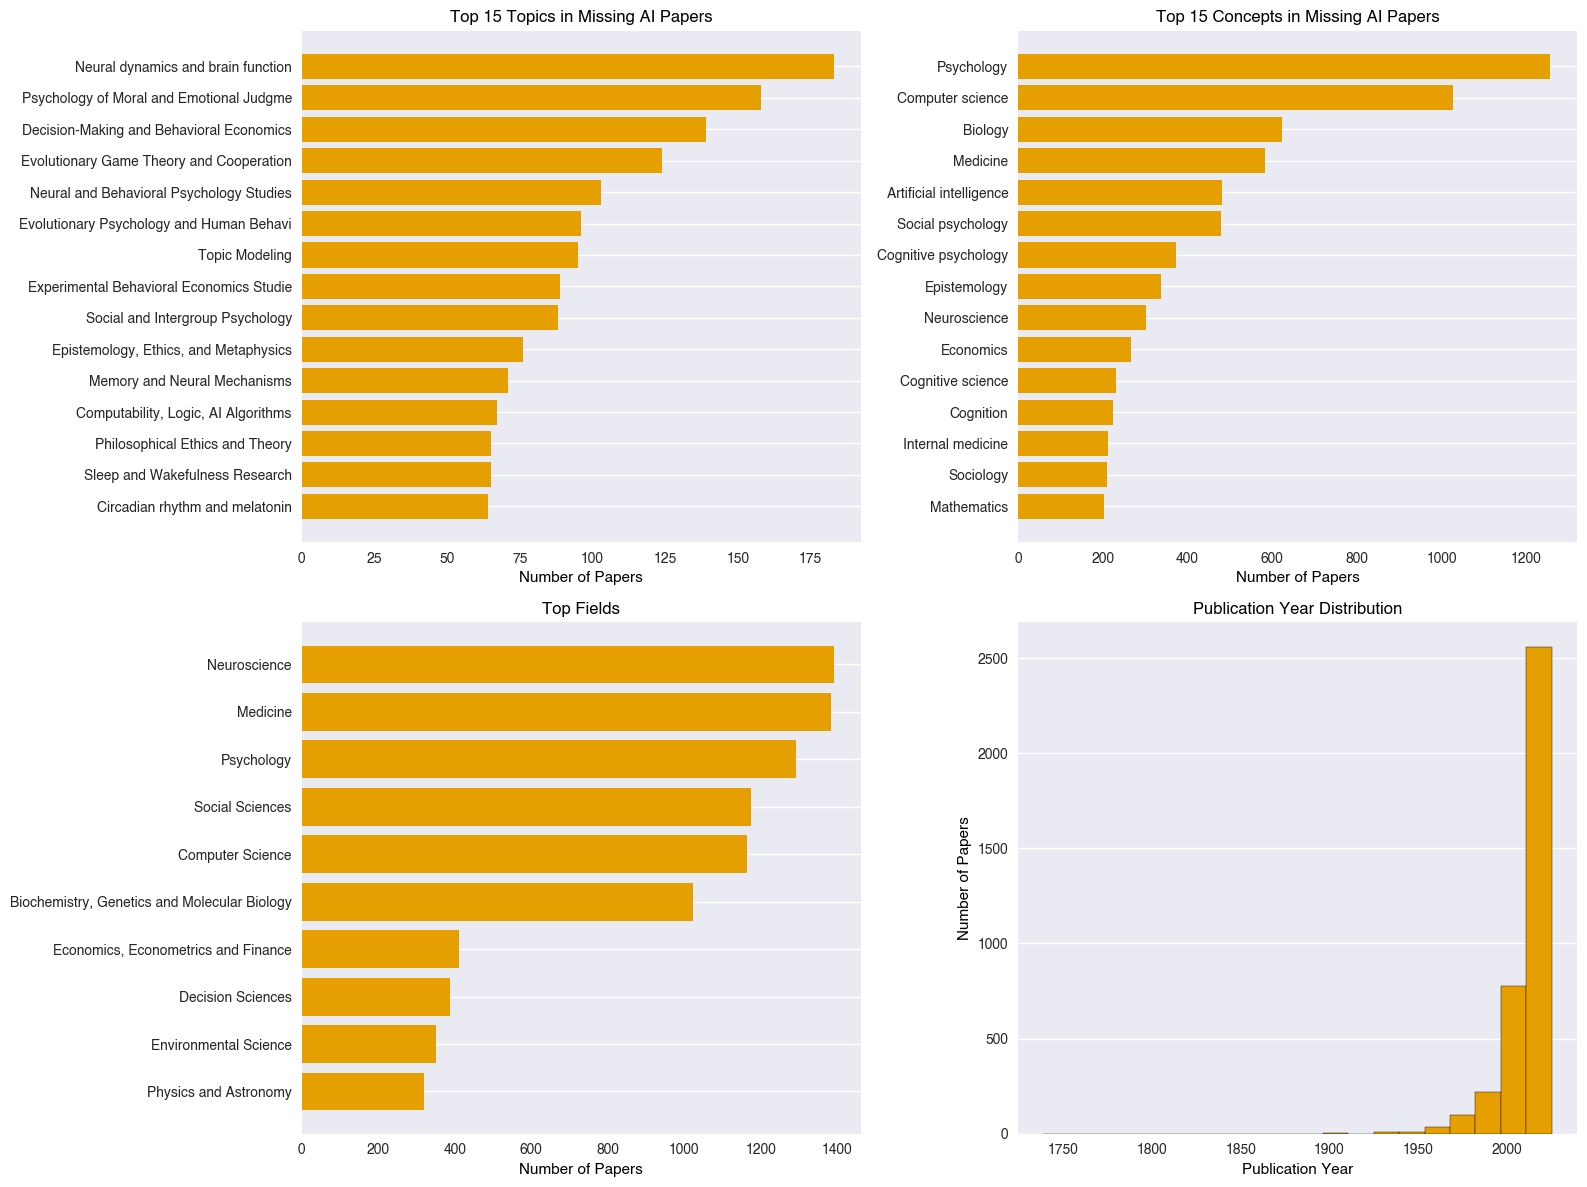

In [107]:
# =============================================================================
# VISUALIZATION
# =============================================================================

print("\n" + "="*80)
print("5️⃣  CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top Topics
top_topics = topic_counts.most_common(15)
axes[0, 0].barh([t[0][:40] for t in reversed(top_topics)], [t[1] for t in reversed(top_topics)])
axes[0, 0].set_xlabel('Number of Papers')
axes[0, 0].set_title('Top 15 Topics in Missing AI Papers')

# Plot 2: Top Concepts
top_concepts = concept_counts.most_common(15)
axes[0, 1].barh([t[0][:40] for t in reversed(top_concepts)], [t[1] for t in reversed(top_concepts)])
axes[0, 1].set_xlabel('Number of Papers')
axes[0, 1].set_title('Top 15 Concepts in Missing AI Papers')

# Plot 3: Fields Distribution
field_data = pd.Series(field_counts).sort_values(ascending=True).tail(10)
axes[1, 0].barh(field_data.index, field_data.values)
axes[1, 0].set_xlabel('Number of Papers')
axes[1, 0].set_title('Top Fields')

# Plot 4: Publication Years
years = [p['publication_year'] for p in detailed_papers if p['publication_year']]
axes[1, 1].hist(years, bins=20, edgecolor='black')
axes[1, 1].set_xlabel('Publication Year')
axes[1, 1].set_ylabel('Number of Papers')
axes[1, 1].set_title('Publication Year Distribution')

plt.tight_layout()
plt.savefig('missing_ai_papers_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization to 'missing_ai_papers_analysis.png'")

In [109]:
# =============================================================================
# RECOMMENDATIONS
# =============================================================================

print("\n" + "="*80)
print("6️⃣  RECOMMENDATIONS FOR EXPANDING YOUR DATASET")
print("="*80)

print(f"""
CURRENT FILTER: topics.id:T10883 (AI Safety)

SUGGESTED ADDITIONAL TOPIC IDs TO INCLUDE:
{', '.join([f'T{tid}' for tid, _ in topic_id_counts.most_common(10)])}

OPTION A - Expand with specific topics:
filter='topics.id:T10883|{"|".join([tid for tid, _ in topic_id_counts.most_common(10)])}'

OPTION B - Use broader field filter:
filter='topics.field.id:...' (use Computer Science field)

OPTION C - Fetch these specific papers:
# Create a list of DOIs and fetch them individually
dois_to_fetch = {ai_related_dois}
for doi in dois_to_fetch:
    fetch_paper_from_openalex(doi)

SAFETY/ETHICS RELEVANCE:
- {len(ethics_related)} papers ({len(ethics_related)/len(detailed_papers)*100:.1f}%) explicitly mention safety/ethics
- These are highly relevant to AI safety discourse
- Recommend including them in your dataset
""")


6️⃣  RECOMMENDATIONS FOR EXPANDING YOUR DATASET

CURRENT FILTER: topics.id:T10883 (AI Safety)

SUGGESTED ADDITIONAL TOPIC IDs TO INCLUDE:
TT10581, TT12520, TT10315, TT11252, TT10042, TT11118, TT10028, TT10646, TT10314, TT11477

OPTION A - Expand with specific topics:
filter='topics.id:T10883|T10581|T12520|T10315|T11252|T10042|T11118|T10028|T10646|T10314|T11477'

OPTION B - Use broader field filter:
filter='topics.field.id:...' (use Computer Science field)

OPTION C - Fetch these specific papers:
# Create a list of DOIs and fetch them individually
dois_to_fetch = ['10.1007/s11238-006-9004-4', '10.1080/01621459.1995.10476620', '10.1038/nj7312-240a', '10.1371/journal.pone.0065522', '10.1002/14651858.cd000371.pub5', '10.1002/9781119993384', '10.1111/j.1753-4887.1974.tb05180.x', '10.1080/13674679908406332', '10.1521/jscp.23.5.603.50748', '10.1521/jscp.2000.19.1.56', '10.1002/9780470713853.ch2', '10.1111/j.1468-2958.2007.00293.x', '10.1056/nejmoa1307352', '10.1038/nature.2012.11535', '10.11

In [106]:
import json

# Flatten the nested structure
flattened_data = []

for paper in detailed_papers:
    flat_paper = {
        'doi': paper.get('doi'),
        'openalex_id': paper.get('openalex_id'),
        'title': paper.get('title'),
        'publication_year': paper.get('publication_year'),
        'cited_by_count': paper.get('cited_by_count'),
        'type': paper.get('type'),
        'venue': paper.get('venue'),
        
        # Topics - take top 3
        'topic_1_id': paper['topics'][0]['id'] if len(paper.get('topics', [])) > 0 else None,
        'topic_1_name': paper['topics'][0]['name'] if len(paper.get('topics', [])) > 0 else None,
        'topic_1_score': paper['topics'][0]['score'] if len(paper.get('topics', [])) > 0 else None,
        
        'topic_2_id': paper['topics'][1]['id'] if len(paper.get('topics', [])) > 1 else None,
        'topic_2_name': paper['topics'][1]['name'] if len(paper.get('topics', [])) > 1 else None,
        'topic_2_score': paper['topics'][1]['score'] if len(paper.get('topics', [])) > 1 else None,
        
        'topic_3_id': paper['topics'][2]['id'] if len(paper.get('topics', [])) > 2 else None,
        'topic_3_name': paper['topics'][2]['name'] if len(paper.get('topics', [])) > 2 else None,
        'topic_3_score': paper['topics'][2]['score'] if len(paper.get('topics', [])) > 2 else None,
        
        # All topics as JSON string
        'all_topics': json.dumps(paper.get('topics', [])),
        
        # Concepts - join names
        'num_concepts': len(paper.get('concepts', [])),
        'concepts': '; '.join([c['name'] for c in paper.get('concepts', [])]),
        'concepts_json': json.dumps(paper.get('concepts', [])),
        
        # Keywords
        'num_keywords': len(paper.get('keywords', [])),
        'keywords': '; '.join([k.get('display_name', '') for k in paper.get('keywords', [])]),
        
        # Abstract
        'has_abstract': paper.get('abstract_inverted_index') is not None,
        'abstract_inverted_index': json.dumps(paper.get('abstract_inverted_index')) if paper.get('abstract_inverted_index') else None,
    }
    
    flattened_data.append(flat_paper)

# Create DataFrame
df = pd.DataFrame(flattened_data)

# Save to CSV
df.to_csv('../missing_ai_papers_detailed.csv', index=False, encoding='utf-8')

print(f"✓ Saved {len(df)} papers to 'missing_ai_papers_detailed.csv'")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df[['doi', 'title', 'topic_1_name', 'topic_2_name']].head())

✓ Saved 3716 papers to 'missing_ai_papers_detailed.csv'

Columns: ['doi', 'openalex_id', 'title', 'publication_year', 'cited_by_count', 'type', 'venue', 'topic_1_id', 'topic_1_name', 'topic_1_score', 'topic_2_id', 'topic_2_name', 'topic_2_score', 'topic_3_id', 'topic_3_name', 'topic_3_score', 'all_topics', 'num_concepts', 'concepts', 'concepts_json', 'num_keywords', 'keywords', 'has_abstract', 'abstract_inverted_index']

First few rows:
                              doi  \
0       10.1007/s11238-006-9004-4   
1  10.1080/01621459.1995.10476620   
2             10.1038/nj7312-240a   
3    10.1371/journal.pone.0065522   
4  10.1002/14651858.cd000371.pub5   

                                                                                                                                      title  \
0                                                                                                   Uncommon Priors Require Origin Disputes   
1                                                 

In [5]:
unknown_gender = combined_df[combined_df["user_gender"] == '-']
unknown_gender_counts = unknown_gender['user.username'].value_counts()
# if (unknown_gender_counts < 5).any():
unknwons = set(unknown_gender_counts.index)
unknowns_lower = {name.lower() for name in unknwons}

In [6]:
for user in unknowns_lower:
    print(user)

rcu
denreik
kohaku-none
funkycoder
lexico
rangi
jooyous
solipsist
fiddlemath
carn
zhaowei zhang
kytael
harfe
acrackedpot
elec0
expipiplusone
ar-sht
jbay
onewhofrogs
htlou
minibearrex
alvaromoret
eniscien
roxolan
cfar team
yanni
drocta
racinkc1
ahbwramc
dal
ekkolapto
gcmac
verbalshadow
furcas
9eb1
flowerfeatherfocus
spookyuser
bramflakes
edanm
en kepeig
shiroe
ratswrongaboutuap
realitygrill
avery-liu
demeter
xfrequentist
calecute
smitop
ete
irenictruth
schrodingart
tmfow
disoha
kei
kiboneu
rorschak
eugman
qbee
senarin
thetwelve
af2022
physicaleconomics
lionhearted
tanagrabeast
dentosal
caffemacchiavelli
tsang chung shu
ratcourse
lejuletre
randomini
wheelspawn
summerstay
aspiringknitter
ajfox
creatorrr
ahartntkn
askwho
jmiller
jpyykko
natural_number
hu-yichao
ndee
caesium
mnoetel
borasko
dripgrind
d𝜋
zlrth
milkandcigarettes
kingreaper
petruchio
mushroomsoup
hairyfigment
person-1
erfeyah
emr
sark
perplexed
purge
xpostah
elo
hangedman
wiserd
bayareahuman
twistingfingers
networked
nanashi
r

In [ ]:
import json
with open("../src/metadata/graphql_usernames.json", "r", encoding="utf-8") as f:
        names_data = json.load(f)

MALE_USERNAMES = names_data["MALE_USERNAMES"]
FEMALE_USERNAMES = names_data["FEMALE_USERNAMES"]

KeyError: 'MALE_NAMES'

In [ ]:
unknowns_without_male = unknowns_lower.difference(names.MALE_NAMES)
unknowns_without_female = unknowns_lower.difference(names.FEMALE_NAMES)
print(f'Unkown names that are neither in FEMALE_NAMES nor MALE_NAMES: {len(unknowns_without_male.intersection(unknowns_without_female))}')
print(unknowns_without_male.intersection(unknowns_without_female))

In [ ]:
male_names_without_unknowns = names.MALE_NAMES.difference(unknowns_lower)
print(sorted(male_names_without_unknowns))
print(sorted(names.MALE_NAMES - male_names_without_unknowns))
print(sorted(names.MALE_NAMES - names.MALE_USERNAMES))

In [ ]:
import importlib
import src.names as names
importlib.reload(names) 

In [ ]:
female_names_without_unknowns = names.FEMALE_NAMES.difference(unknowns_lower)
print(female_names_without_unknowns)
print(names.FEMALE_NAMES - female_names_without_unknowns)
print(names.FEMALE_NAMES - names.FEMALE_USERNAMES)

In [ ]:

import src.names as names
 # Force reload
print(type(names.MALE_NAMES))  # Should be <class 'set'>
print(len(names.MALE_NAMES))   # Check the size
print('yashvardhan' in names.MALE_NAMES)

In [ ]:
print(sorted(names.MALE_NAMES))

In [ ]:
purely_unknown = unknwons - names.MALE_USERNAMES

In [ ]:
purely_unknown_lower = {name.lower() for name in purely_unknown}
male_names_lower = {name.lower() for name in names.MALE_USERNAMES}
print(purely_unknown_lower.intersection(male_names_lower))

In [ ]:
all_names = list(names.FEMALE_NAMES) + list(names.MALE_NAMES)
all_names_sorted = sorted(all_names, key=len, reverse=True)

gf = []
gf_user = []
gm = []
gm_user = []

for username in unknowns_lower:
    for name in all_names_sorted:
        if len(name) > 3 and name in username:
            if name in names.FEMALE_NAMES:
                print(f"FEMALE: {username} with {name}")
                gf_user.append(username)
                gf.append(name)
            elif name in names.MALE_NAMES:
                print(f"MALE: {username} with {name}")
                gm_user.append(username)
                gm.append(name)

In [ ]:
print(gf_user)
print(len(gf_user))
print(gm_user)
print(len(gm_user))

In [ ]:
current_unknowns = unknowns_lower - set(gf_user) - set(gm_user)
for name in current_unknowns:
    print(name)

In [ ]:
perplexity = [1150.00, 1105.33, 1072.61, 1054.01, 1040.12, 1028.32, 1018.51, 1009.65, 1002.37]
topics = [10, 15, 20, 25, 30, 35, 40, 45, 50]
log_likelihood = [-126311522.90,-125601505.71, -125062974.37, -124749334.57, -124511617.32,  -124307203.07, -124135376.41, -123978846.41, -123849036.87]
plt.plot(topics, perplexity)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(topics, perplexity, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(topics, log_likelihood, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()